### Sample size effect in gene co-expression networks

- Author: Joaquim Aguirre Plans<br>
- Institution: Northeastern University

Load libraries:

In [1]:
import sys, os
import graph_tool.all as gt
import matplotlib.pyplot as plt
import multiprocessing as mp
import networkx as nx
import numpy as np
import pandas as pd
import pylab
import random
import seaborn as sns
import scipy
import time
import NetworkMedicineToolbox.wrappers as wrappers
import NetworkMedicineToolbox.network_utilities as network_utilities
import coexpression_analysis_functions_graphtool as canx
random.seed(1510)

/home/j.aguirreplans/.conda/envs/ScipherSampleSizeEnv/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:1494: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


GenRev not found, steiner wont work
Import error: Negex. Using keyword matching instead
Import error: Funcassociate. Make sure that funcassociate is in toolbox!
DIAMOnD not found and thus will not be available!


In [2]:
def fileExist(file):
    """
    Checks if a file exists AND is a file
    """
    return os.path.exists(file) and os.path.isfile(file)


def create_directory(directory):
    """
    Checks if a directory exists and if not, creates it
    """
    try:
        os.stat(directory)
    except:
        os.mkdir(directory)
    return


## Sample size effect in network size and composition

In this part, I check the effect of the sample size in the size of gene co-expression networks.

In [3]:
# Define directories and files
scratch_data_dir = '/scratch/j.aguirreplans/Scipher/SampleSize'
home_data_dir = '/home/j.aguirreplans/Projects/Scipher/SampleSize/data'
ppi_dir = '/home/j.aguirreplans/data/PPI'
wto_results_dir = os.path.join(scratch_data_dir, 'networks_nonresponders_wto_N100')
results_name = 'analysis_nonresponders_wto_N100'
#wto_results_dir = os.path.join(scratch_data_dir, 'example_networks_nonresponders_wto')
output_dir = os.path.join(home_data_dir, 'out')
plots_dir = os.path.join(output_dir, 'plots_N100')
#plots_dir = os.path.join(output_dir, 'plots_example')
create_directory(plots_dir)


In [4]:
# Define parameters of bootstrap
rep = 10
step = 10
max_num_samples = 56
size_list = list(range(10, max_num_samples+1, step))
print('List of sample sizes considered: {}'.format(', '.join([str(size) for size in size_list])))
print('Number of repetitions of each sample size: {}'.format(rep))

List of sample sizes considered: 10, 20, 30, 40, 50
Number of repetitions of each sample size: 10


In [6]:
topology_by_pval_df = pd.DataFrame(columns=['size', 'rep', 'nodes', 'edges', 'av_degree', 'av_path_length', 'av_clustering_coef', 'num_communities'])
#kendall_df = pd.DataFrame(columns=['size', 'kendall'])
components_by_pval_df = pd.DataFrame(columns=['size', 'rep', 'num_components', 'size_lcc', 'pval_adj_cutoff'])
#disease_df = pd.DataFrame(columns=['size', 'rep', 'disease', 'disease_class', 'total_disease_genes', 'total_disease_genes_in_dataset', 'disease_genes_in_network', 'lcc_size'])
#composition_df = pd.DataFrame(columns=['size', 'rep', 'nodes', 'edges', 'lost_or_gained', 'pval_adj_cutoff'])
for size in size_list:
    for pval_adj_cutoff in [0.01, 0.05]:
        dataframes_dir = os.path.join(output_dir, '{}_pval_{}'.format(results_name, pval_adj_cutoff))
        topology_file = os.path.join(dataframes_dir, 'topology_size_{}.txt'.format(size))
        components_file = os.path.join(dataframes_dir, 'components_size_{}.txt'.format(size))
        if fileExist(topology_file):
            topology_by_pval_df_size = pd.read_csv(dataframes_dir)
            topology_by_pval_df_size['pval_adj_cutoff'] = pval_adj_cutoff
            topology_by_pval_df = pd.concat([topology_by_pval_df, topology_by_pval_df_size], ignore_index=True)
            components_by_pval_df_size = pd.read_csv(components_file)
            components_by_pval_df_size['pval_adj_cutoff'] = pval_adj_cutoff
            components_by_pval_df = pd.concat([components_by_pval_df, components_by_pval_df_size], ignore_index=True)


In [7]:
topology_df = pd.DataFrame(columns=['size', 'rep', 'nodes', 'edges', 'av_degree', 'av_path_length', 'av_clustering_coef', 'num_communities'])
#kendall_df = pd.DataFrame(columns=['size', 'kendall'])
components_df = pd.DataFrame(columns=['size', 'rep', 'num_components', 'size_lcc', 'pval_adj_cutoff'])
disease_df = pd.DataFrame(columns=['size', 'rep', 'disease', 'disease_class', 'total_disease_genes', 'total_disease_genes_in_dataset', 'disease_genes_in_network', 'lcc_size'])
composition_df = pd.DataFrame(columns=['size', 'rep', 'nodes', 'edges', 'lost_or_gained', 'pval_adj_cutoff'])
for size in size_list:
    for pval_adj_cutoff in [0.01]:
        for top_percent in [0.1, 0.5, 1]:
            dataframes_dir = os.path.join(output_dir, '{}_pval_{}_top_{}'.format(results_name, pval_adj_cutoff, top_percent))
            topology_df_size = pd.read_csv(os.path.join(dataframes_dir, 'topology_size_{}.txt'.format(size)))
            topology_df_size['pval_adj_cutoff'] = pval_adj_cutoff
            topology_df_size['top_percent'] = top_percent
            topology_df = pd.concat([topology_df, topology_df_size], ignore_index=True)
            #print(topology_df_size)
            components_df_size = pd.read_csv(os.path.join(dataframes_dir, 'components_size_{}.txt'.format(size)))
            components_df_size['pval_adj_cutoff'] = pval_adj_cutoff
            components_df_size['top_percent'] = top_percent
            components_df = pd.concat([components_df, components_df_size], ignore_index=True)
            disease_df_size = pd.read_csv(os.path.join(dataframes_dir, 'disease_components_size_{}.txt'.format(size)), index_col=0)
            disease_df_size['pval_adj_cutoff'] = pval_adj_cutoff
            disease_df_size['top_percent'] = top_percent
            disease_df = pd.concat([disease_df, disease_df_size], ignore_index=True)
            composition_df_size = pd.read_csv(os.path.join(dataframes_dir, 'composition_size_{}.txt'.format(size)))
            composition_df_size['pval_adj_cutoff'] = pval_adj_cutoff
            composition_df_size['top_percent'] = top_percent
            composition_df = pd.concat([composition_df, composition_df_size], ignore_index=True)
#topology_df


### Sample size effect on network size

I plot the number of nodes and edges of the different networks with respect to the sample size.

In [8]:
# Plot num. of edges vs sample size (depending on the p-value)
fig = pylab.figure(dpi=300)
sns.boxplot(data=topology_by_pval_df, x='size', y='edges', hue="pval_adj_cutoff", color='dodgerblue')
plt.title('Number of edges vs. sample size')
plt.xlabel('Sample size')
plt.ylabel('Number of edges')
plt.legend(title='P-value threshold') # https://stackoverflow.com/questions/45201514/how-to-edit-a-seaborn-legend-title-and-labels-for-figure-level-functions
pylab.savefig(os.path.join(plots_dir, 'num_edges_vs_sample_size_by_pval.png'), format='png')
plt.show()

# Plot num. of nodes vs sample size (depending on the p-value)
fig = pylab.figure(dpi=300)
sns.boxplot(data=topology_by_pval_df, x='size', y='nodes', hue="pval_adj_cutoff", color='dodgerblue')
plt.title('Number of nodes vs. sample size')
plt.xlabel('Sample size')
plt.ylabel('Number of nodes')
plt.legend(title='P-value threshold') # https://stackoverflow.com/questions/45201514/how-to-edit-a-seaborn-legend-title-and-labels-for-figure-level-functions
pylab.savefig(os.path.join(plots_dir, 'num_nodes_vs_sample_size_by_pval.png'), format='png')
plt.show()

# Plot num. of nodes vs sample size (depending on the top % of edges)
fig = pylab.figure(dpi=300)
sns.boxplot(data=topology_df, x='size', y='nodes', hue="top_percent", color='dodgerblue')
plt.title('Number of nodes vs. sample size')
plt.xlabel('Sample size')
plt.ylabel('Number of nodes')
plt.legend(title='% of top-scoring edges') # https://stackoverflow.com/questions/45201514/how-to-edit-a-seaborn-legend-title-and-labels-for-figure-level-functions
pylab.savefig(os.path.join(plots_dir, 'num_nodes_vs_sample_size_by_percent.png'), format='png')
plt.show()


ValueError: Could not interpret input 'pval_adj_cutoff'

<Figure size 1800x1200 with 0 Axes>

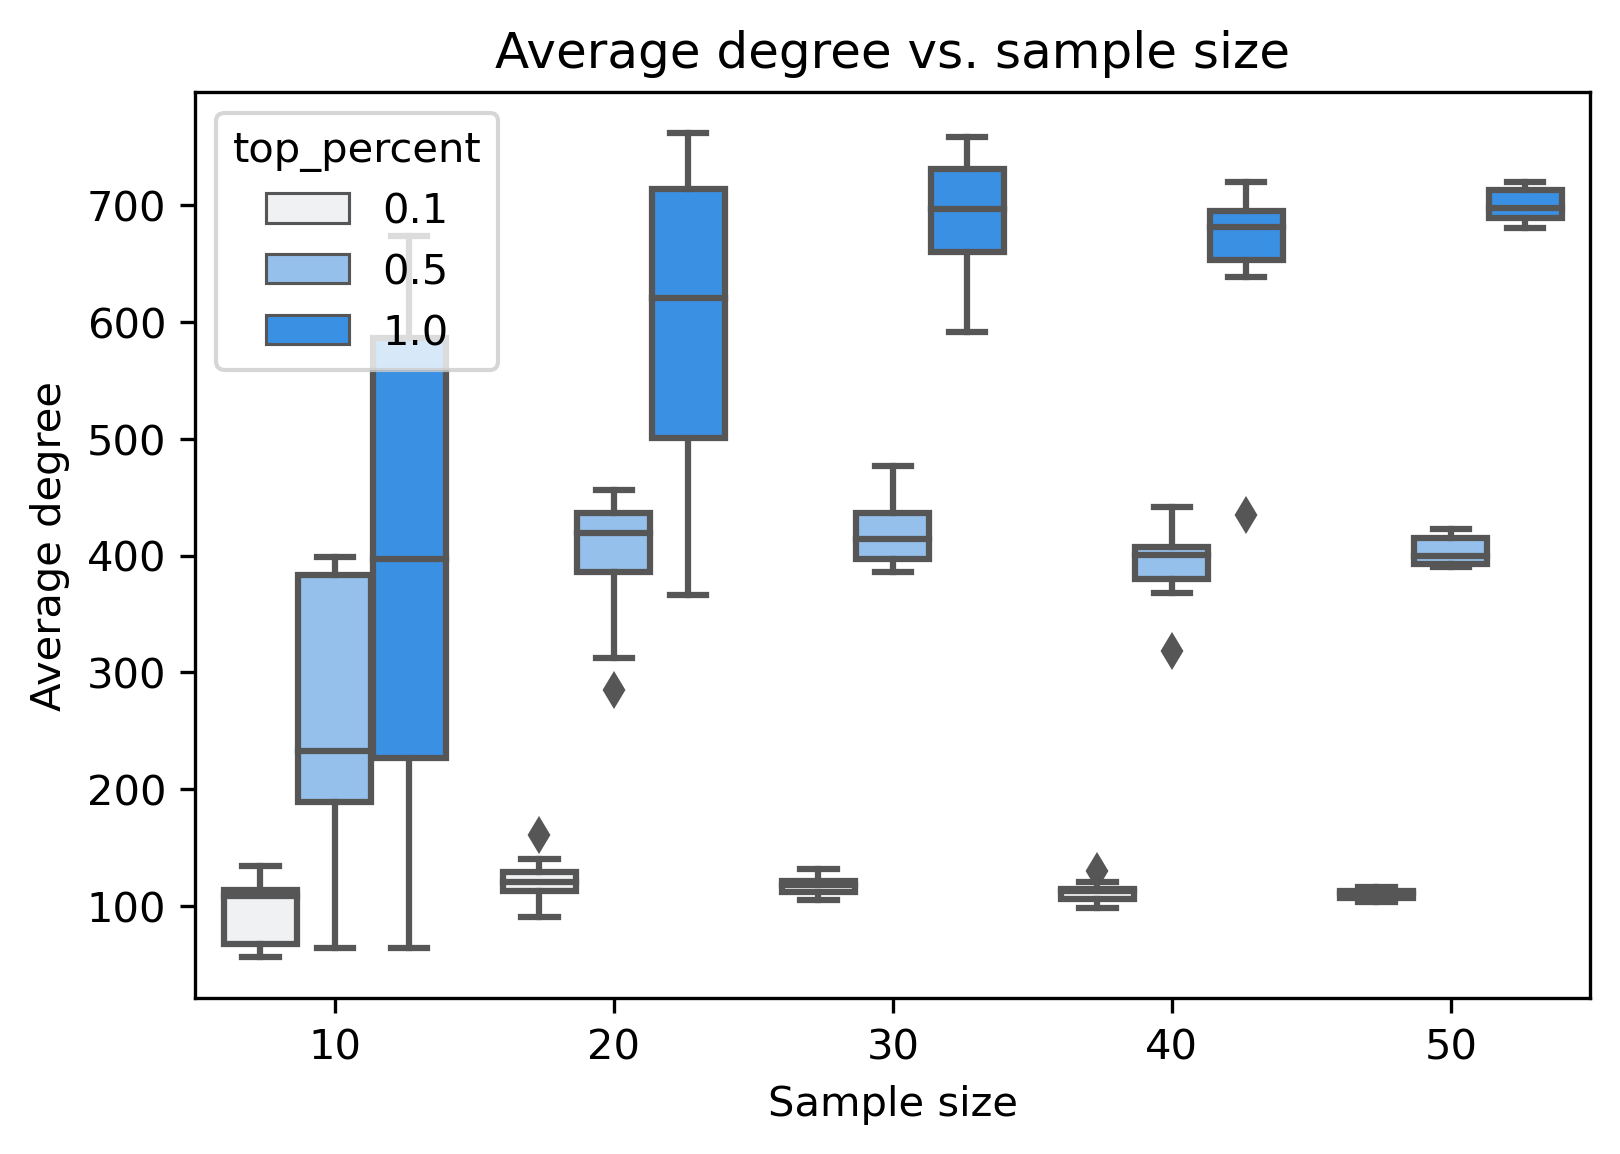

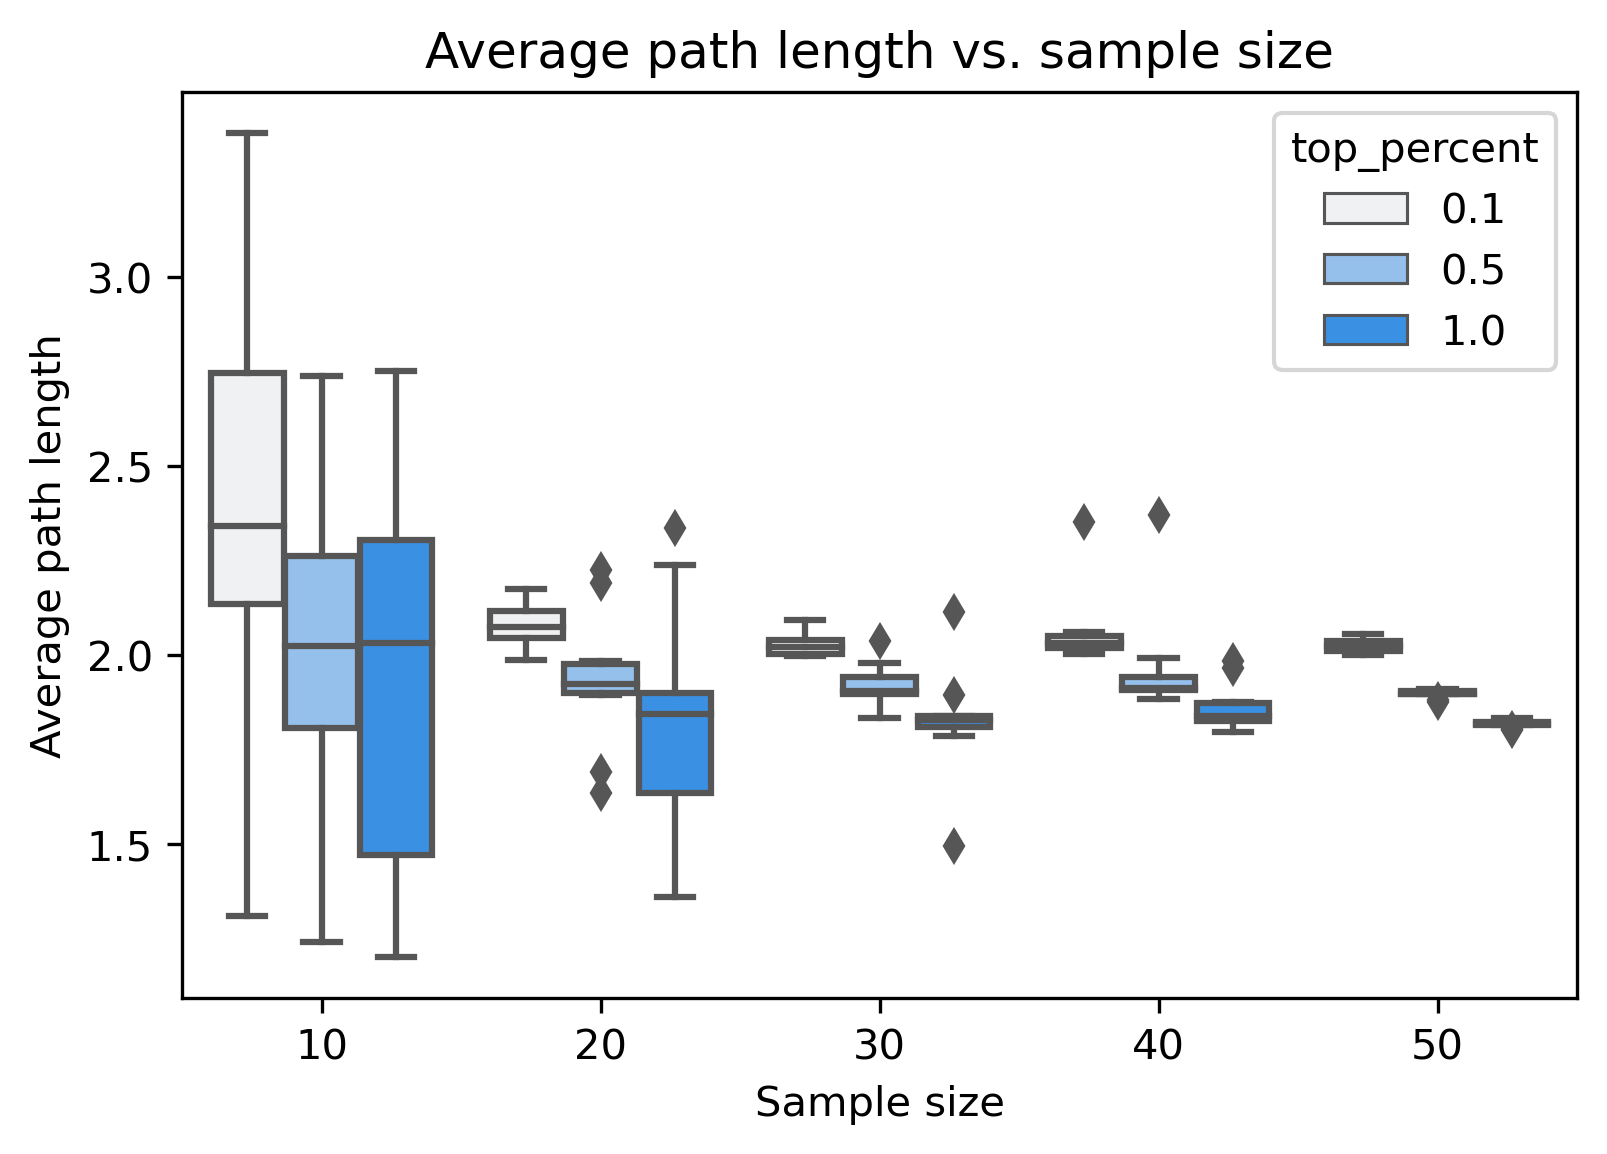

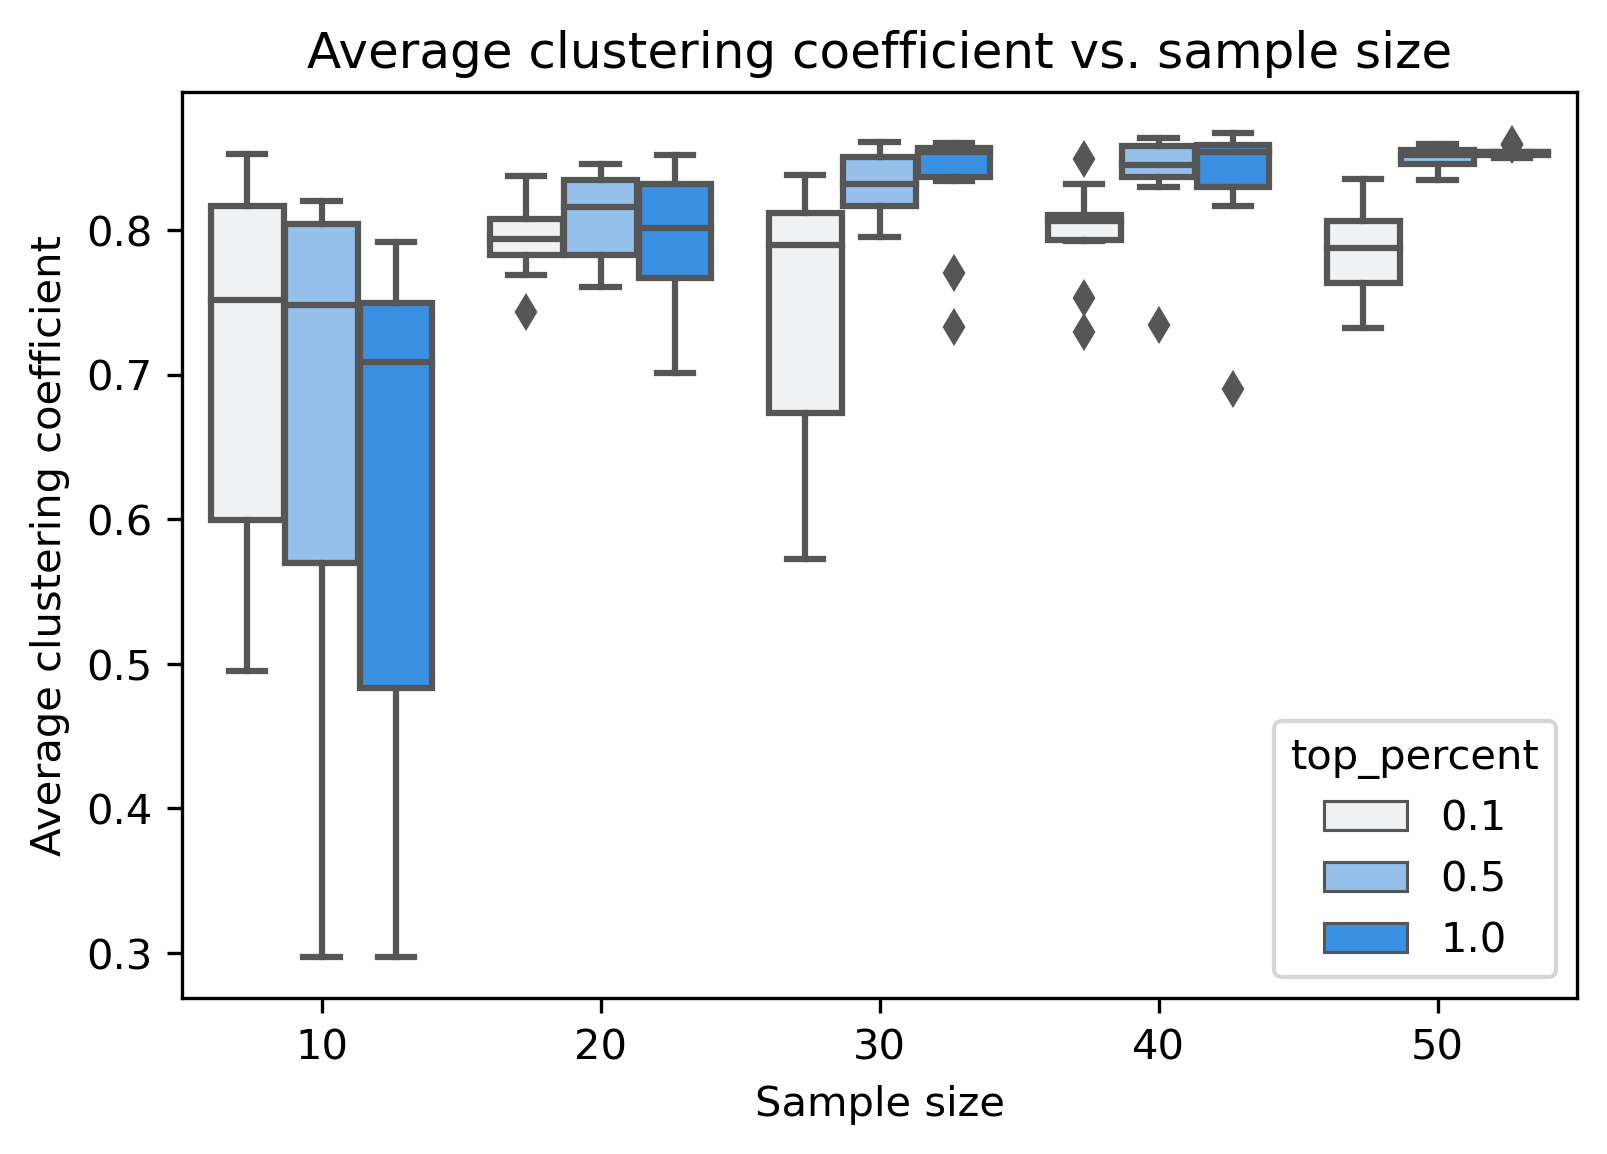

In [9]:
# Plot average degree vs sample size
fig = pylab.figure(dpi=300)
sns.boxplot(data=topology_df, x='size', y='av_degree', hue='top_percent', color='dodgerblue')
plt.title('Average degree vs. sample size')
plt.xlabel('Sample size')
plt.ylabel('Average degree')
pylab.savefig(os.path.join(plots_dir, 'av_degree_vs_sample_size_by_percent.png'), format='png')
plt.show()

# Plot average path length vs sample size
fig = pylab.figure(dpi=300)
sns.boxplot(data=topology_df, x='size', y='av_path_length', hue='top_percent', color='dodgerblue')
plt.title('Average path length vs. sample size')
plt.xlabel('Sample size')
plt.ylabel('Average path length')
pylab.savefig(os.path.join(plots_dir, 'av_path_length_vs_sample_size_by_percent.png'), format='png')
plt.show()

# Plot average clustering coefficient vs sample size
fig = pylab.figure(dpi=300)
sns.boxplot(data=topology_df, x='size', y='av_clustering_coef', hue='top_percent', color='dodgerblue')
plt.title('Average clustering coefficient vs. sample size')
plt.xlabel('Sample size')
plt.ylabel('Average clustering coefficient')
pylab.savefig(os.path.join(plots_dir, 'av_clustering_coef_vs_sample_size_by_percent.png'), format='png')
plt.show()


### Sample size effect in network composition

Here, I check the impact of sample size in the composition of nodes and edges of gene co-expression networks. With this purpose, I check the number of lost and gained edges with respect to the network that has the 100% of samples.

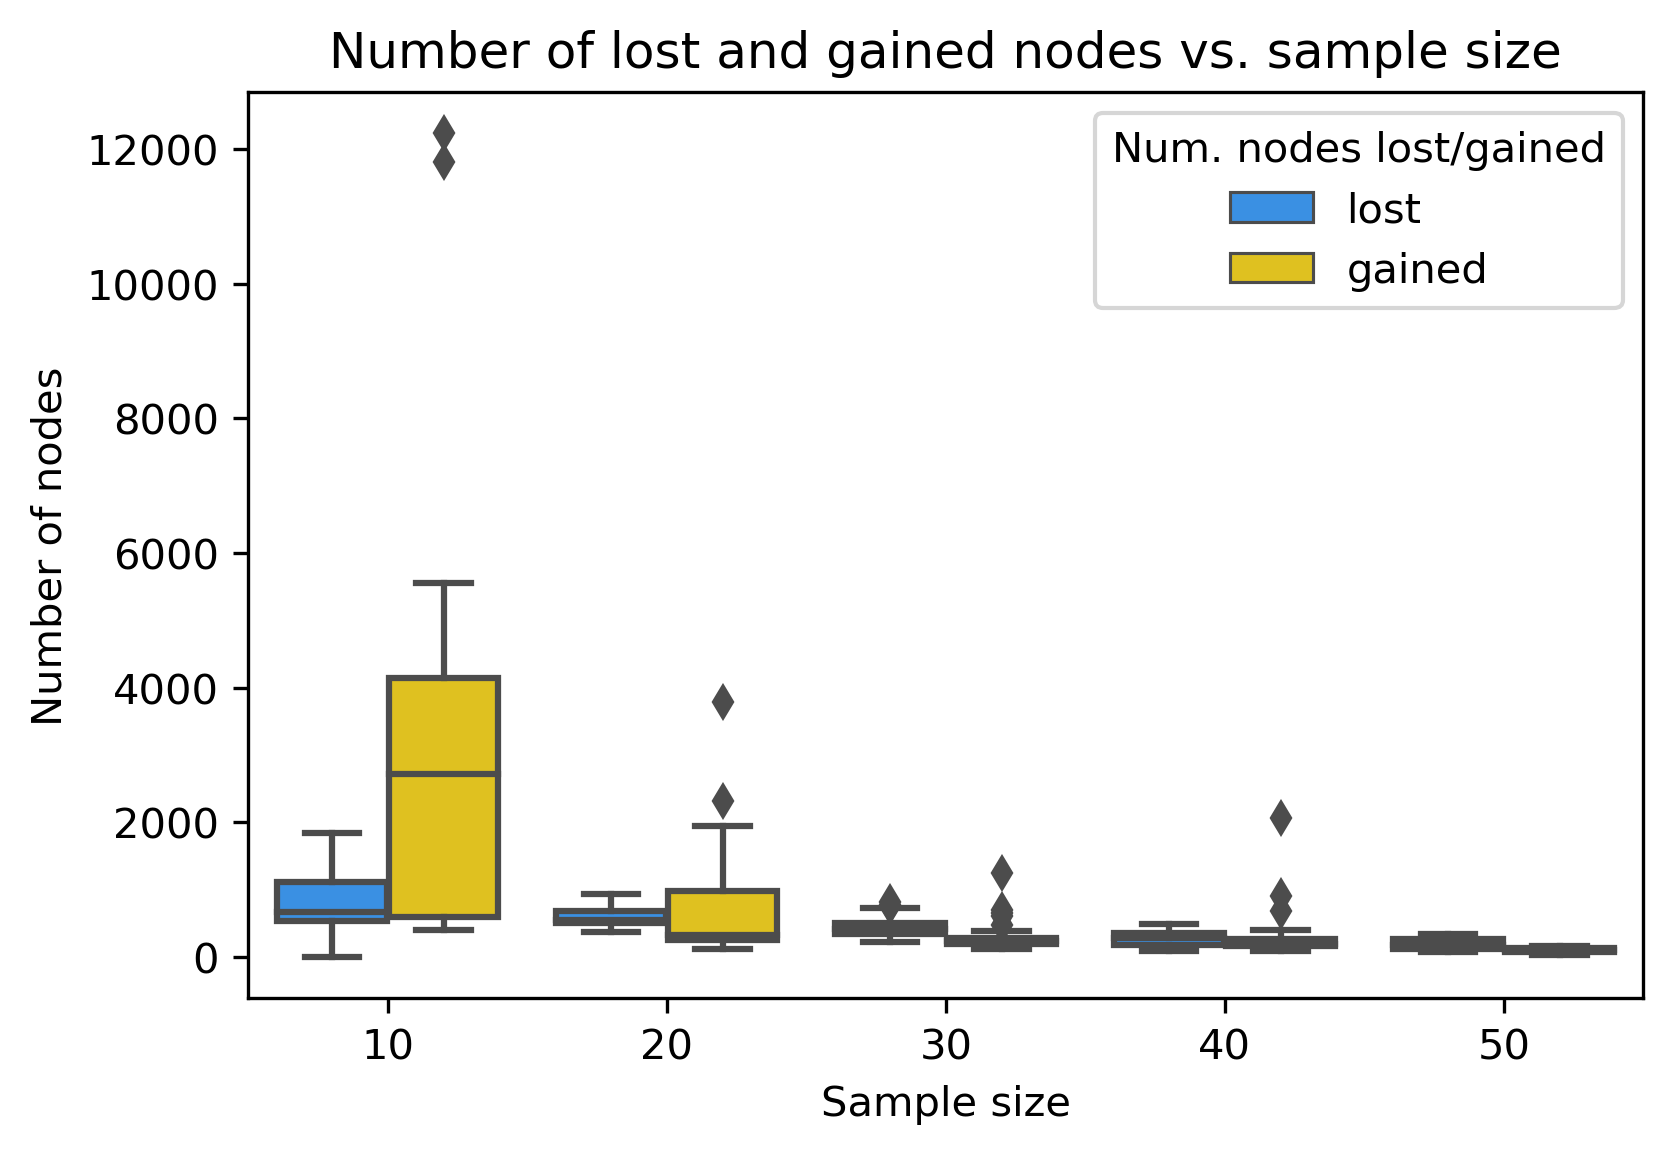

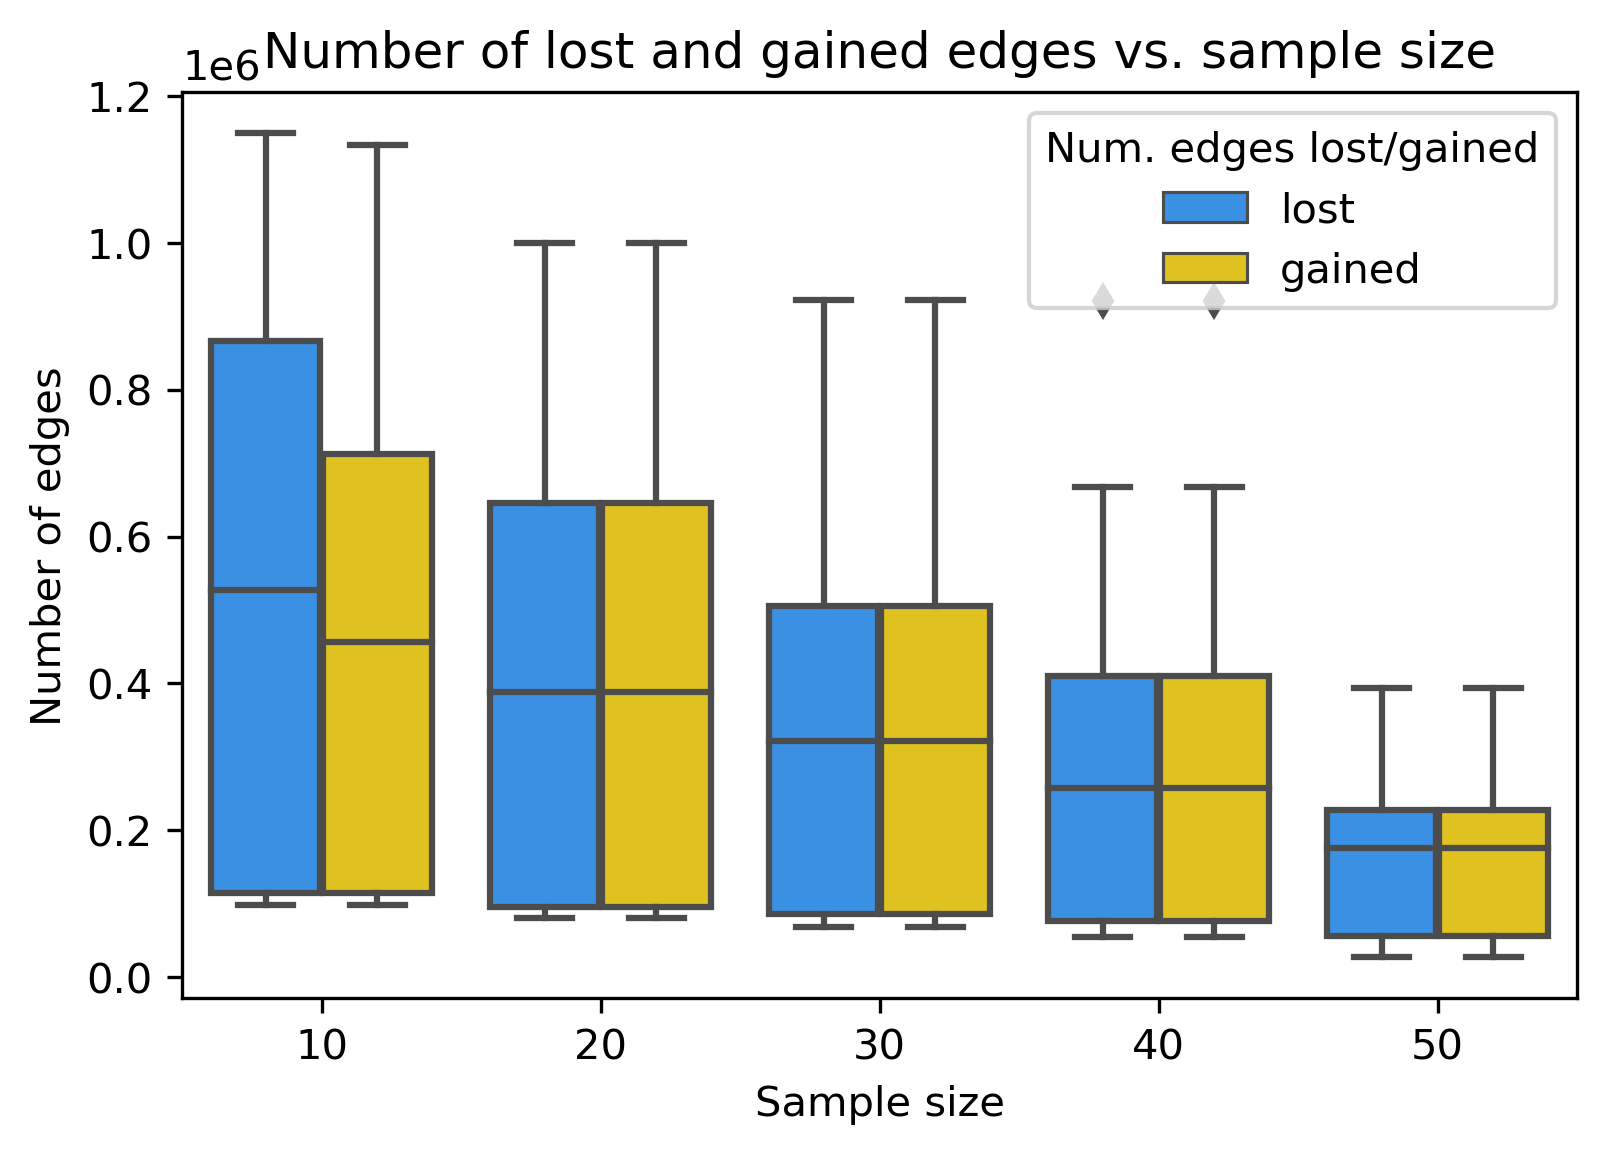

In [10]:
# Plot num. of nodes lost and gained vs sample size
composition_selection_df = composition_df[composition_df['pval_adj_cutoff'] == 0.01].reset_index(drop=True)
fig = pylab.figure(dpi=300)
sns.boxplot(data=composition_selection_df, x="size", y="nodes", hue="lost_or_gained", palette=["dodgerblue", "gold"])
plt.title('Number of lost and gained nodes vs. sample size')
plt.xlabel('Sample size')
plt.ylabel('Number of nodes')
plt.legend(title='Num. nodes lost/gained') # https://stackoverflow.com/questions/45201514/how-to-edit-a-seaborn-legend-title-and-labels-for-figure-level-functions
pylab.savefig(os.path.join(plots_dir, 'num_lost_nodes_vs_sample_size.png'), format='png')
plt.show()

# Plot num. of edges lost and gained vs sample size
fig = pylab.figure(dpi=300)
sns.boxplot(data=composition_selection_df, x="size", y="edges", hue="lost_or_gained", palette=["dodgerblue", "gold"])
plt.title('Number of lost and gained edges vs. sample size')
plt.xlabel('Sample size')
plt.ylabel('Number of edges')
plt.legend(title='Num. edges lost/gained') # https://stackoverflow.com/questions/45201514/how-to-edit-a-seaborn-legend-title-and-labels-for-figure-level-functions
pylab.savefig(os.path.join(plots_dir, 'num_lost_edges_vs_sample_size.png'), format='png')
plt.show()

### Sample size effect on the number of components and size of the LCC

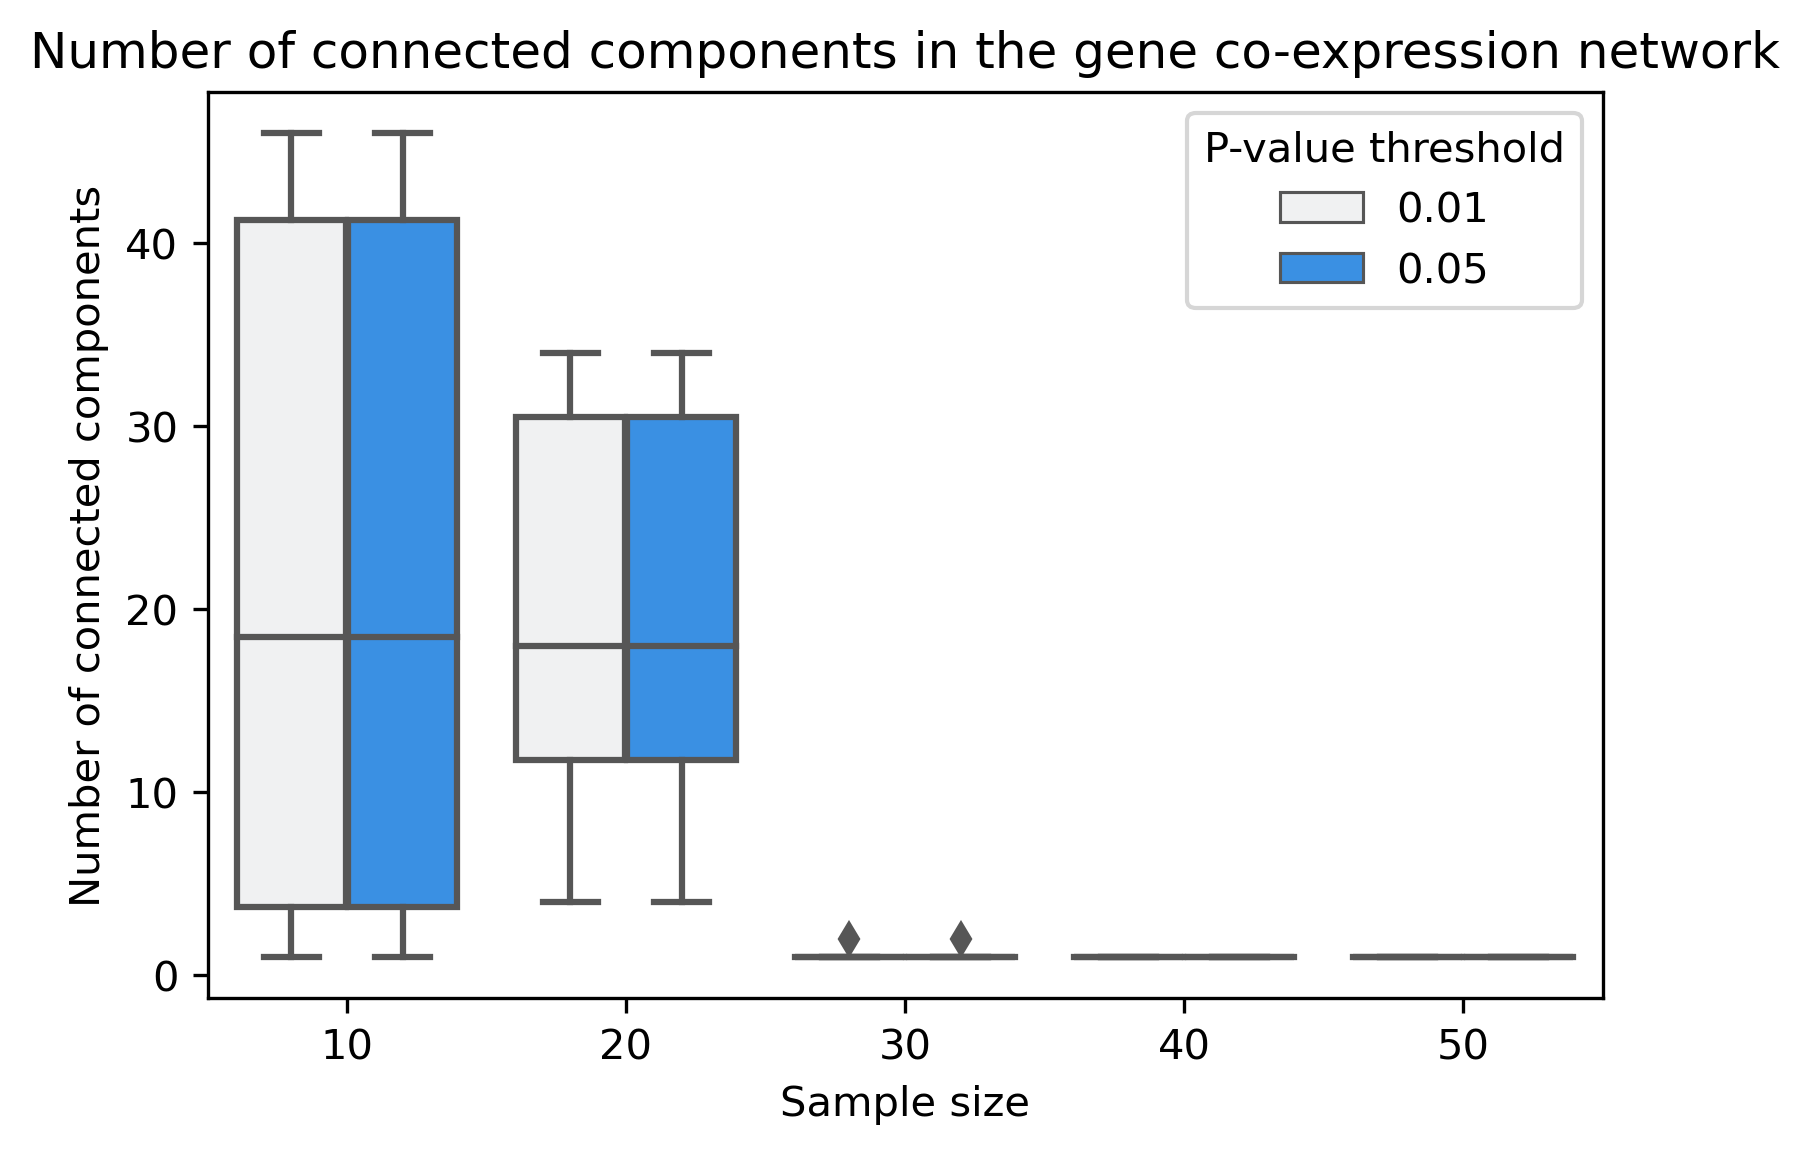

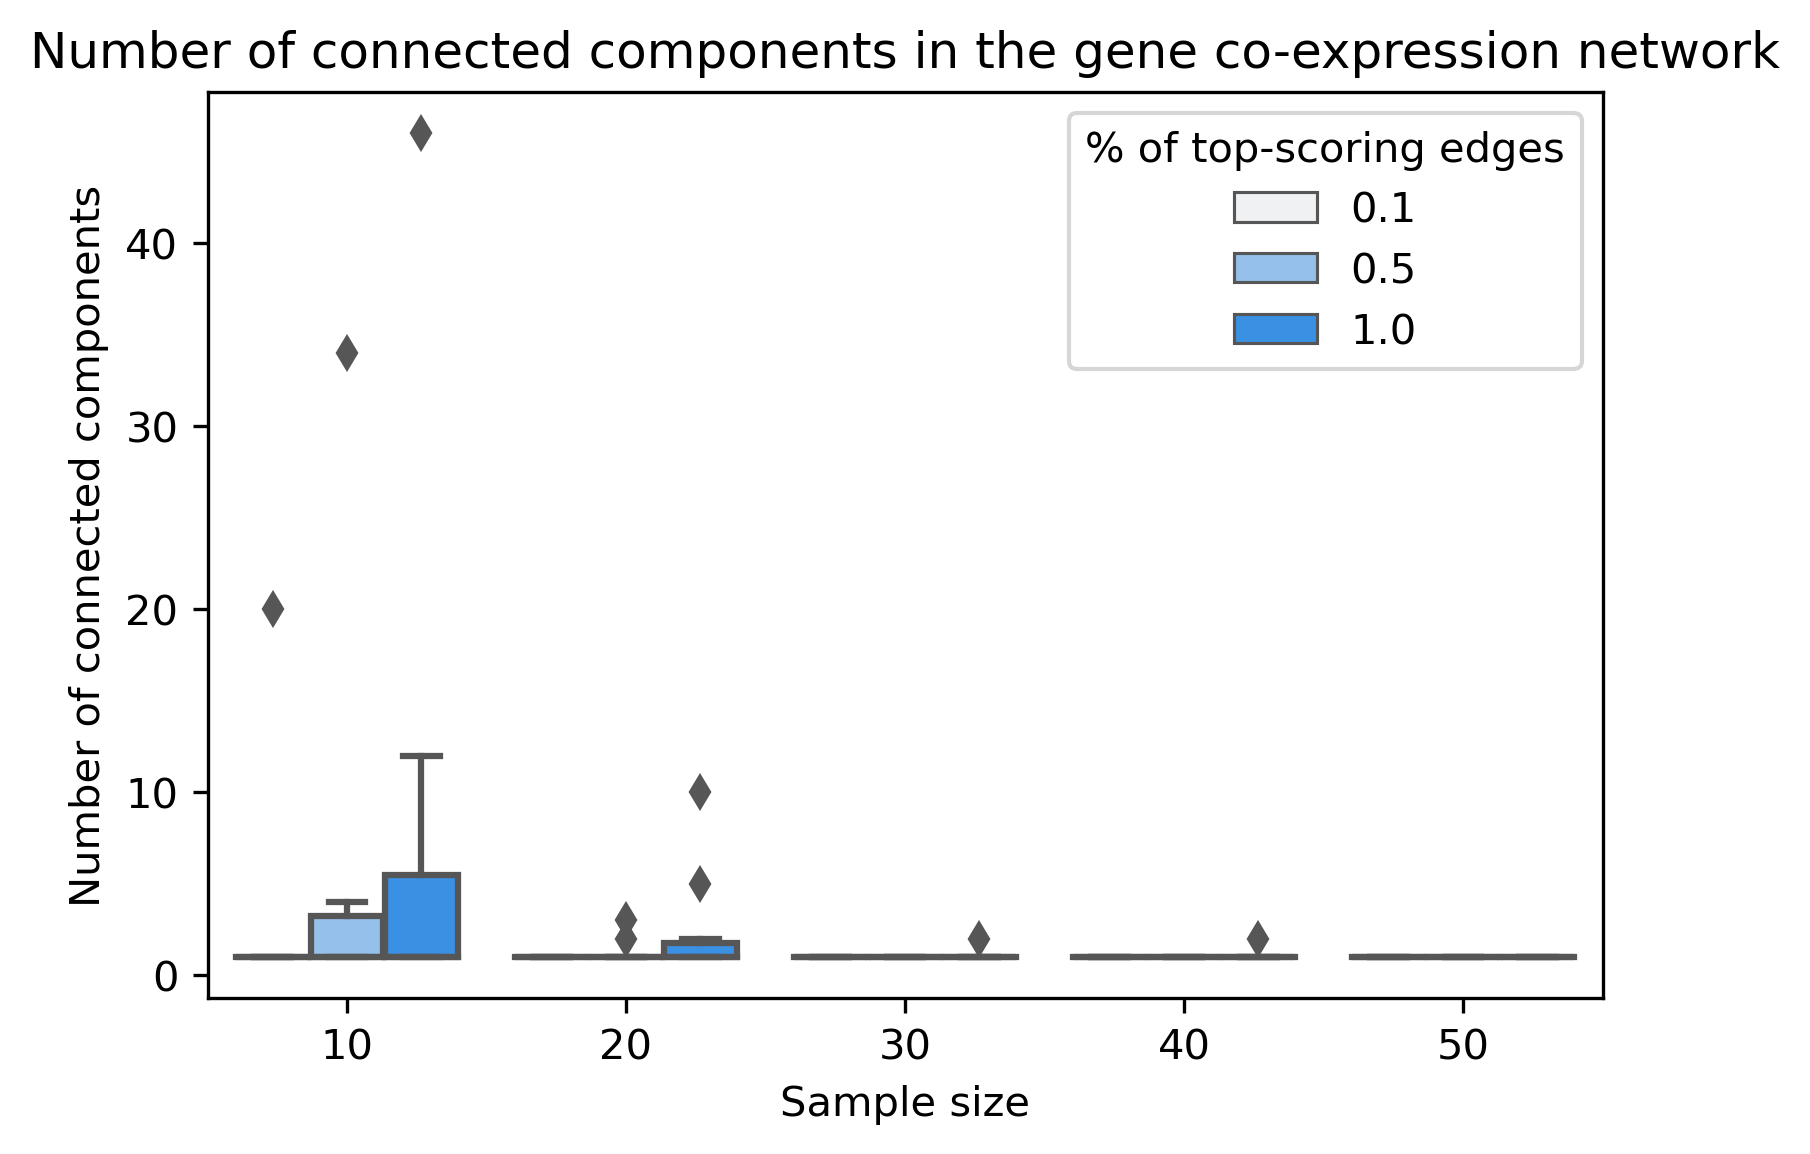

In [16]:
# Plot num. of components vs. sample size (by p-value)
fig = pylab.figure(dpi=300)
sns.boxplot(data=components_by_pval_df, x='size', y='num_components', hue="pval_adj_cutoff", color='dodgerblue')
plt.title('Number of connected components in the gene co-expression network')
plt.xlabel('Sample size')
plt.ylabel('Number of connected components')
plt.legend(title='P-value threshold') # https://stackoverflow.com/questions/45201514/how-to-edit-a-seaborn-legend-title-and-labels-for-figure-level-functions
pylab.savefig(os.path.join(plots_dir, 'num_connected_components_vs_sample_size_by_pval.png'), format='png')
plt.show()

# Plot num. of components vs. sample size (by top scoring edges)
fig = pylab.figure(dpi=300)
sns.boxplot(data=components_df, x='size', y='num_components', hue="top_percent", color='dodgerblue')
plt.title('Number of connected components in the gene co-expression network')
plt.xlabel('Sample size')
plt.ylabel('Number of connected components')
plt.legend(title='% of top-scoring edges') # https://stackoverflow.com/questions/45201514/how-to-edit-a-seaborn-legend-title-and-labels-for-figure-level-functions
pylab.savefig(os.path.join(plots_dir, 'num_connected_components_vs_sample_size_by_percent.png'), format='png')
plt.show()


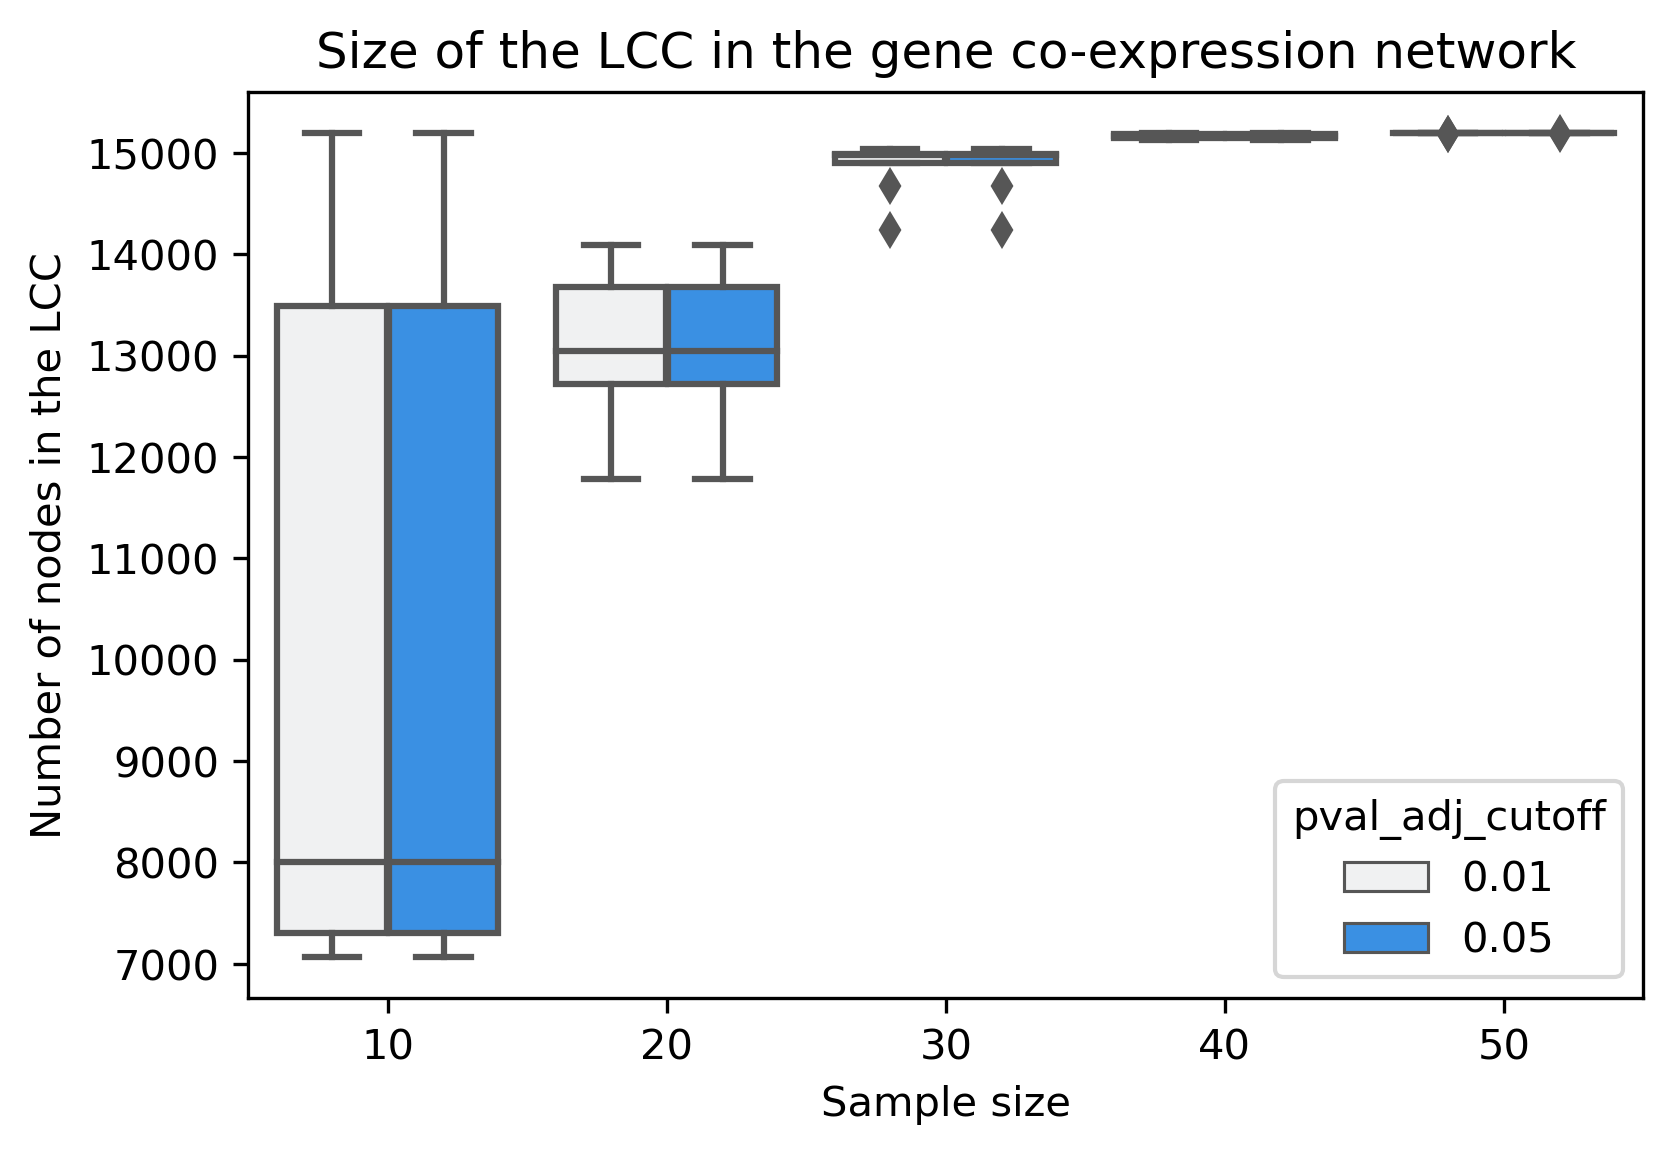

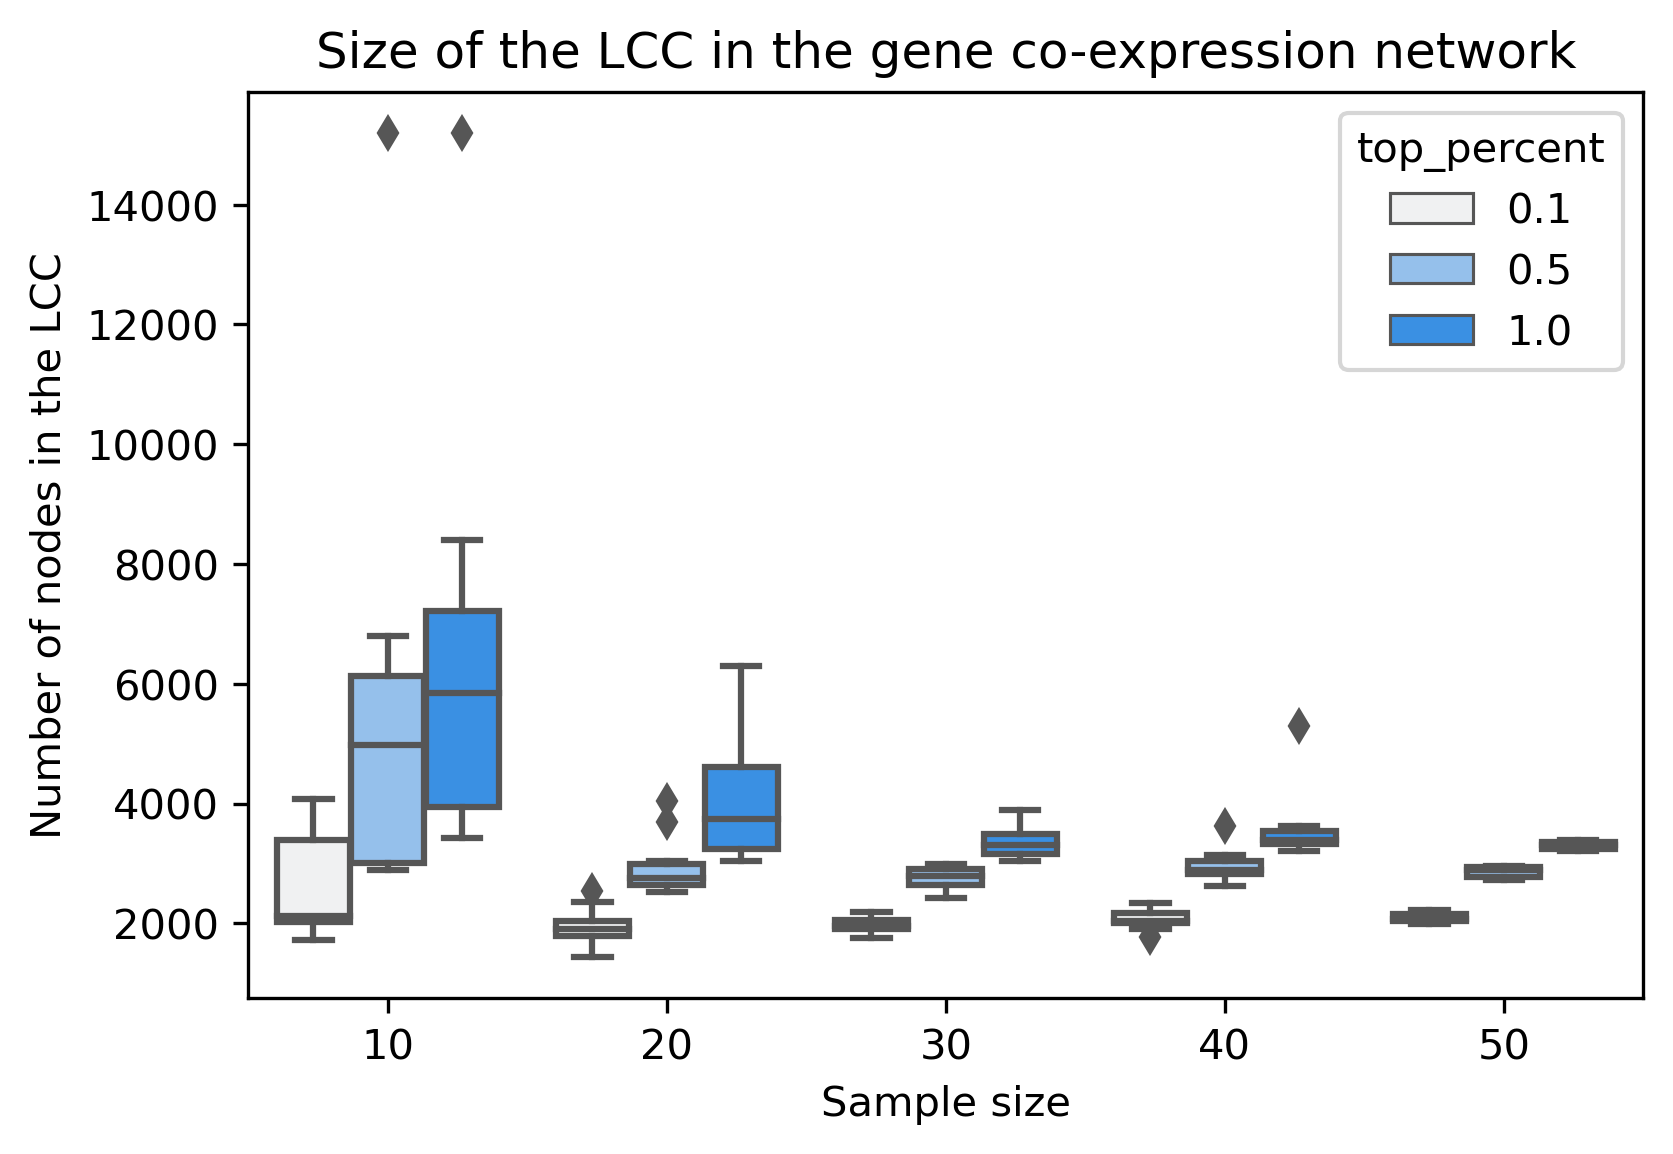

In [20]:
# Size of the LCC vs. sample size (by p-value)
fig = pylab.figure(dpi=300)
sns.boxplot(data=components_by_pval_df, x='size', y='size_lcc', hue="pval_adj_cutoff", color='dodgerblue')
plt.title('Size of the LCC in the gene co-expression network')
plt.xlabel('Sample size')
plt.ylabel('Number of nodes in the LCC')
pylab.savefig(os.path.join(plots_dir, 'LCC_size_vs_sample_size_by_pval.png'), format='png')
plt.show()

# Size of the LCC vs. sample size (by percentage)
fig = pylab.figure(dpi=300)
sns.boxplot(data=components_df, x='size', y='size_lcc', hue="top_percent", color='dodgerblue')
plt.title('Size of the LCC in the gene co-expression network')
plt.xlabel('Sample size')
plt.ylabel('Number of nodes in the LCC')
pylab.savefig(os.path.join(plots_dir, 'LCC_size_vs_sample_size_by_percent.png'), format='png')
plt.show()


## Sample size effect on reproducibility of the network

In [ ]:
#fig = pylab.figure(dpi=300)
#sns.lineplot(data=kendall_df, x="size", y="kendall", marker="o")
#plt.title('Kendall\'s W vs. sample size')
#plt.xlabel('Sample size')
#plt.ylabel('Kendall\'s W')
#pylab.savefig(os.path.join(plots_dir, 'kendall_vs_sample_size.png'), format='png')
#plt.show()

## Sample size effect on disease module identification

In [40]:
disease_df

size rep                              disease  \
0       10   1                      kidney diseases   
1       10   1                      kidney diseases   
2       10   1                 chromosome disorders   
3       10   1            diabetes mellitus, type 1   
4       10   1            diabetes mellitus, type 1   
...    ...  ..                                  ...   
45895   50  10  stomatognathic system abnormalities   
45896   50  10  stomatognathic system abnormalities   
45897   50  10            digestive system diseases   
45898   50  10                      liver cirrhosis   
45899   50  10                      liver cirrhosis   

                                           disease_class total_disease_genes  \
0      female urogenital diseases and pregnancy compl...                 188   
1                               male urogenital diseases                 188   
2      congenital, hereditary, and neonatal diseases ...                  35   
3                                 immune system diseases                 118   
4                              endocrine system diseases                 118   
...                                                  ...                 ...   
45895  congenital, hereditary, and neonatal diseases ...                  23   
45896                            stomatognathic diseases                  23   
45897                          digestive system diseases                 430   
45898        pathological conditions, signs and symptoms                  34   
45899                          digestive system diseases                  34   

      total_disease_genes_in_dataset disease_genes_in_network lcc_size  \
0                                108                      108        6   
1                                108                      108        6   
2                                 18                       18        2   
3                                 58                       58        3   
4                                 58                       58        3   
...                              ...                      ...      ...   
45895                              8                        8        4   
45896                              8                        8        4   
45897                            280                      280      280   
45898                             24                       24       23   
45899                             24                       24       23   

       pval_adj_cutoff  
0                 0.01  
1                 0.01  
2                 0.01  
3                 0.01  
4                 0.01  
...                ...  
45895             0.05  
45896             0.05  
45897             0.05  
45898             0.05  
45899             0.05  

[45900 rows x 9 columns]

In [37]:
# Select several disease classes
disease_info_df = disease_df[["disease", "disease_class", "total_disease_genes_in_dataset"]].drop_duplicates().reset_index(drop=True).sort_values(by=['disease_class'])
disease_info_df.to_csv(os.path.join(output_dir, 'disease_info_in_scipher_dataset.txt'))
disease_info_df


disease  \
212                 intellectual disability   
263          neurobehavioral manifestations   
75             cardiovascular abnormalities   
200             arterial occlusive diseases   
250  cardiomyopathy, hypertrophic, familial   
..                                      ...   
159                         behcet syndrome   
323                          mouth diseases   
153                 stomatognathic diseases   
158                         behcet syndrome   
454     stomatognathic system abnormalities   

                           disease_class total_disease_genes_in_dataset  
212     behavior and behavior mechanisms                             77  
263     behavior and behavior mechanisms                             79  
75               cardiovascular diseases                             42  
200              cardiovascular diseases                             35  
250              cardiovascular diseases                              7  
..                                   ...                            ...  
159  skin and connective tissue diseases                              7  
323              stomatognathic diseases                             14  
153              stomatognathic diseases                             22  
158              stomatognathic diseases                              7  
454              stomatognathic diseases                              8  

[459 rows x 3 columns]

In [30]:
disease_class = "nutritional and metabolic diseases"
pval_adj_cutoff = 0.01
top_percent = 0.1
disease_class_info_df = disease_info_df[disease_info_df["disease_class"] == disease_class].drop_duplicates().reset_index(drop=True)
#print(disease_class_df)
top5 = pd.to_numeric(disease_class_info_df['total_disease_genes_in_dataset']).nlargest(5)
#print(top5)
top5_df = disease_class_info_df.loc[top5.index,]
diseases = top5_df['disease'].to_list()
disease_class_selection_df = disease_df[(disease_df['disease'].isin(diseases)) & (disease_df['disease_class'] == disease_class) & (disease_df['pval_adj_cutoff'] == pval_adj_cutoff) & (disease_df['top_percent'] == top_percent)].reset_index(drop=True)
disease_class_selection_df['percent_disease_genes_in_network'] = disease_class_selection_df['disease_genes_in_network']/disease_class_selection_df['total_disease_genes_in_dataset']*100
disease_class_selection_df['percent_disease_genes_in_lcc'] = disease_class_selection_df['lcc_size']/disease_class_selection_df['total_disease_genes_in_dataset']*100

disease_class_selection_df


size rep                             disease  \
0     10   1  nutritional and metabolic diseases   
1     10   1           metabolism, inborn errors   
2     10   1                   diabetes mellitus   
3     10   1        glucose metabolism disorders   
4     10   1                  metabolic diseases   
..   ...  ..                                 ...   
245   50  10  nutritional and metabolic diseases   
246   50  10           metabolism, inborn errors   
247   50  10                   diabetes mellitus   
248   50  10        glucose metabolism disorders   
249   50  10                  metabolic diseases   

                          disease_class total_disease_genes  \
0    nutritional and metabolic diseases                 742   
1    nutritional and metabolic diseases                 329   
2    nutritional and metabolic diseases                 226   
3    nutritional and metabolic diseases                 256   
4    nutritional and metabolic diseases                 721   
..                                  ...                 ...   
245  nutritional and metabolic diseases                 742   
246  nutritional and metabolic diseases                 329   
247  nutritional and metabolic diseases                 226   
248  nutritional and metabolic diseases                 256   
249  nutritional and metabolic diseases                 721   

    total_disease_genes_in_dataset disease_genes_in_network lcc_size  \
0                              487                       62       42   
1                              237                       25        6   
2                              124                       14        3   
3                              132                       14        3   
4                              480                       62       42   
..                             ...                      ...      ...   
245                            487                       55       28   
246                            237                       23       10   
247                            124                       10        1   
248                            132                       12        1   
249                            480                       54       28   

     pval_adj_cutoff  top_percent percent_disease_genes_in_network  \
0               0.01          0.1                        12.731006   
1               0.01          0.1                        10.548523   
2               0.01          0.1                        11.290323   
3               0.01          0.1                        10.606061   
4               0.01          0.1                        12.916667   
..               ...          ...                              ...   
245             0.01          0.1                        11.293634   
246             0.01          0.1                         9.704641   
247             0.01          0.1                         8.064516   
248             0.01          0.1                         9.090909   
249             0.01          0.1                            11.25   

    percent_disease_genes_in_lcc  
0                        8.62423  
1                       2.531646  
2                       2.419355  
3                       2.272727  
4                           8.75  
..                           ...  
245                     5.749487  
246                     4.219409  
247                     0.806452  
248                     0.757576  
249                     5.833333  

[250 rows x 12 columns]

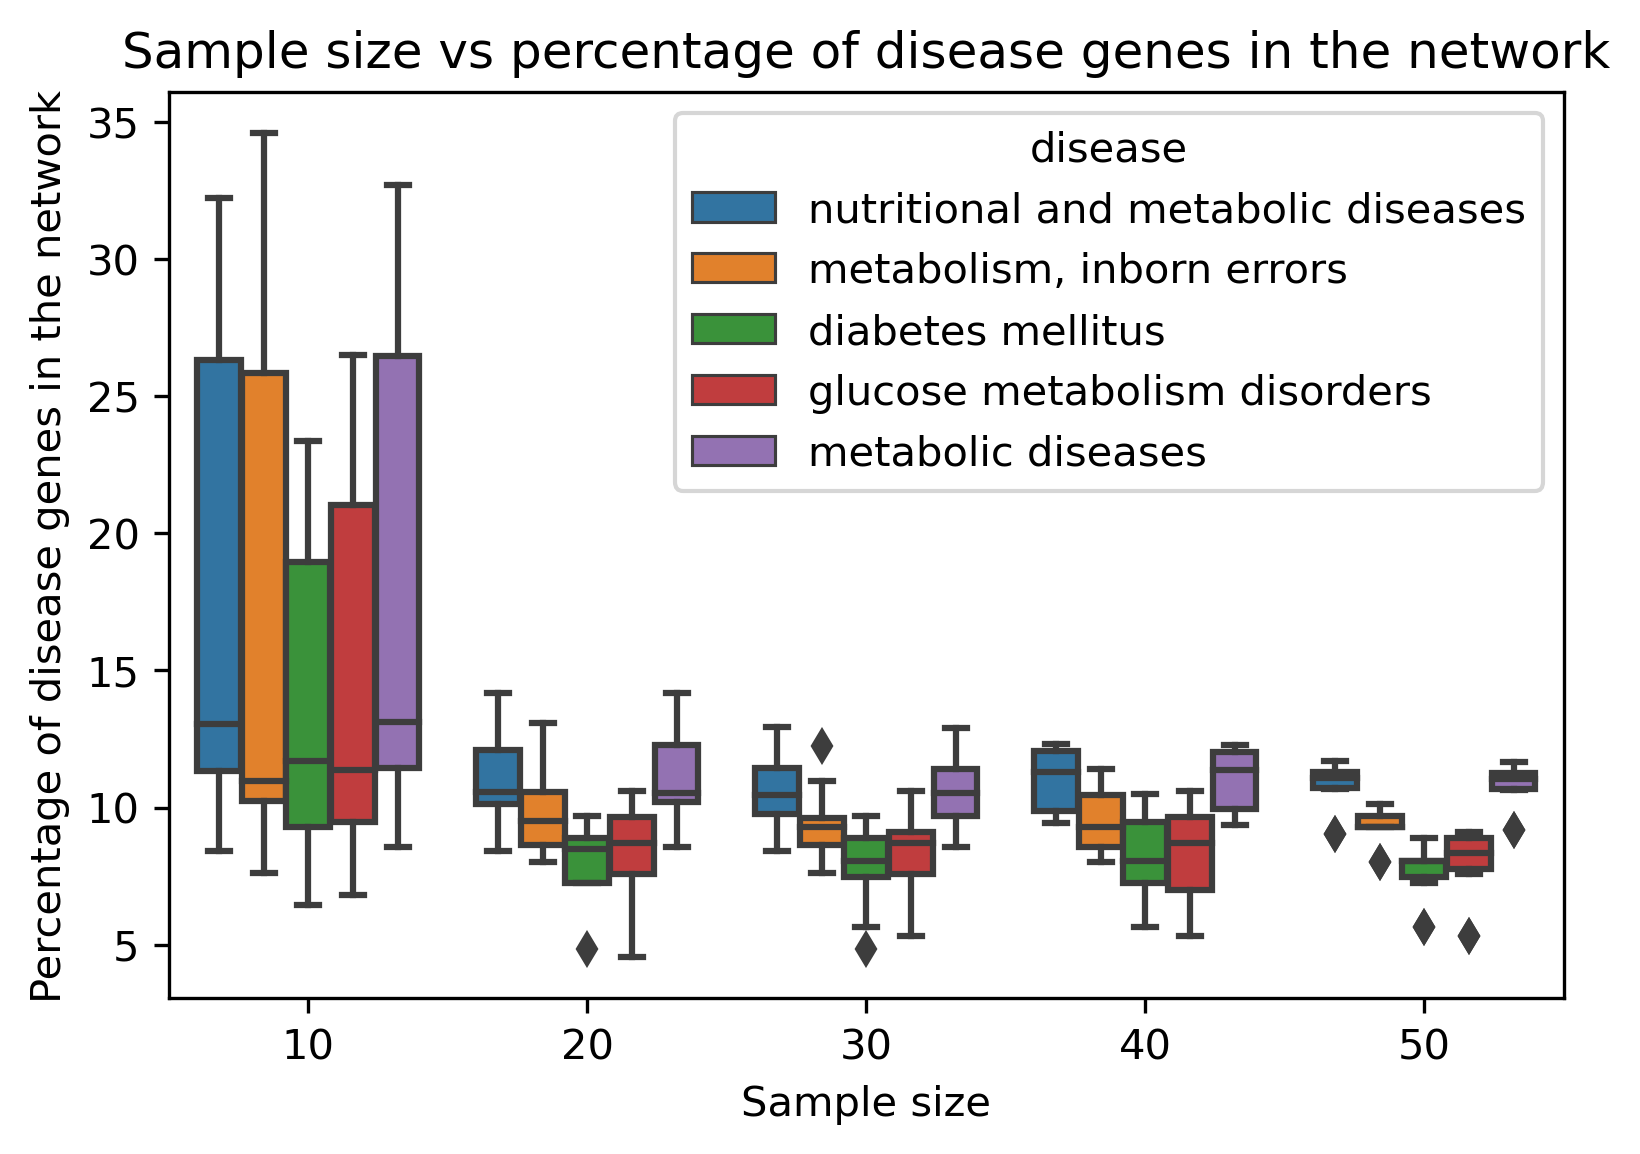

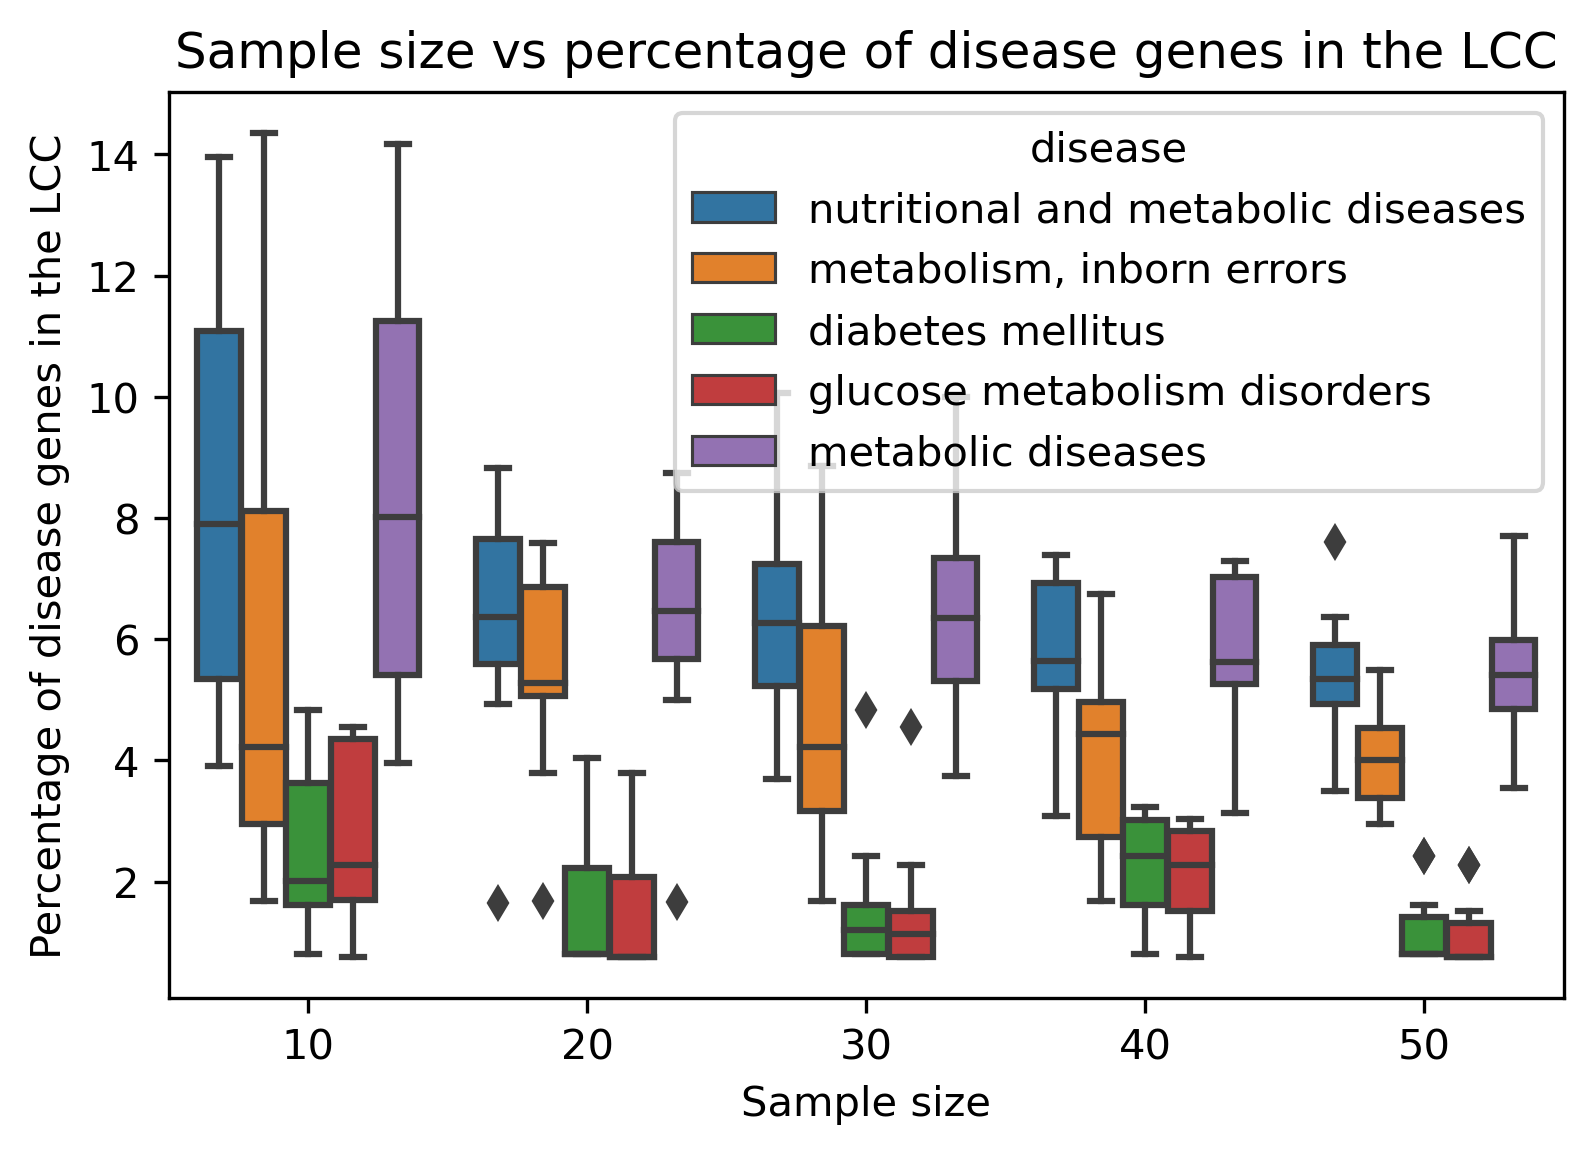

In [33]:
fig = pylab.figure(dpi=300)
sns.boxplot(data=disease_class_selection_df, x='size', y='percent_disease_genes_in_network', hue='disease')
plt.title('Sample size vs percentage of disease genes in the network')
plt.xlabel('Sample size')
plt.ylabel('Percentage of disease genes in the network')
pylab.savefig(os.path.join(plots_dir, 'disease_genes_in_network_vs_sample_size_pval_{}_top_{}.png'.format(pval_adj_cutoff, top_percent)), format='png')
plt.show()
fig = pylab.figure(dpi=300)
sns.boxplot(data=disease_class_selection_df, x='size', y='percent_disease_genes_in_lcc', hue='disease')
plt.title('Sample size vs percentage of disease genes in the LCC')
plt.xlabel('Sample size')
plt.ylabel('Percentage of disease genes in the LCC')
pylab.savefig(os.path.join(plots_dir, 'disease_genes_in_network_vs_sample_size_pval_{}_top_{}.png'.format(pval_adj_cutoff, top_percent)), format='png')
plt.show()


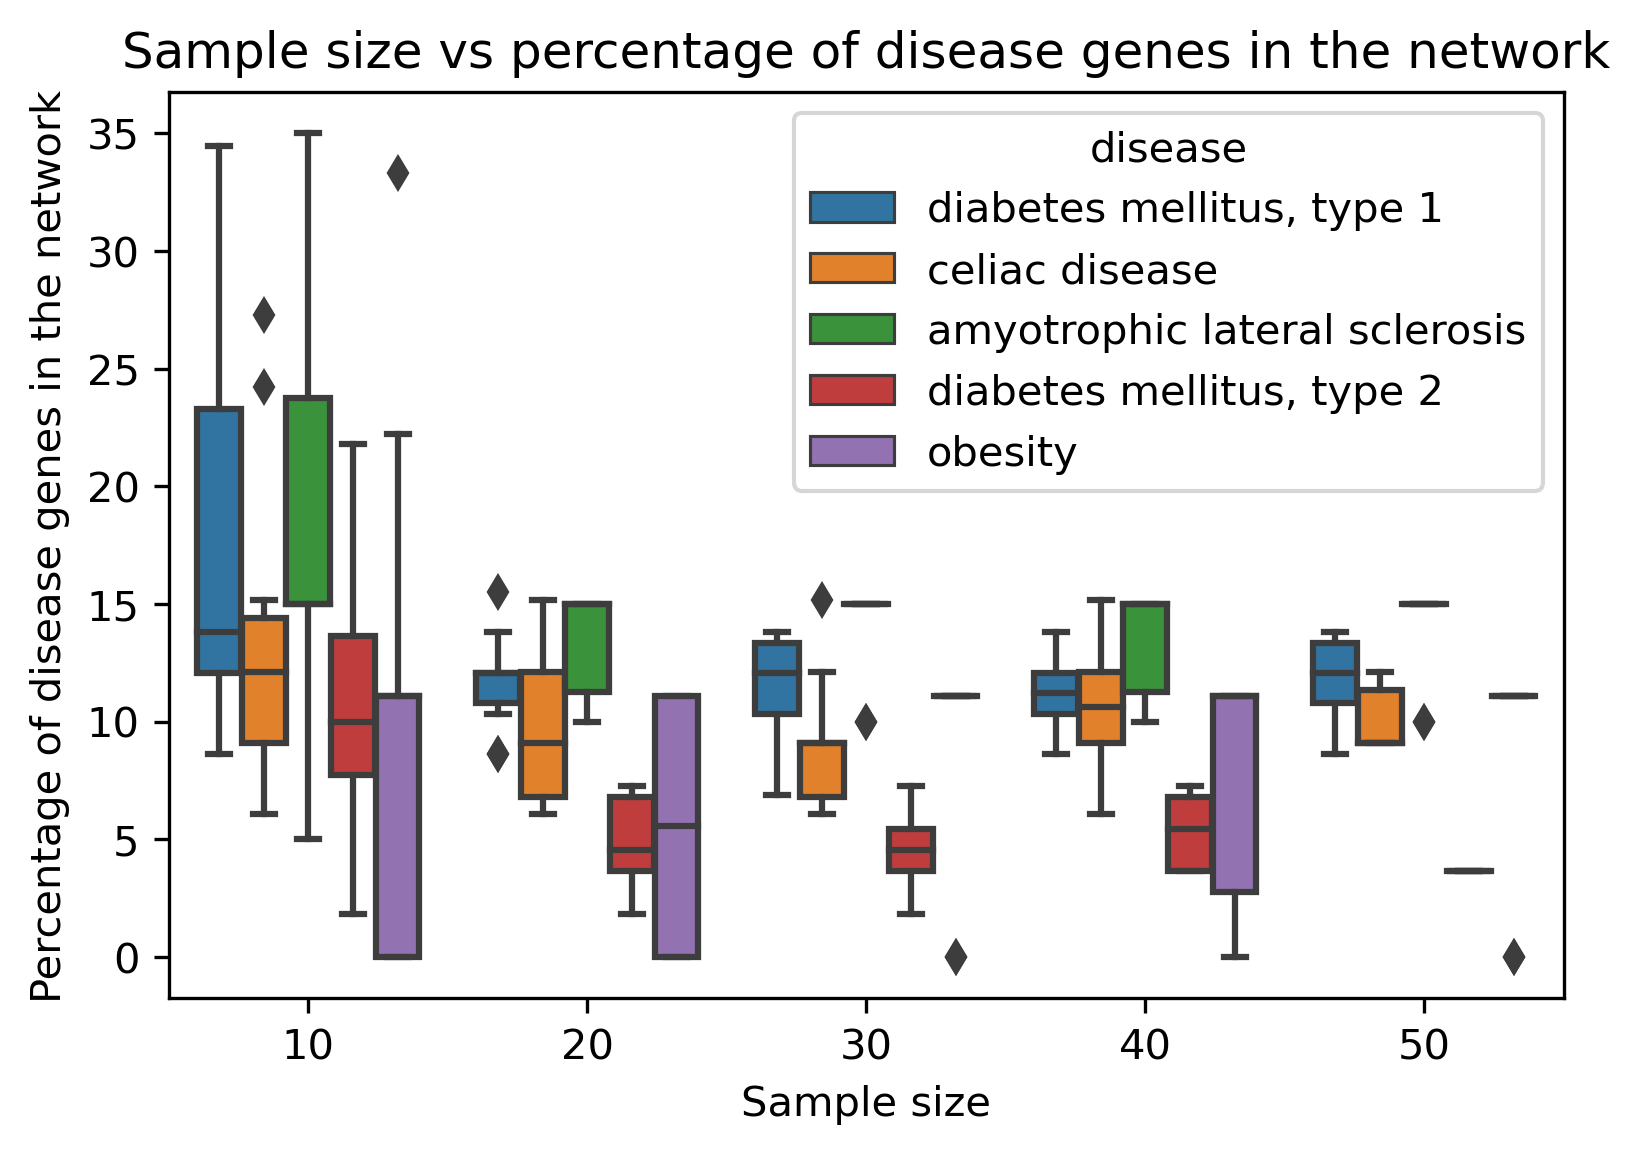

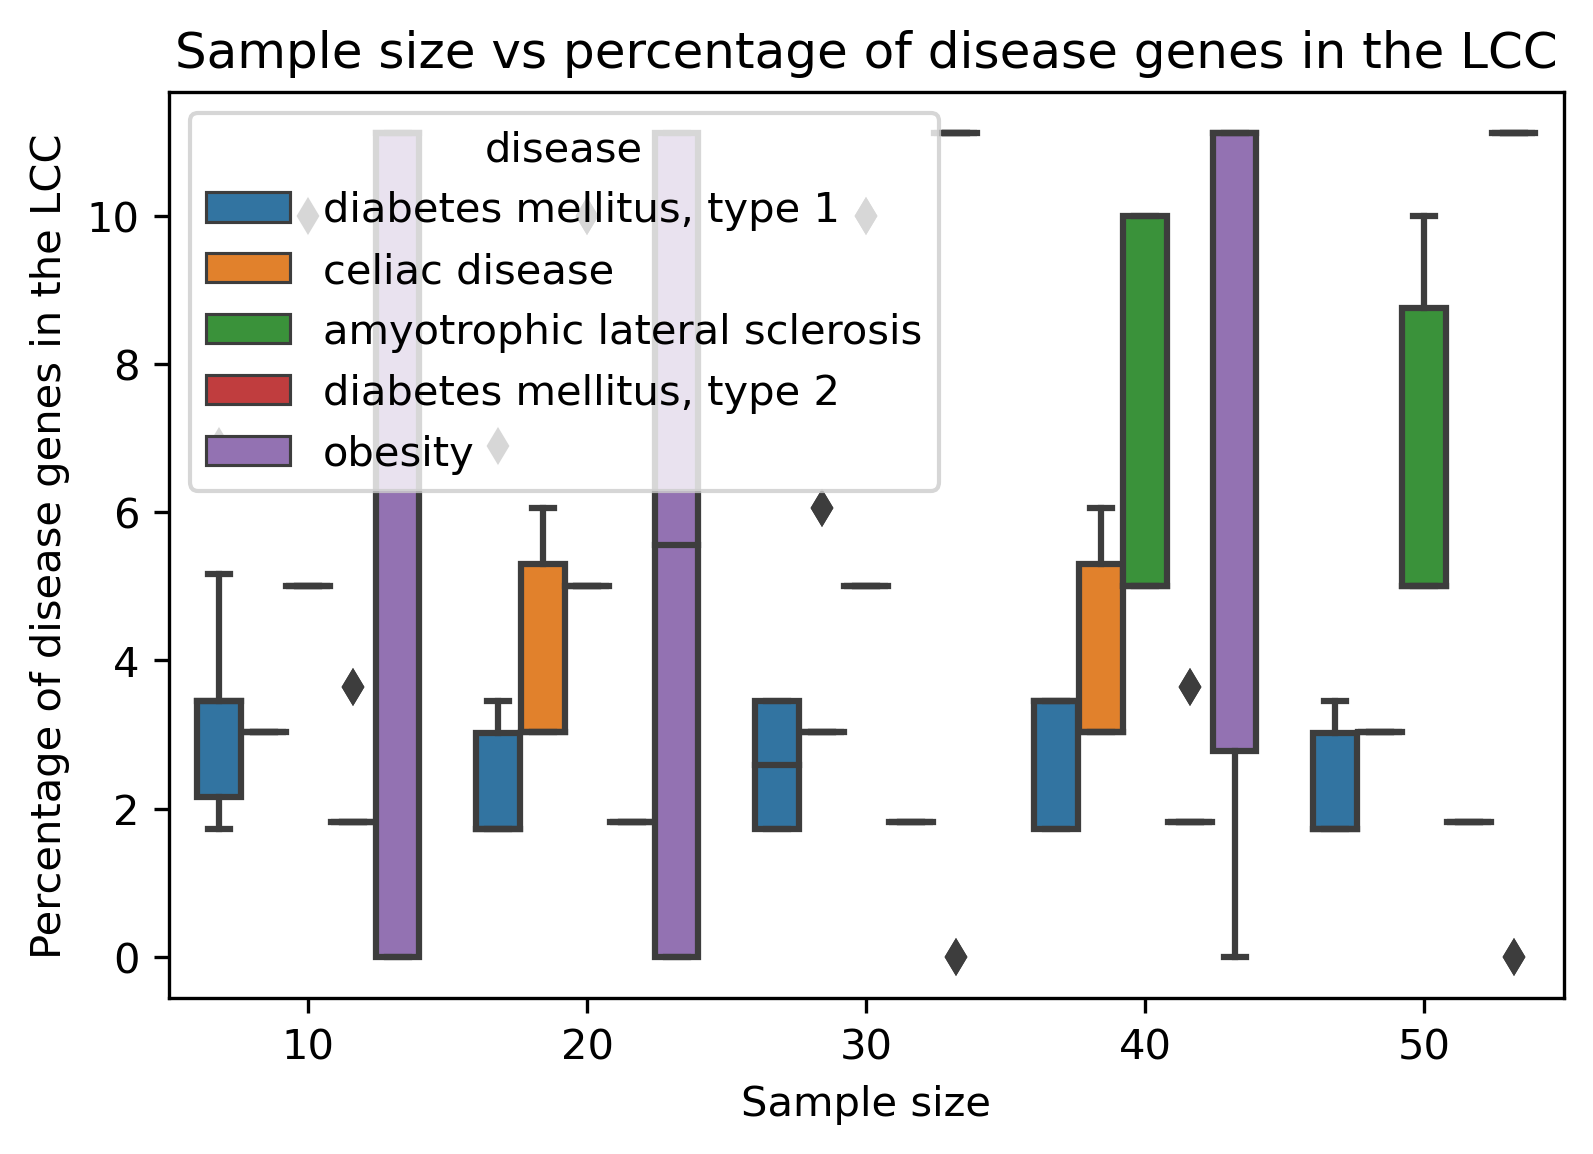

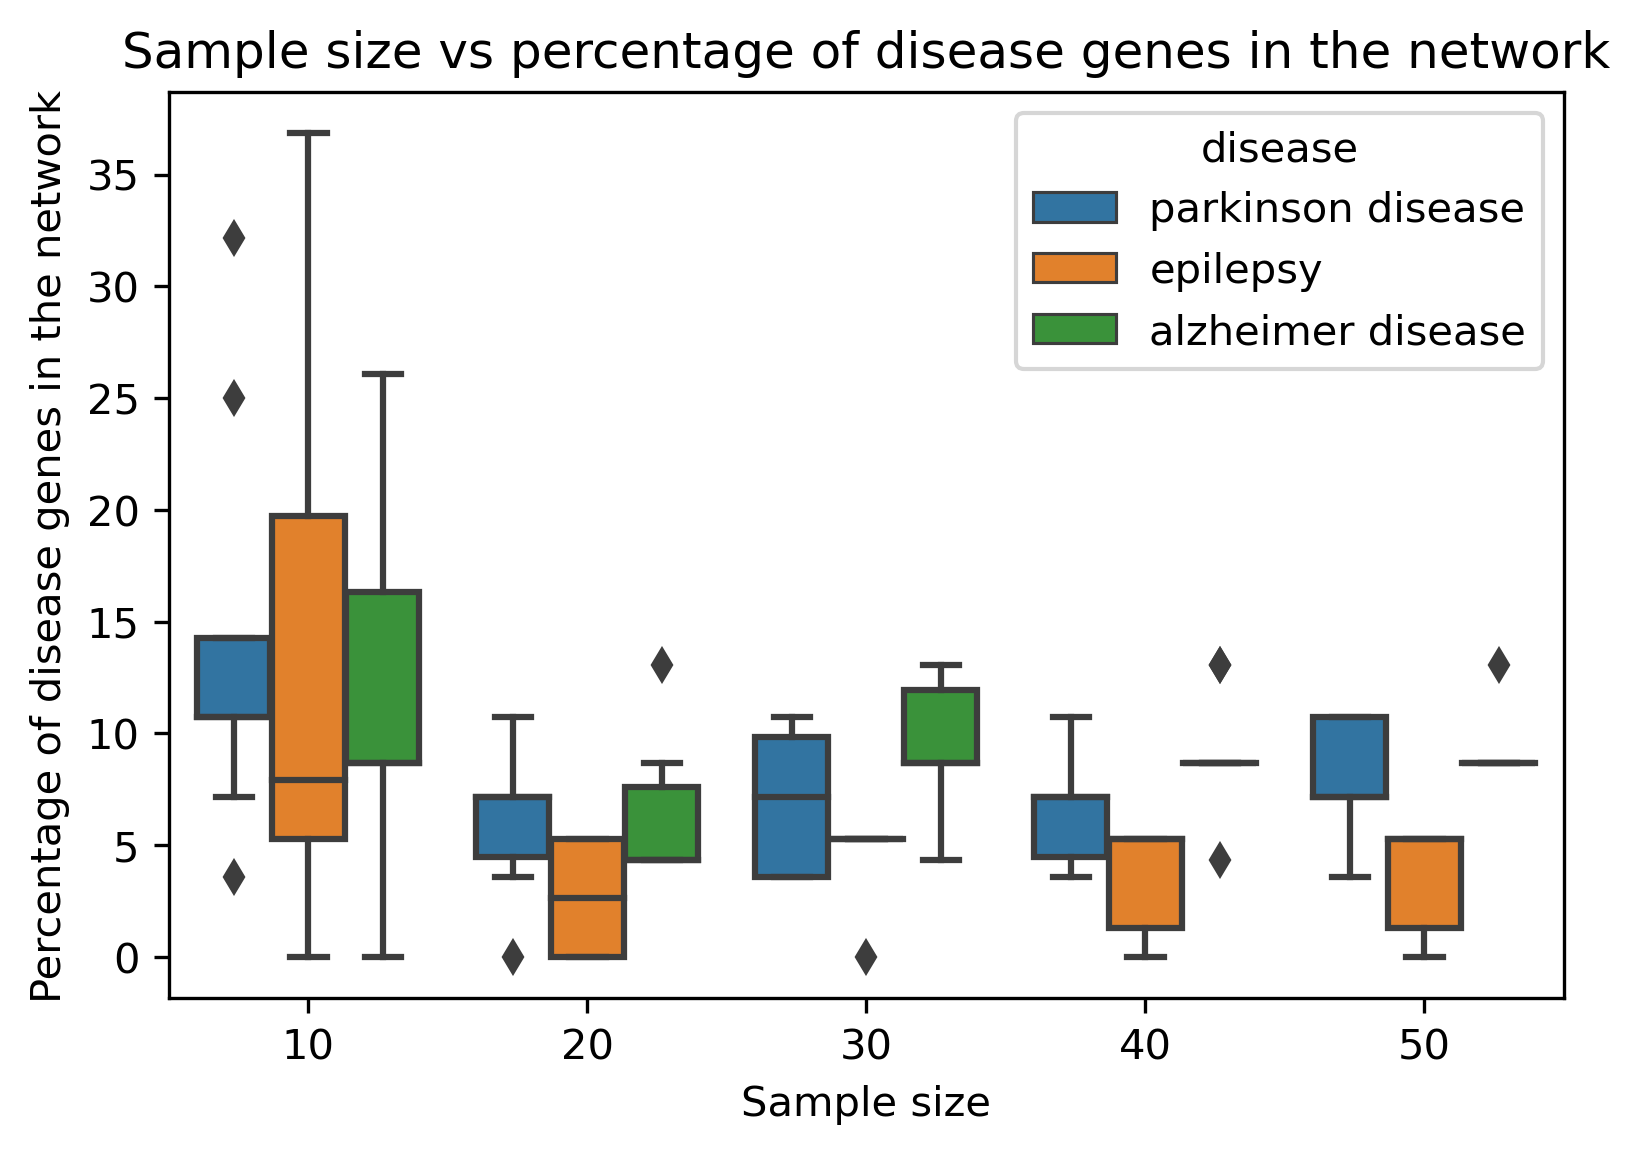

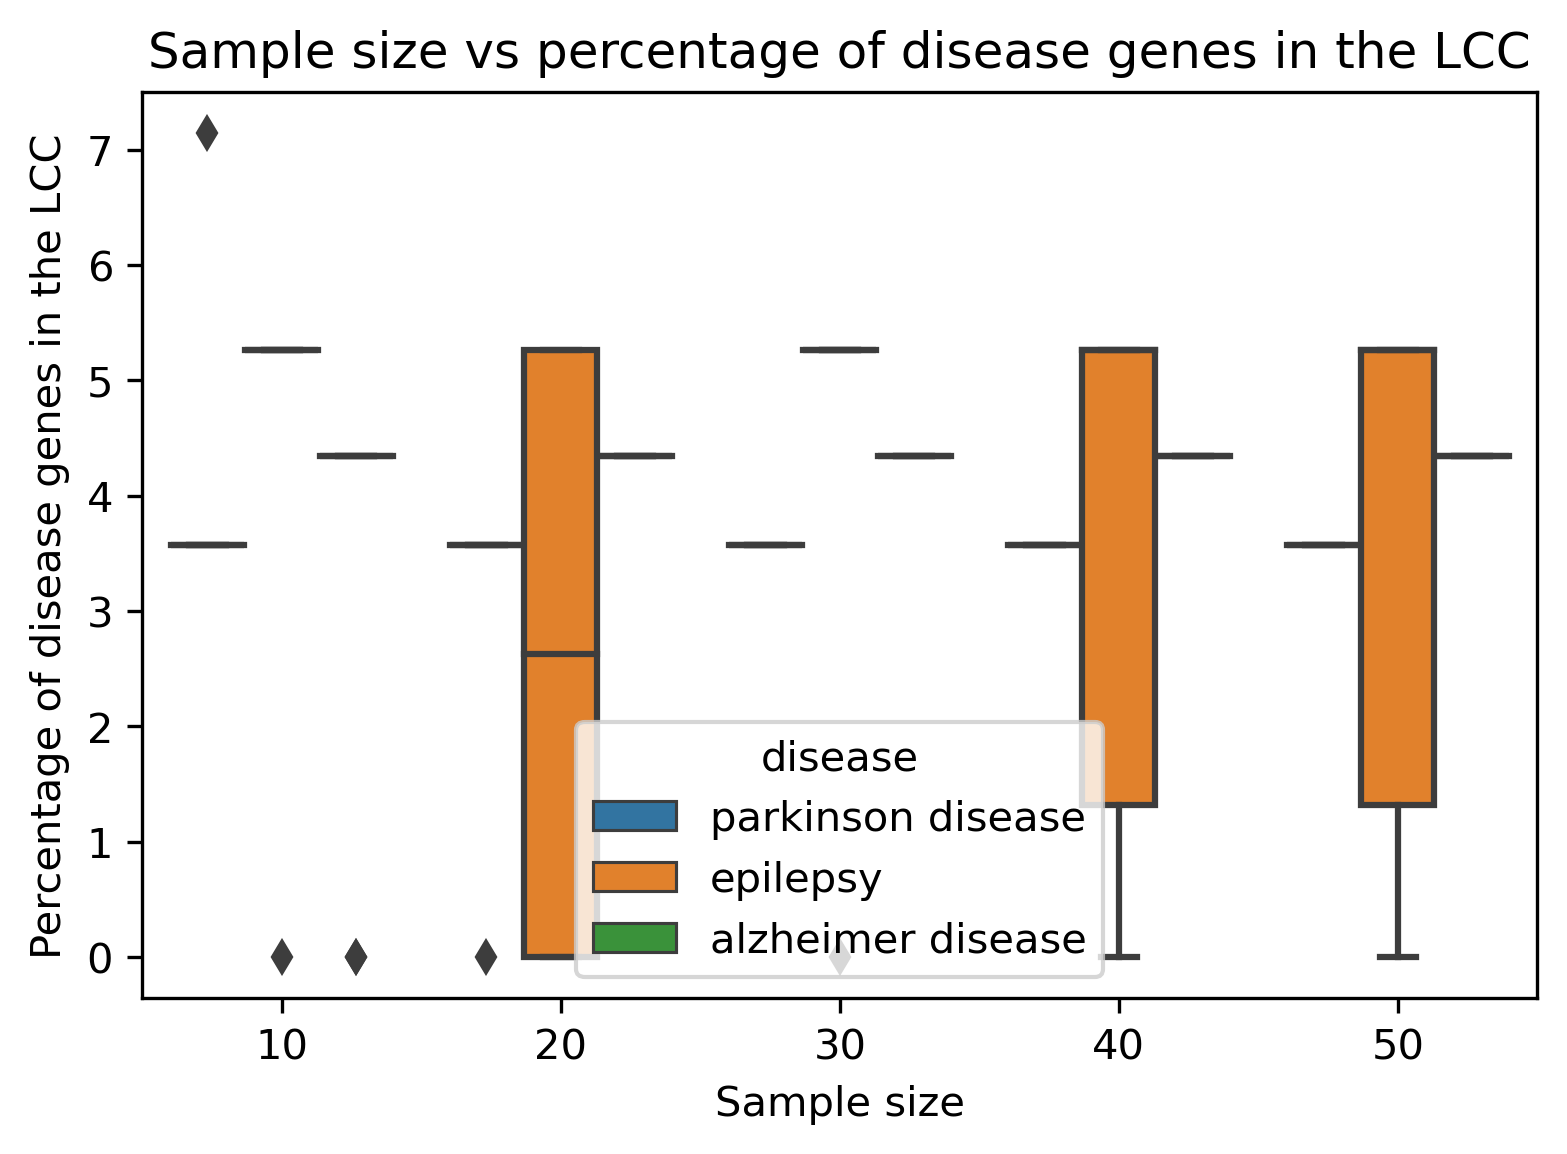

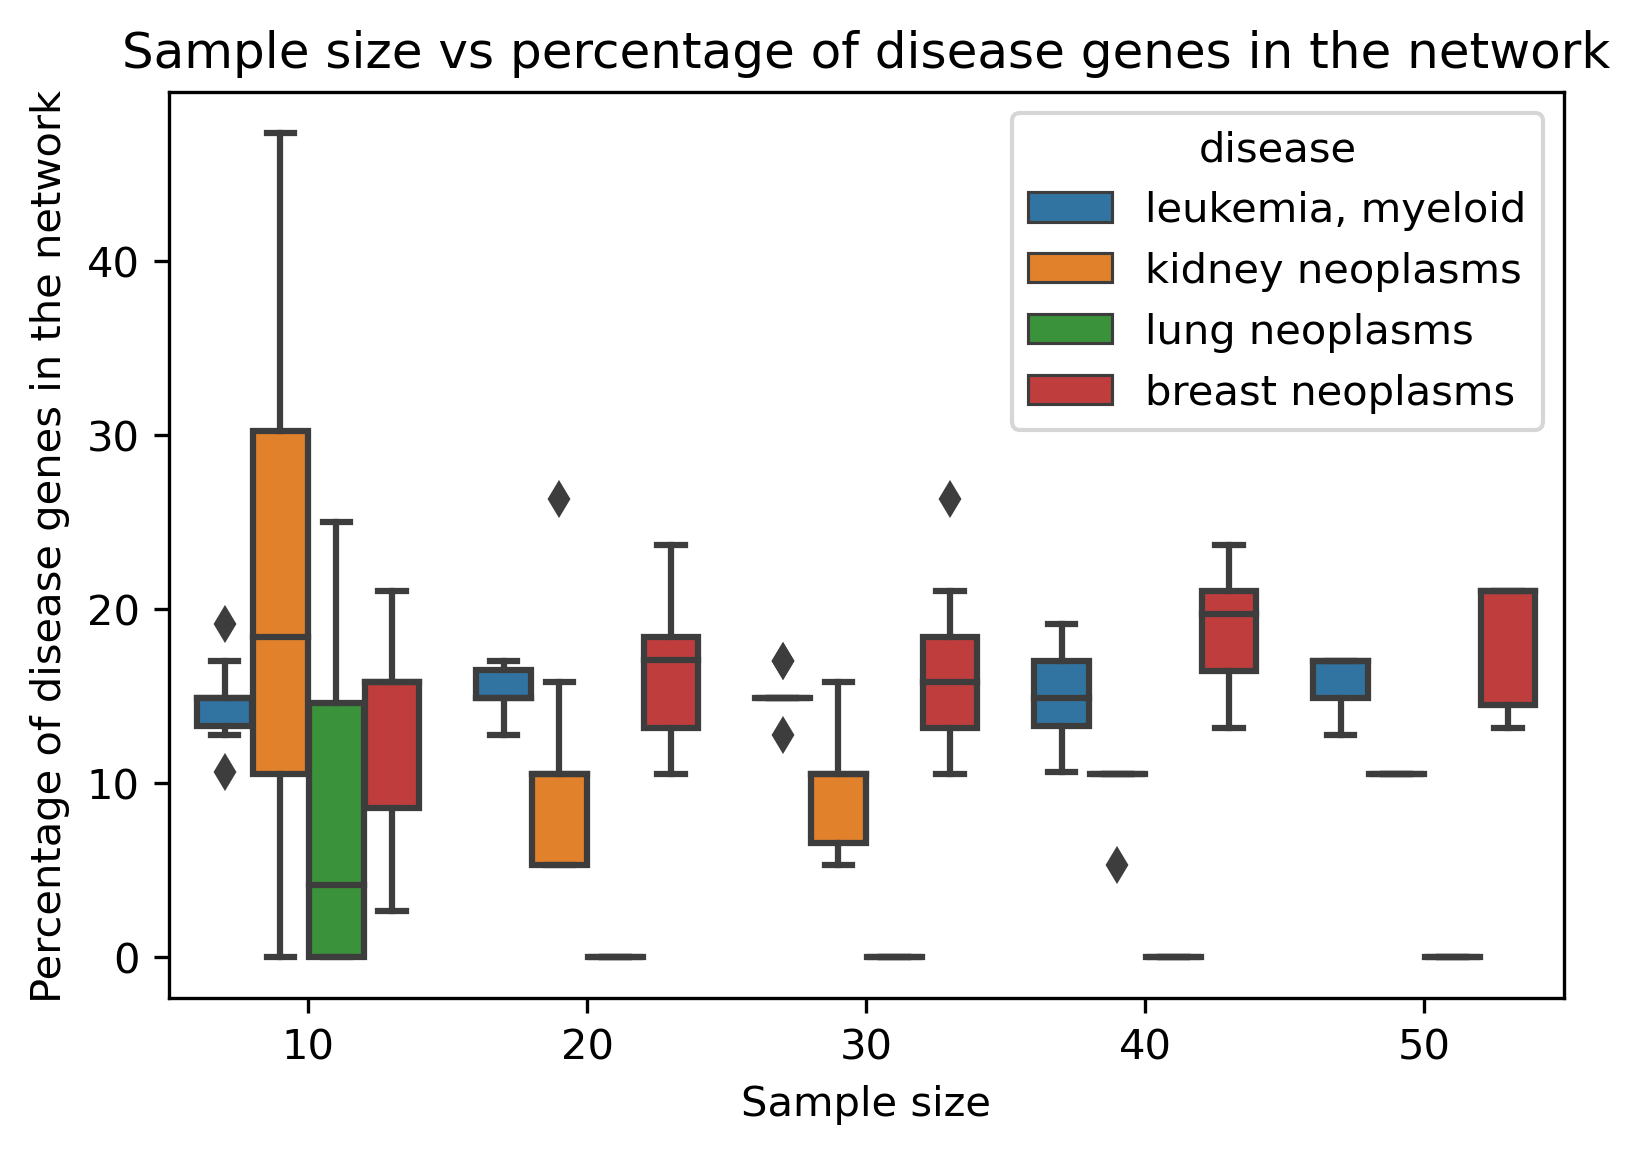

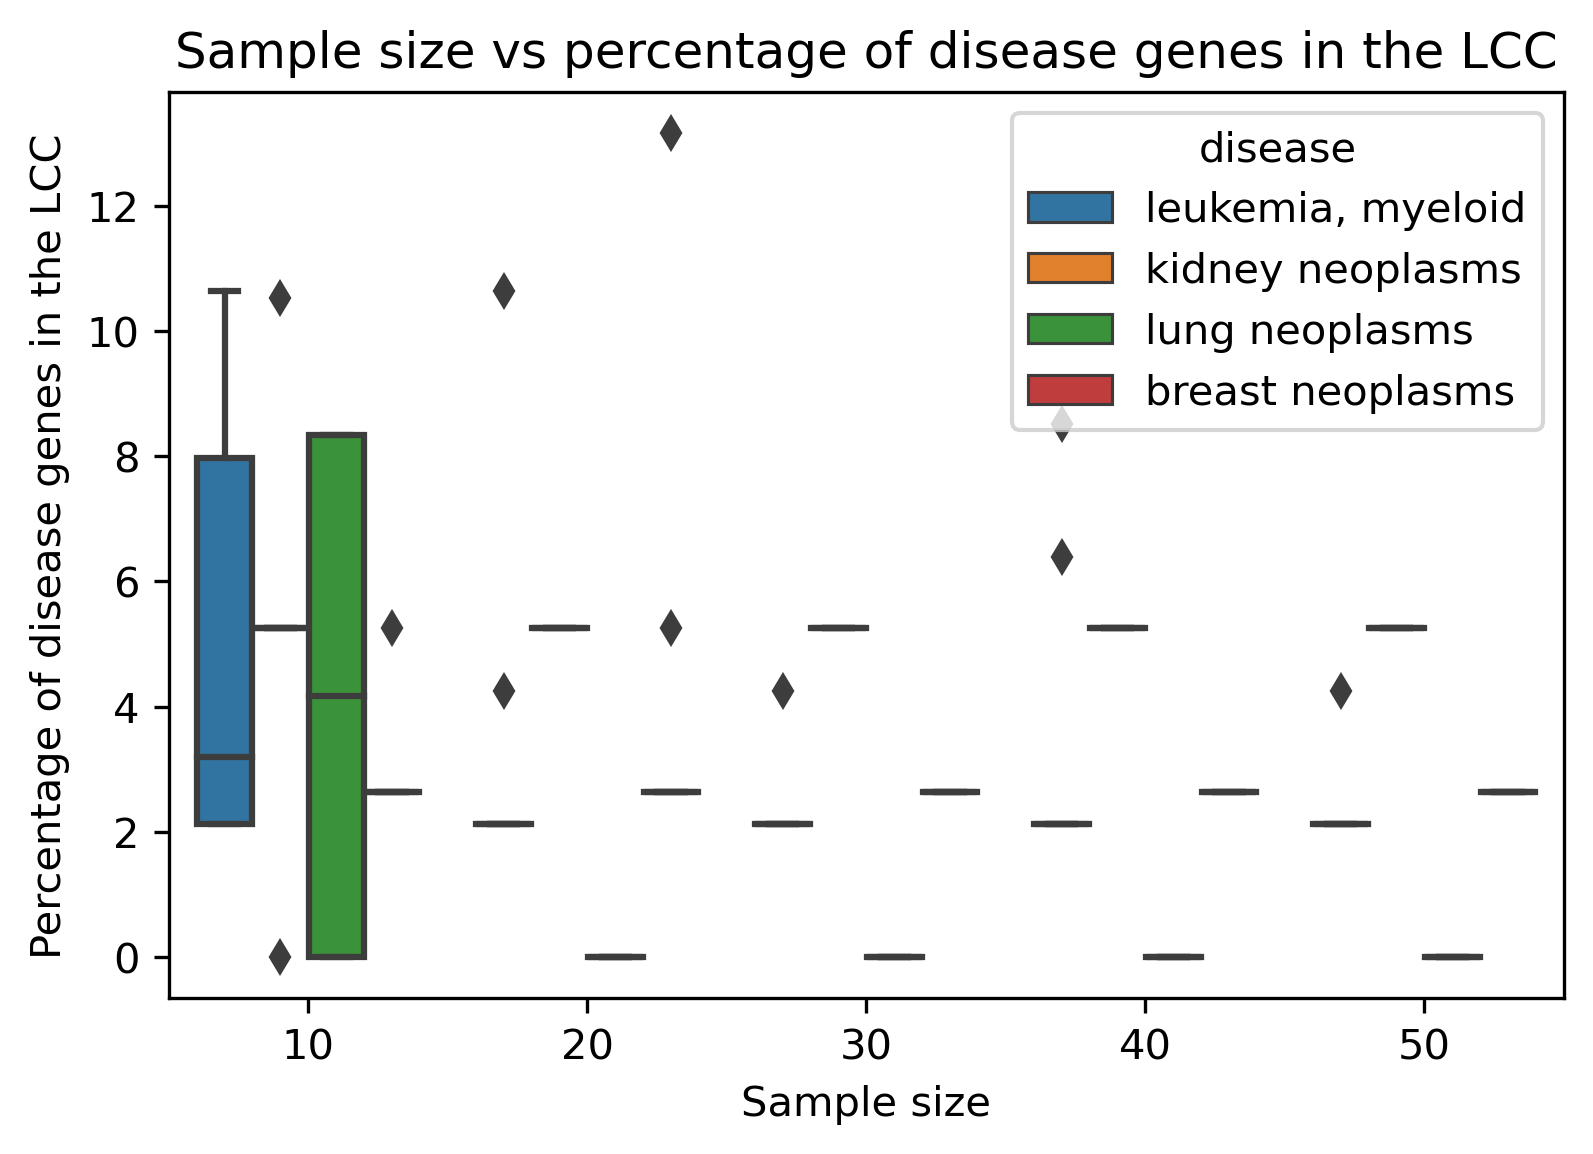

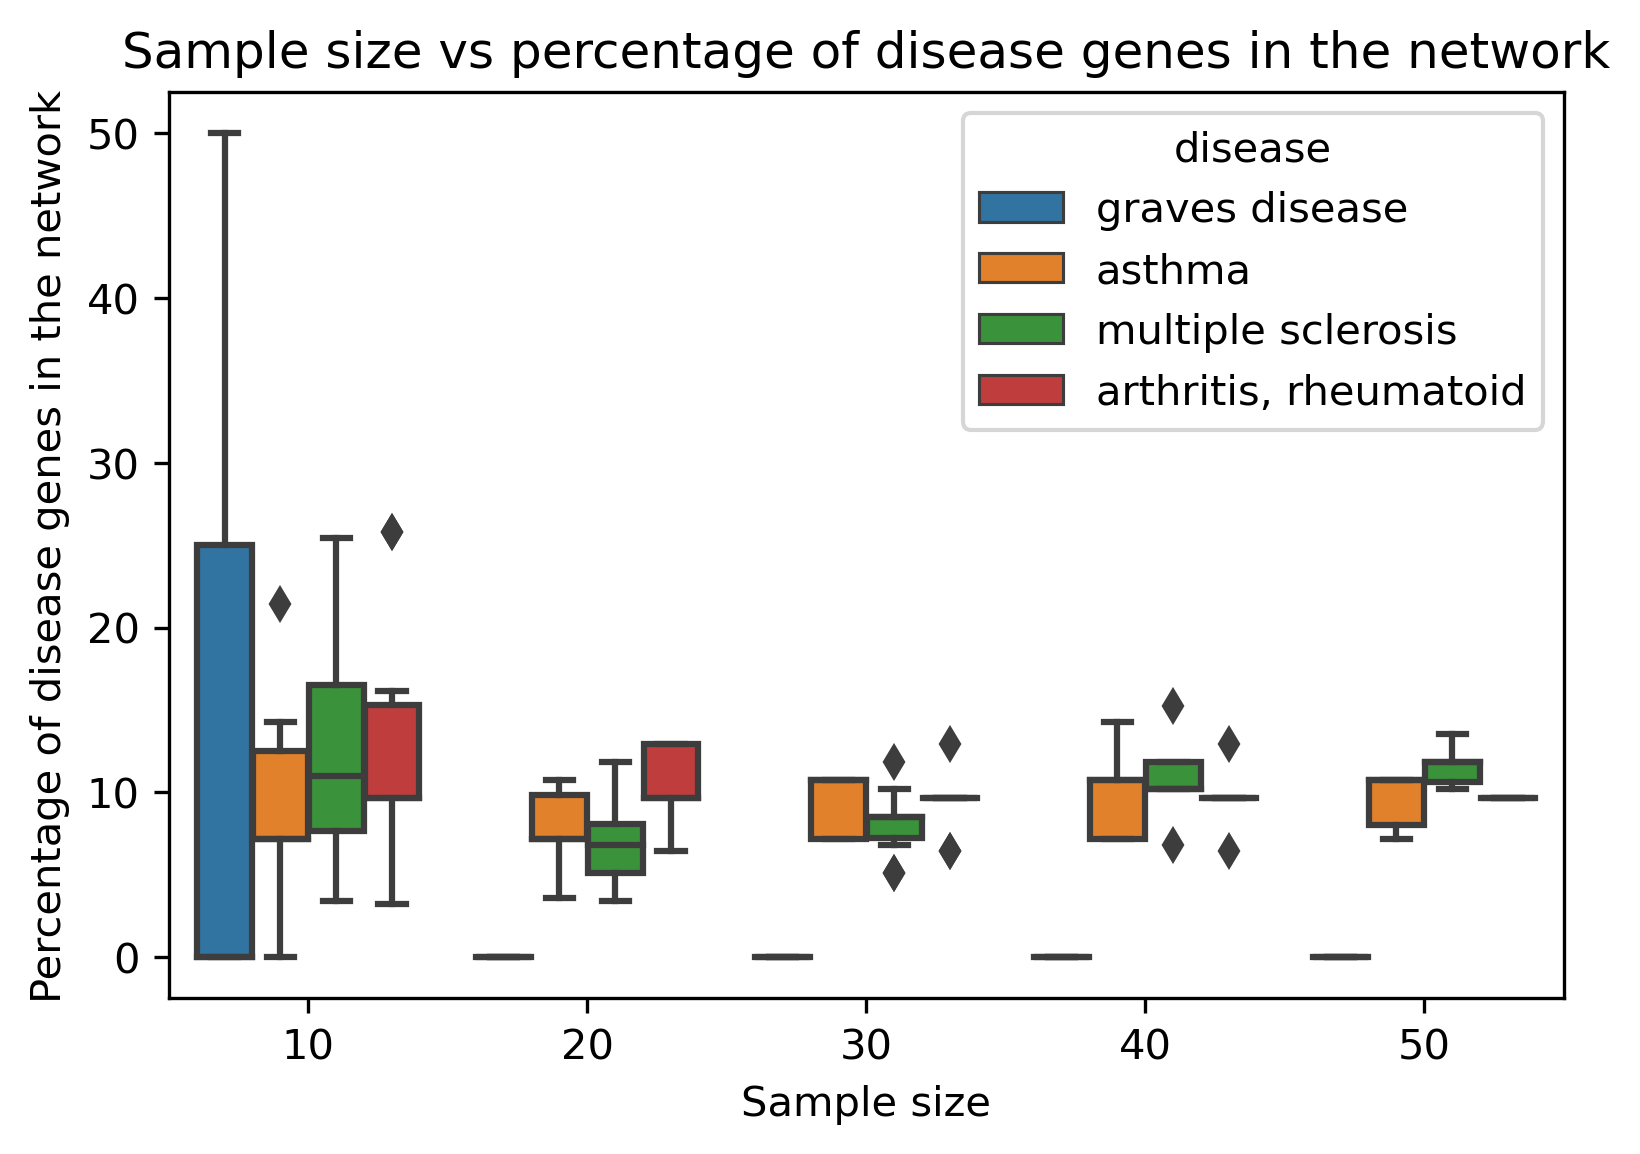

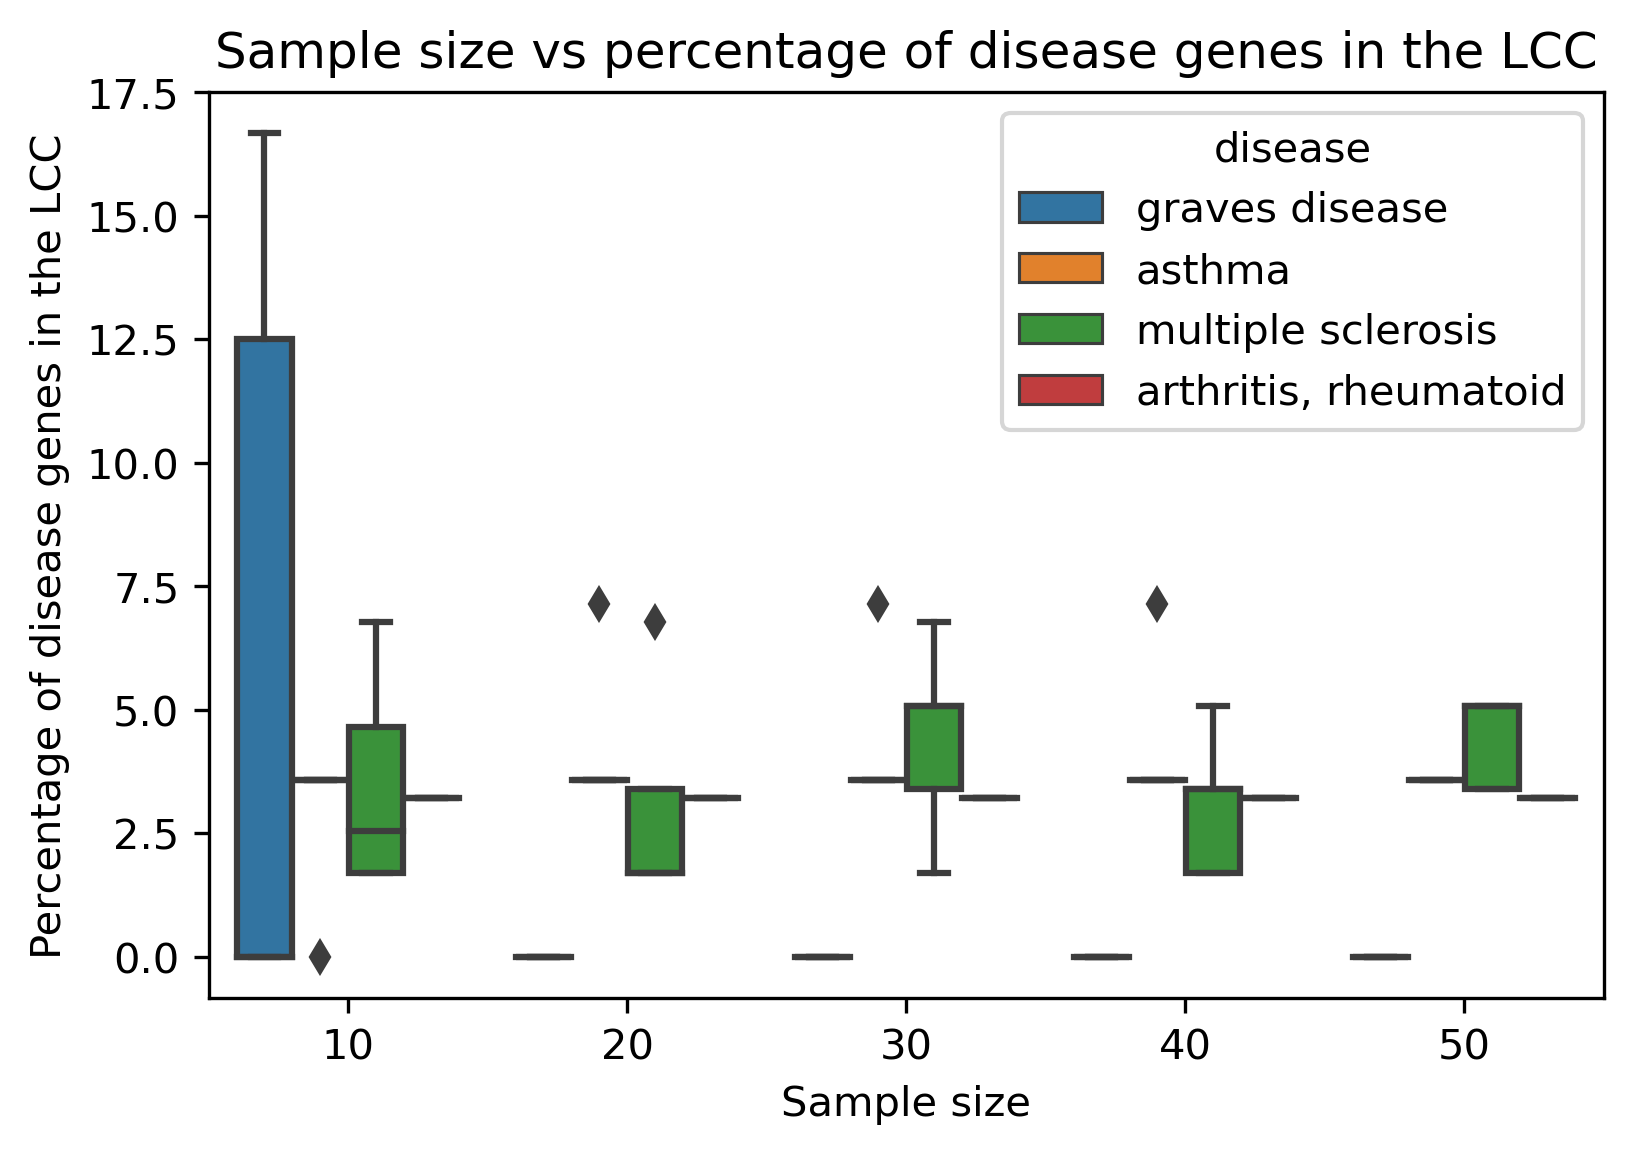

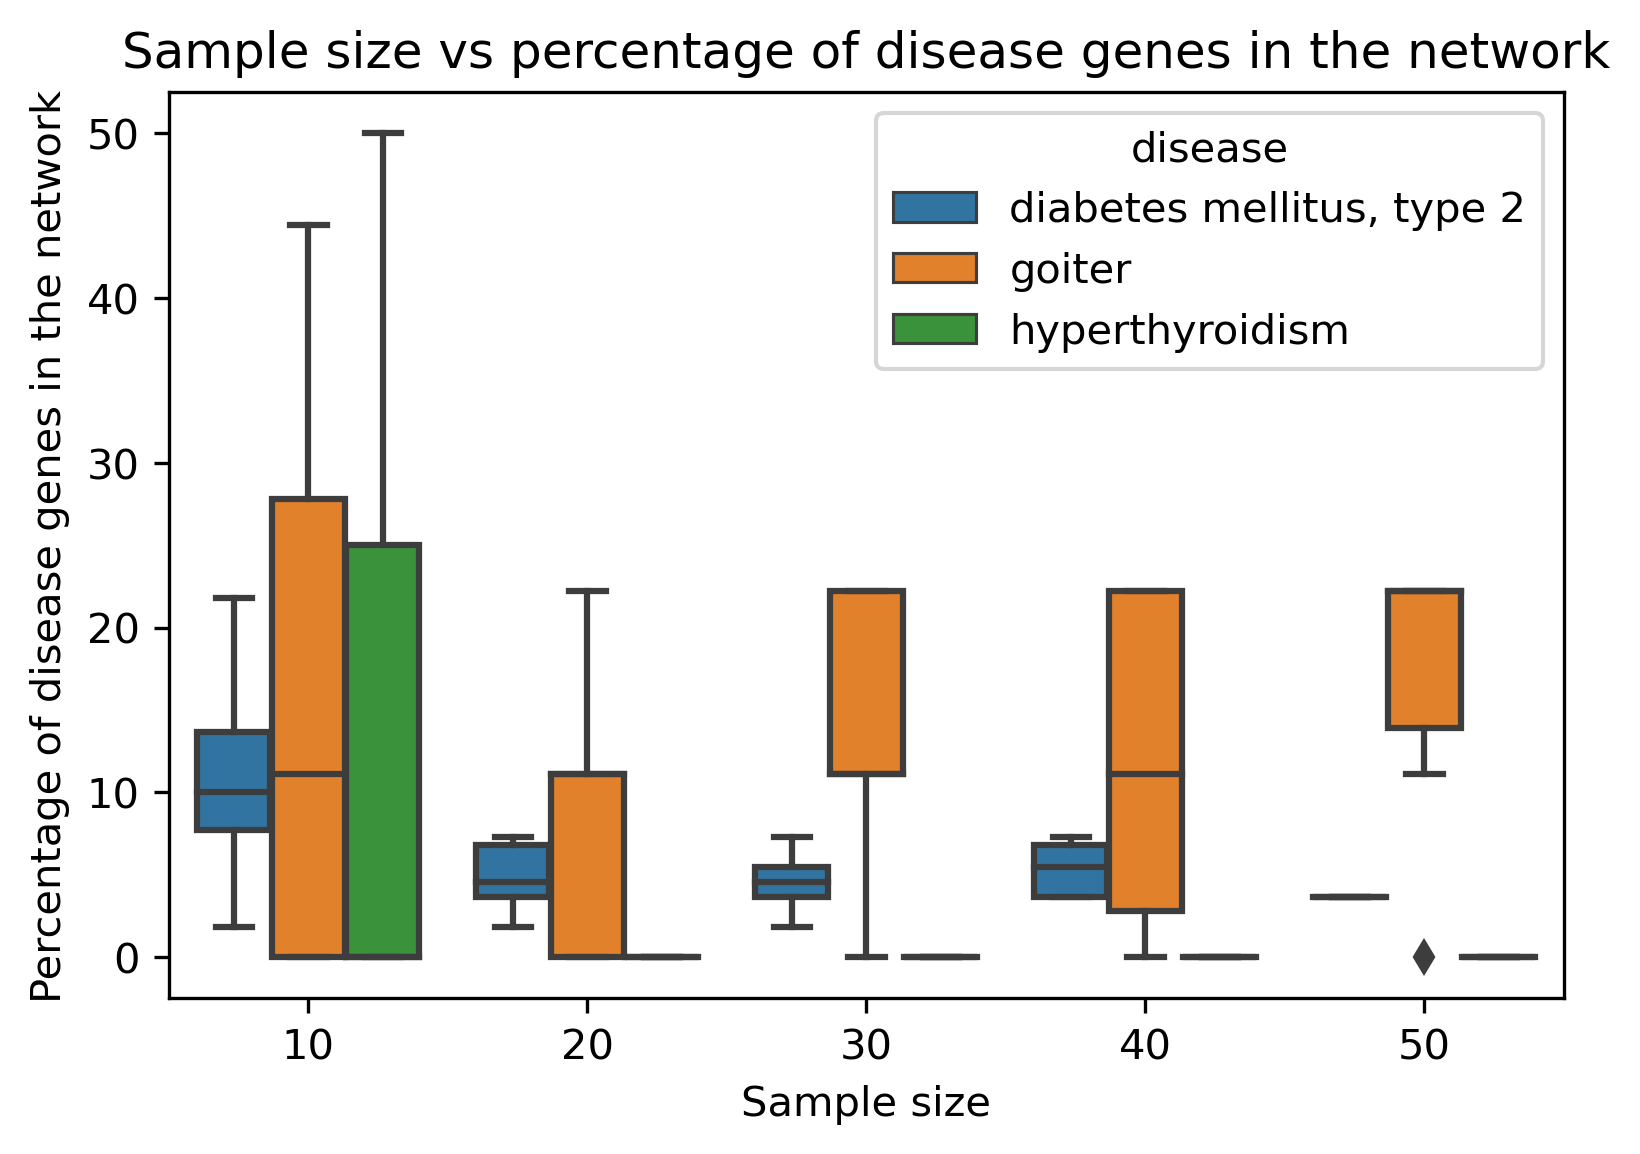

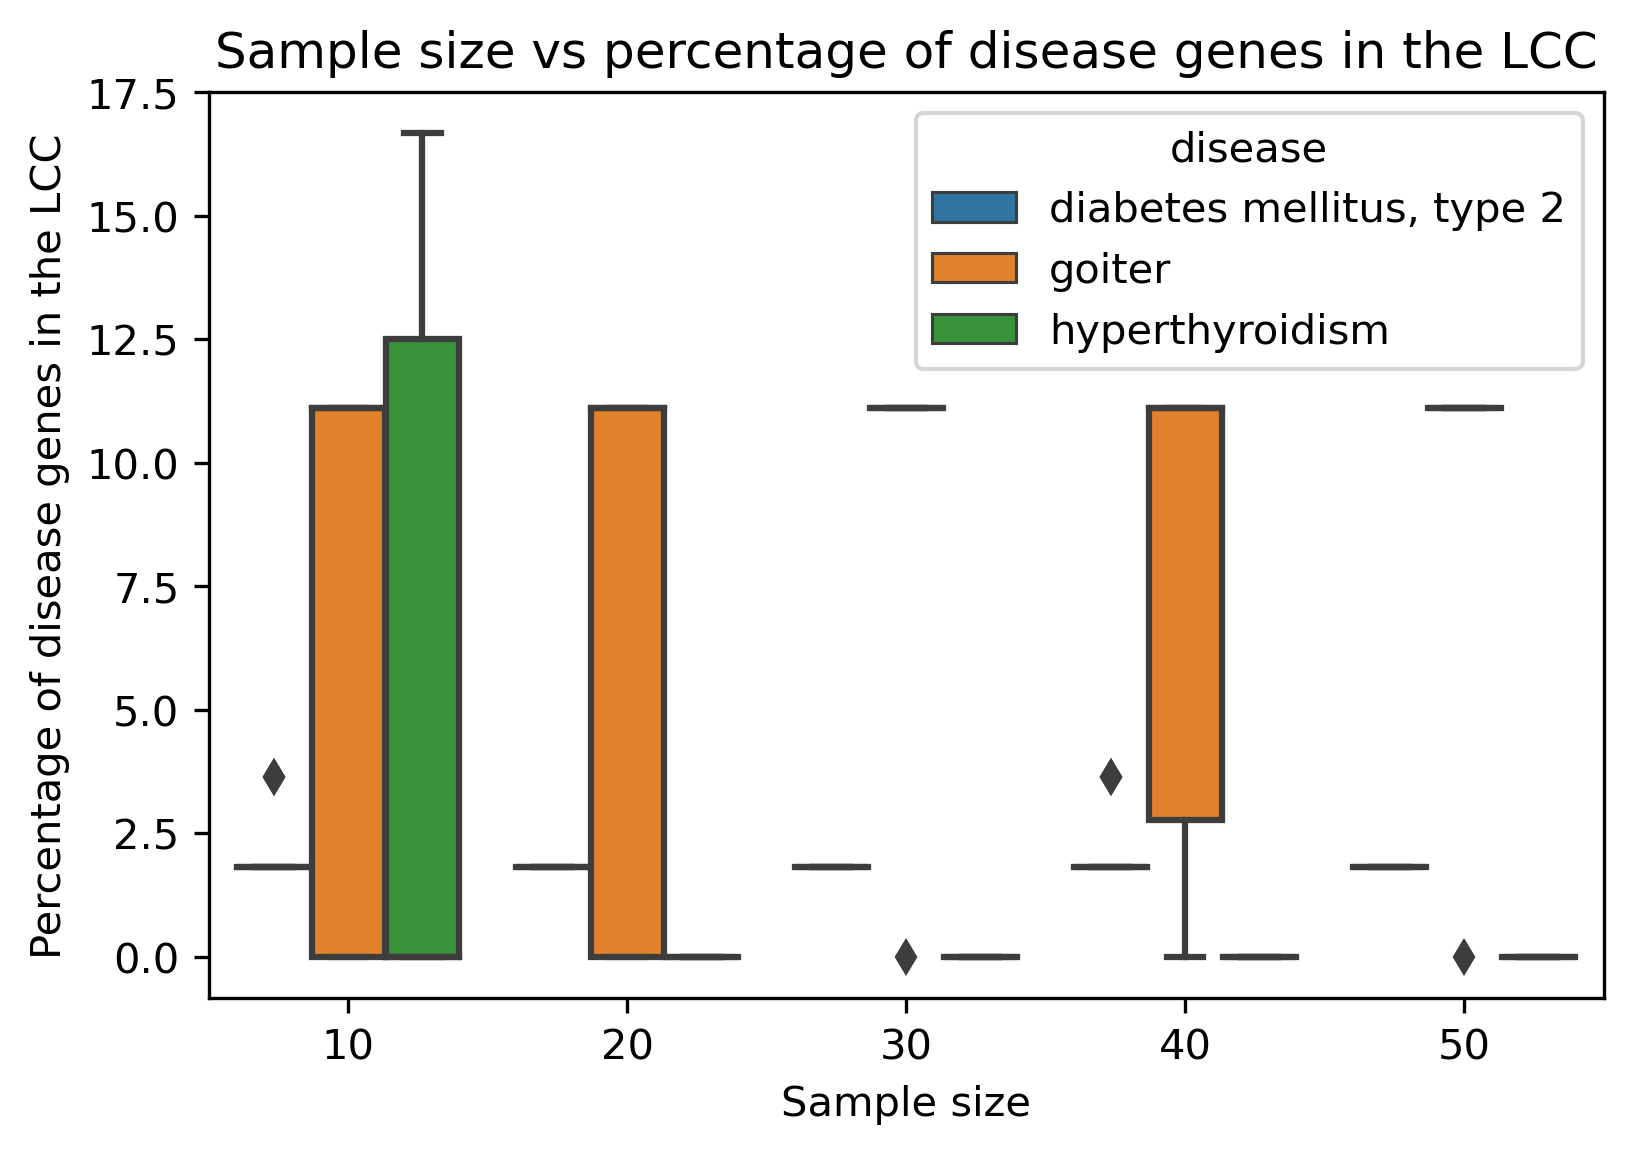

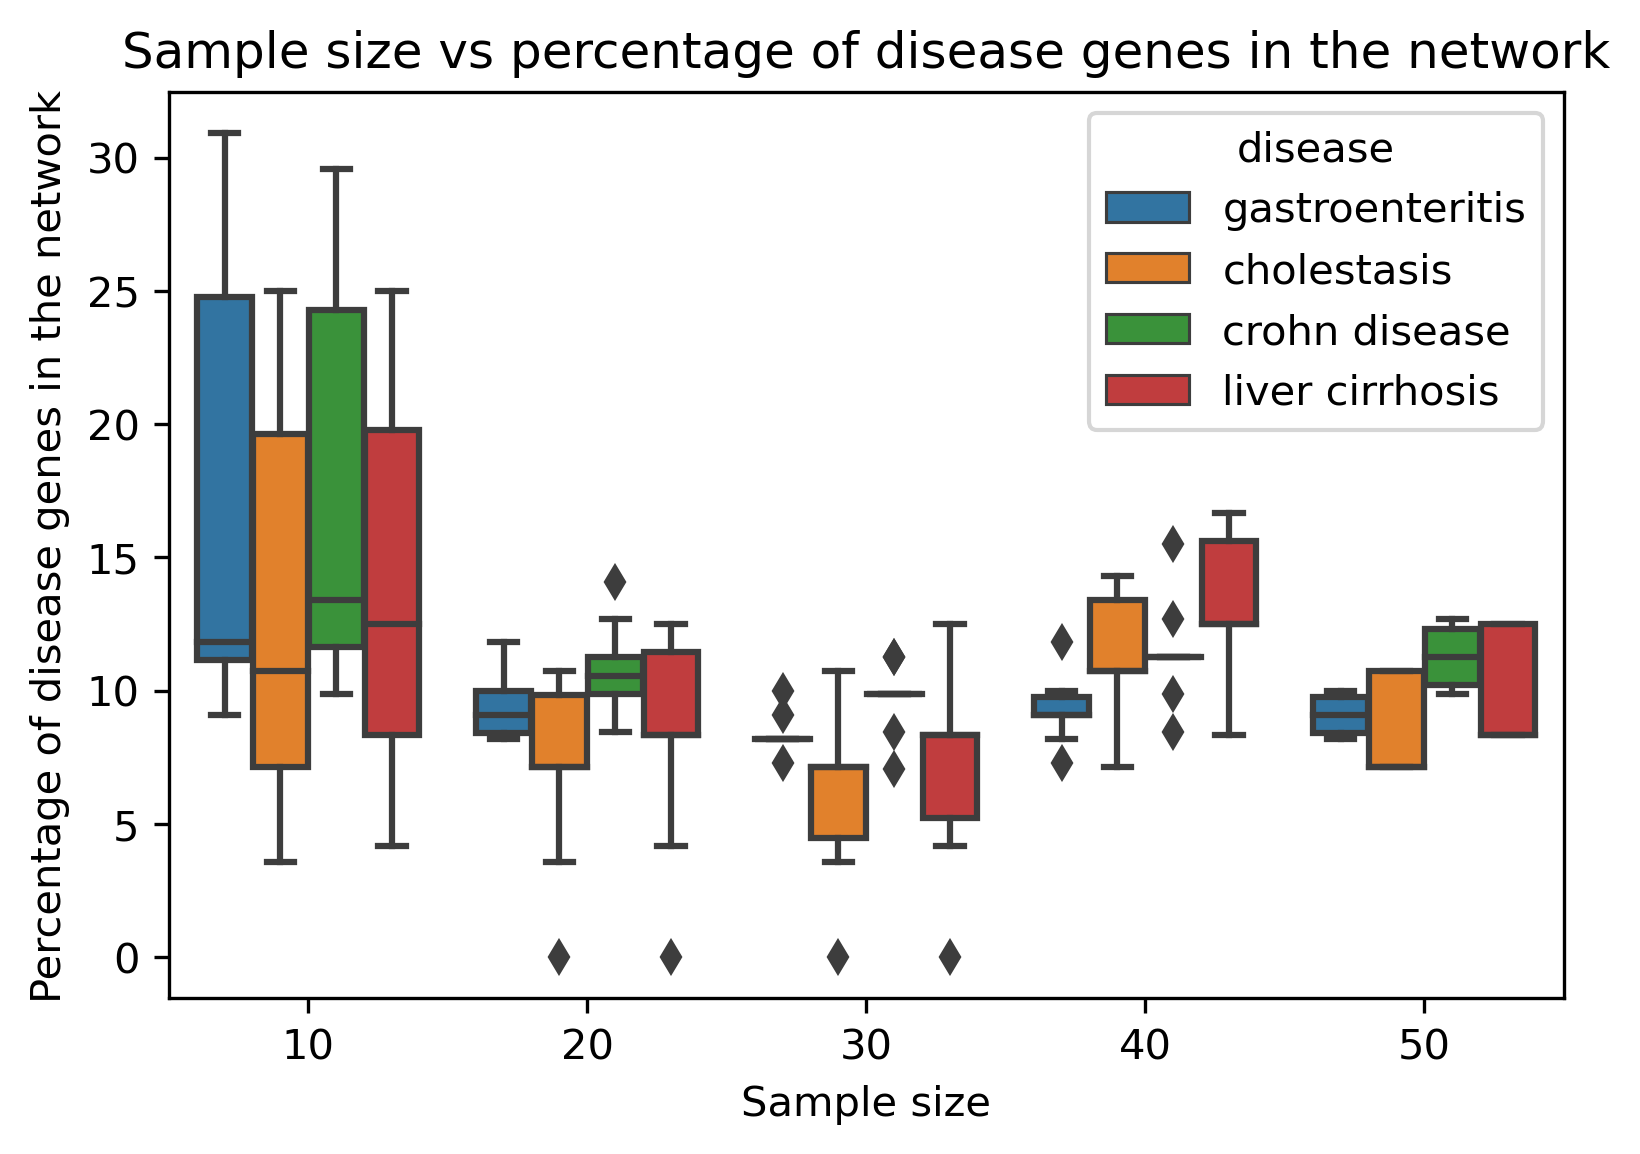

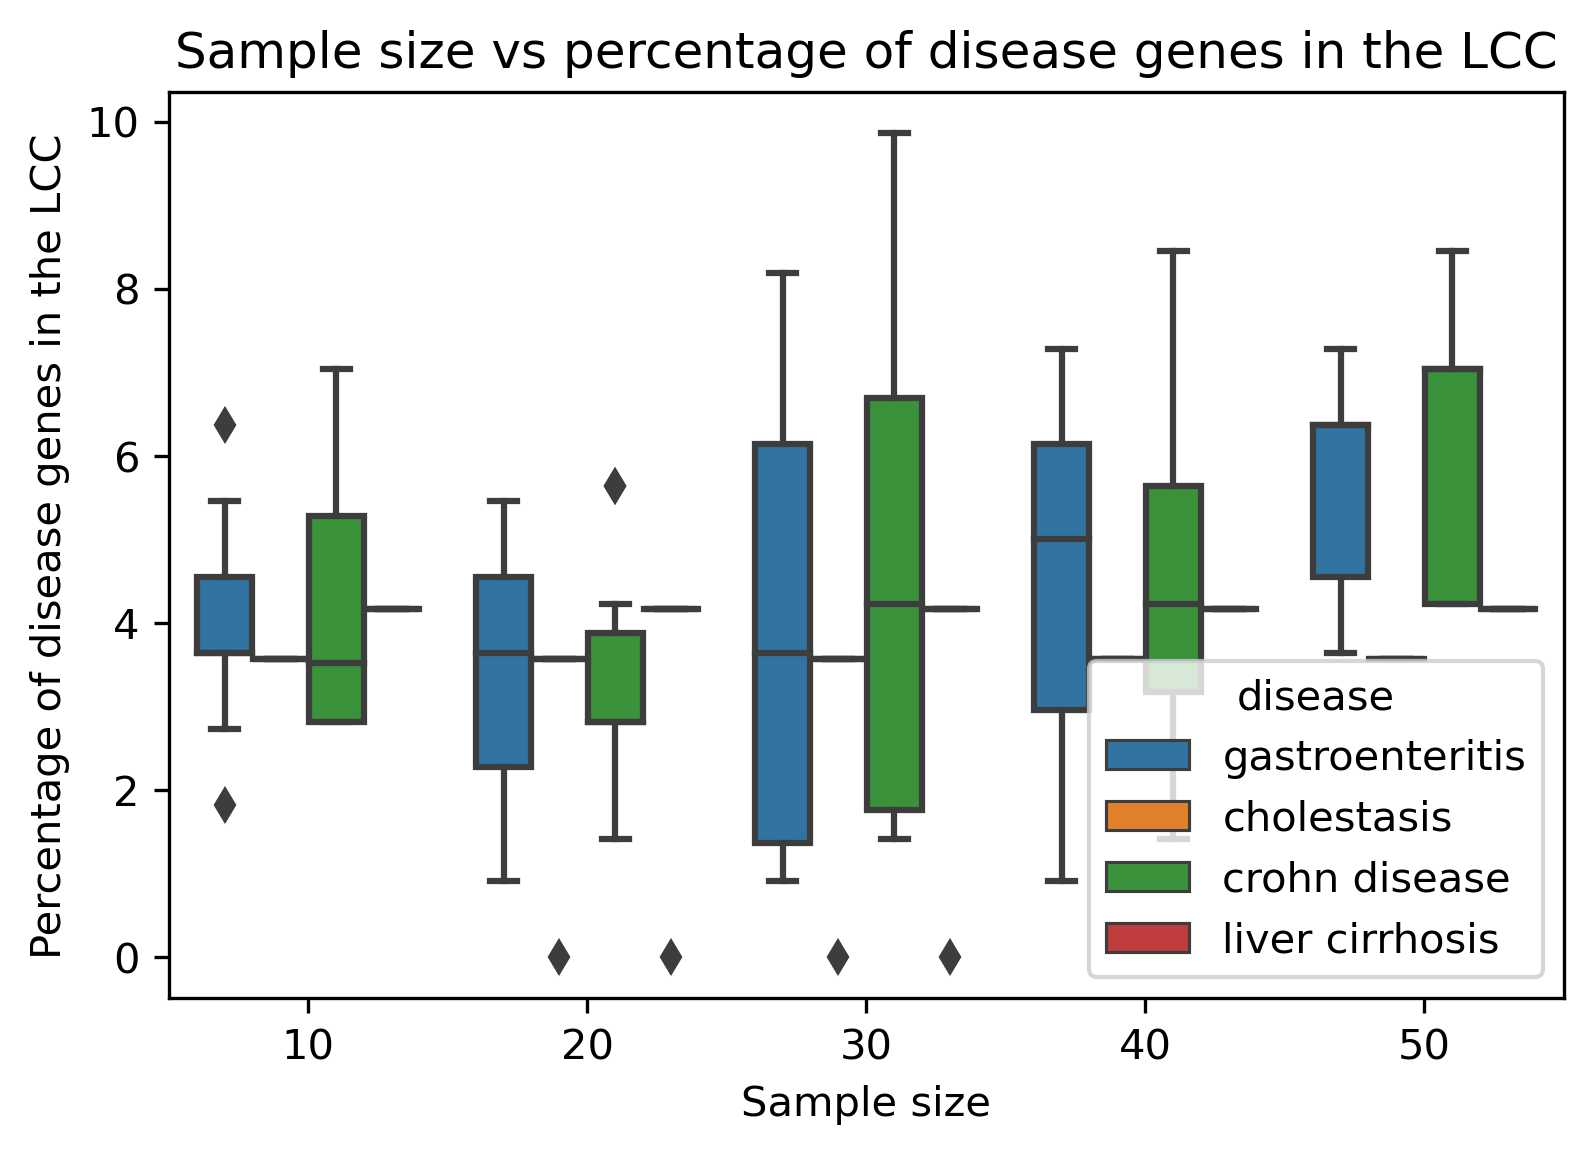

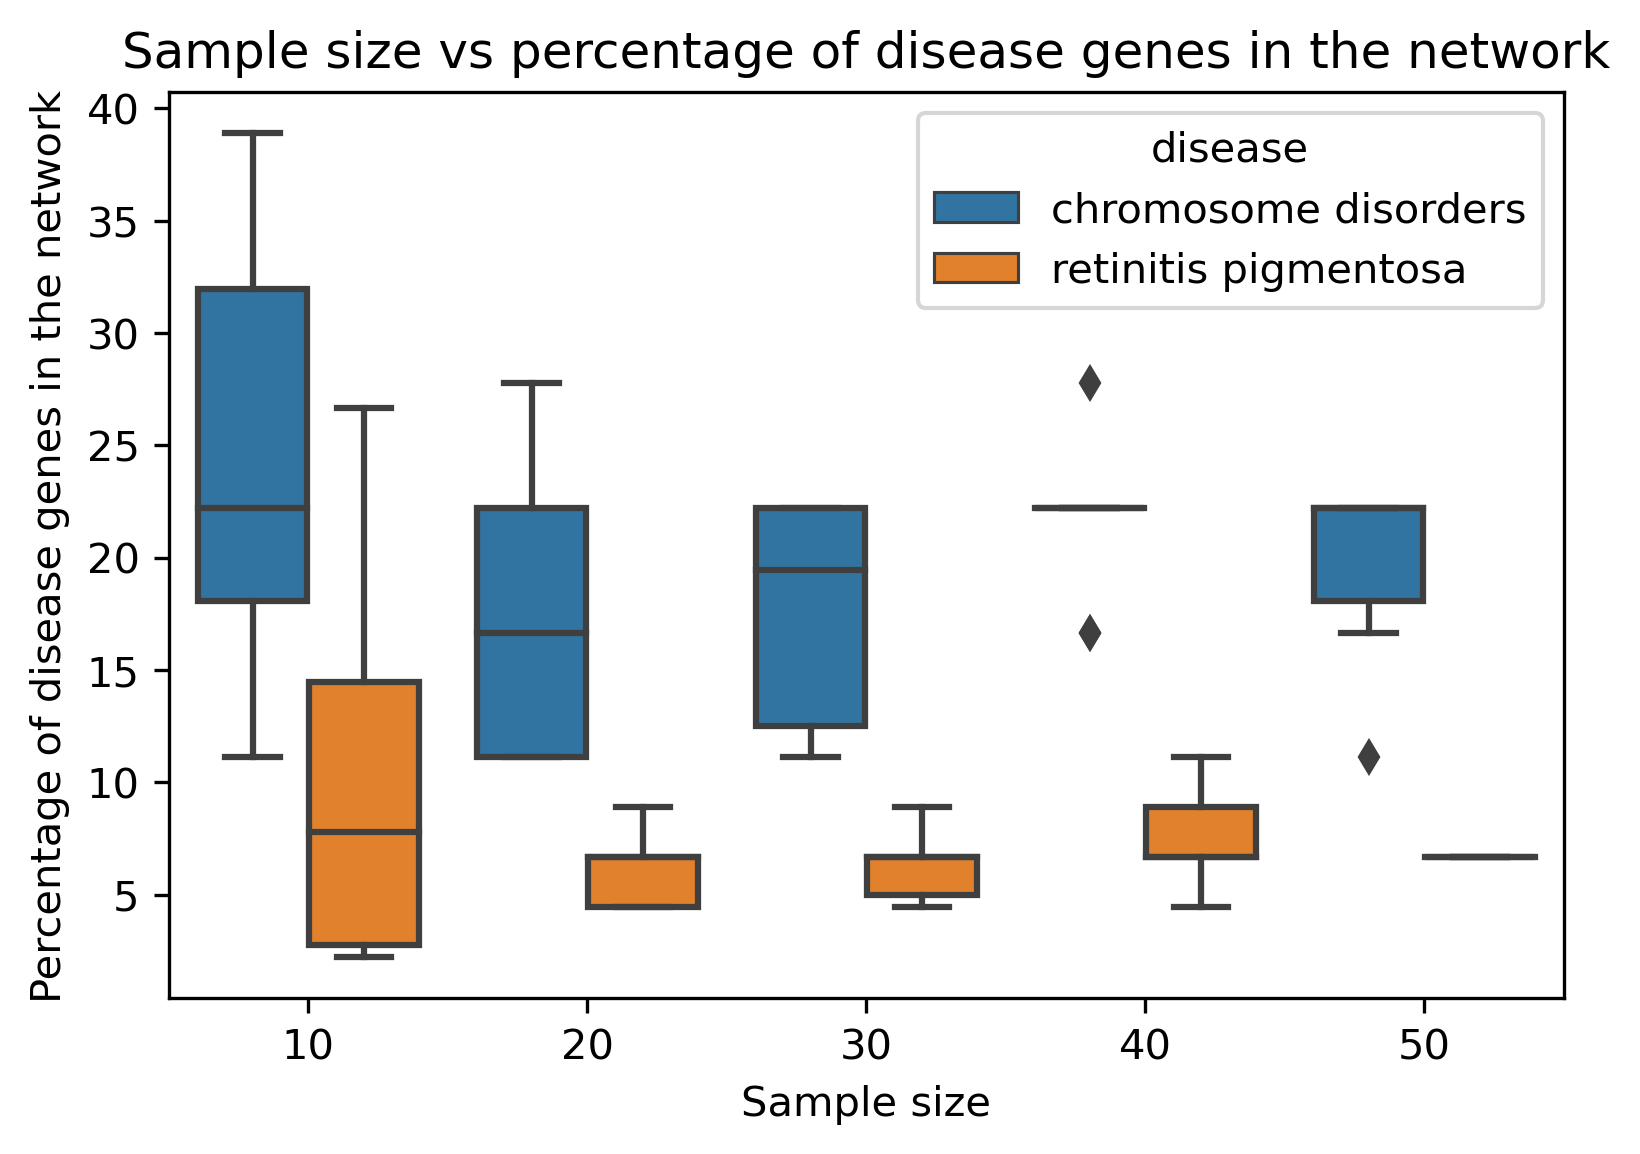

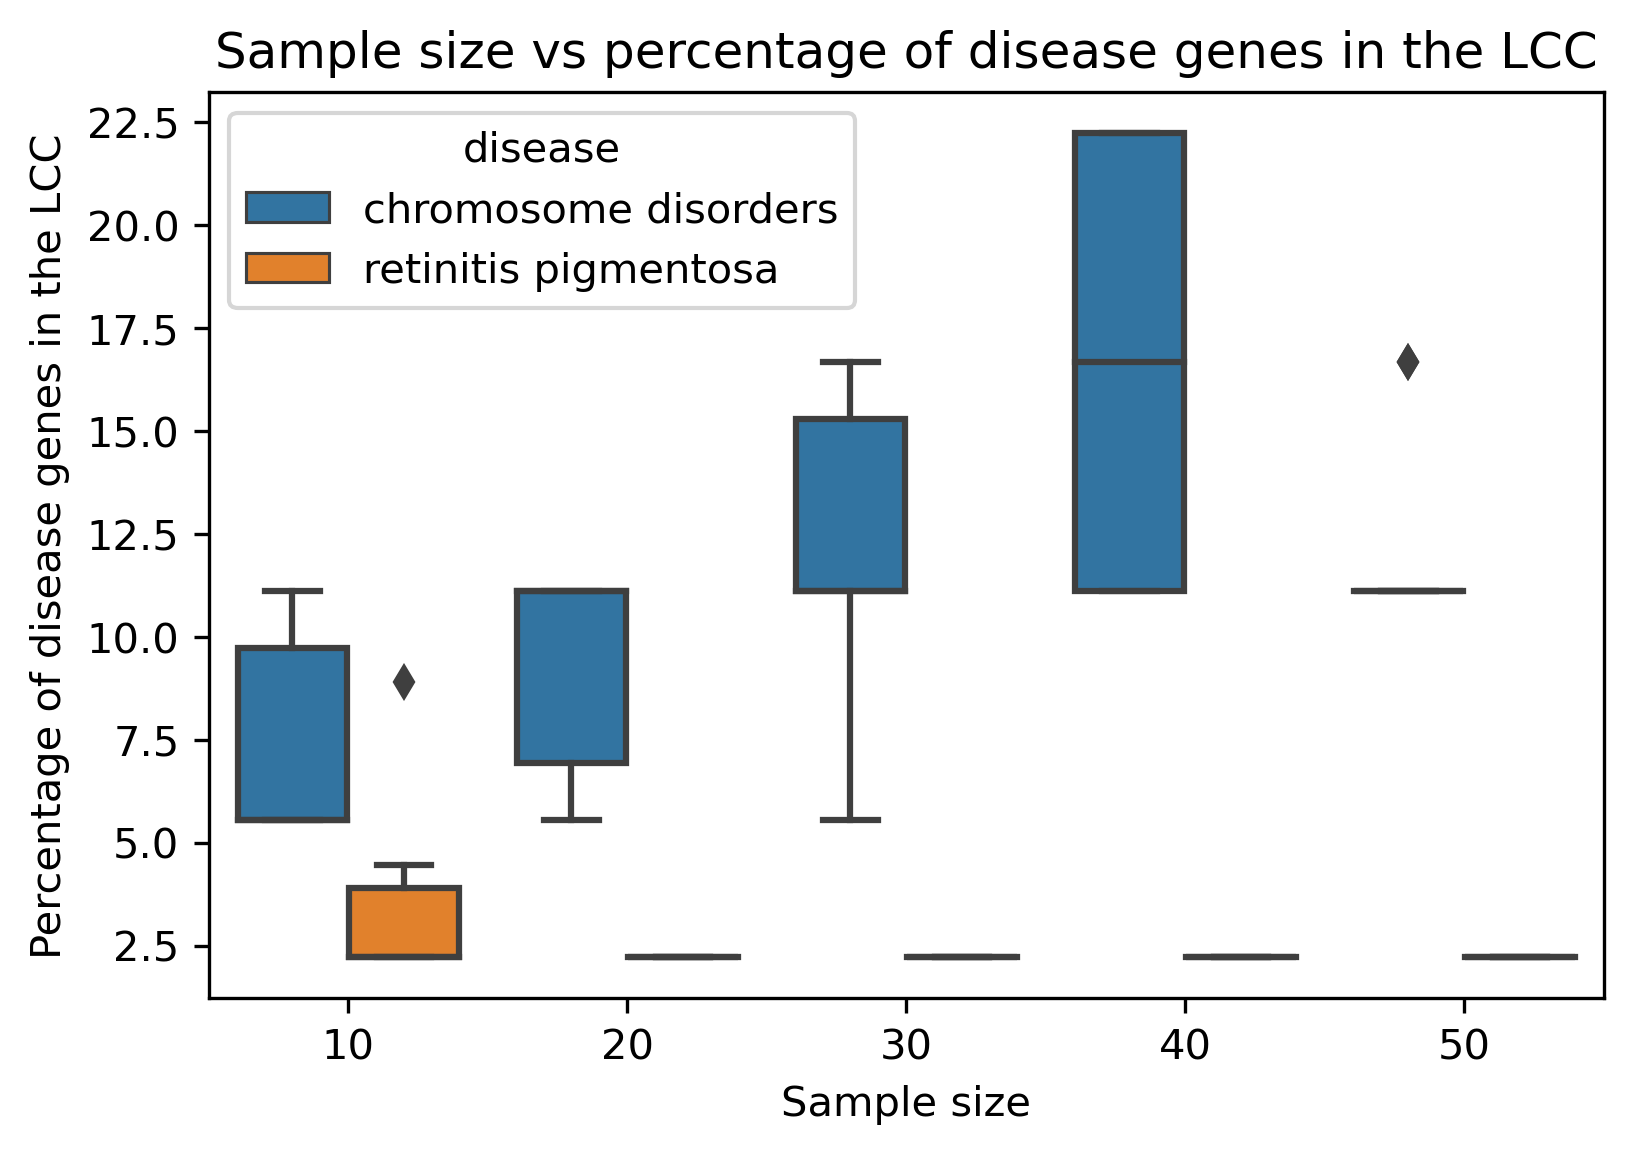

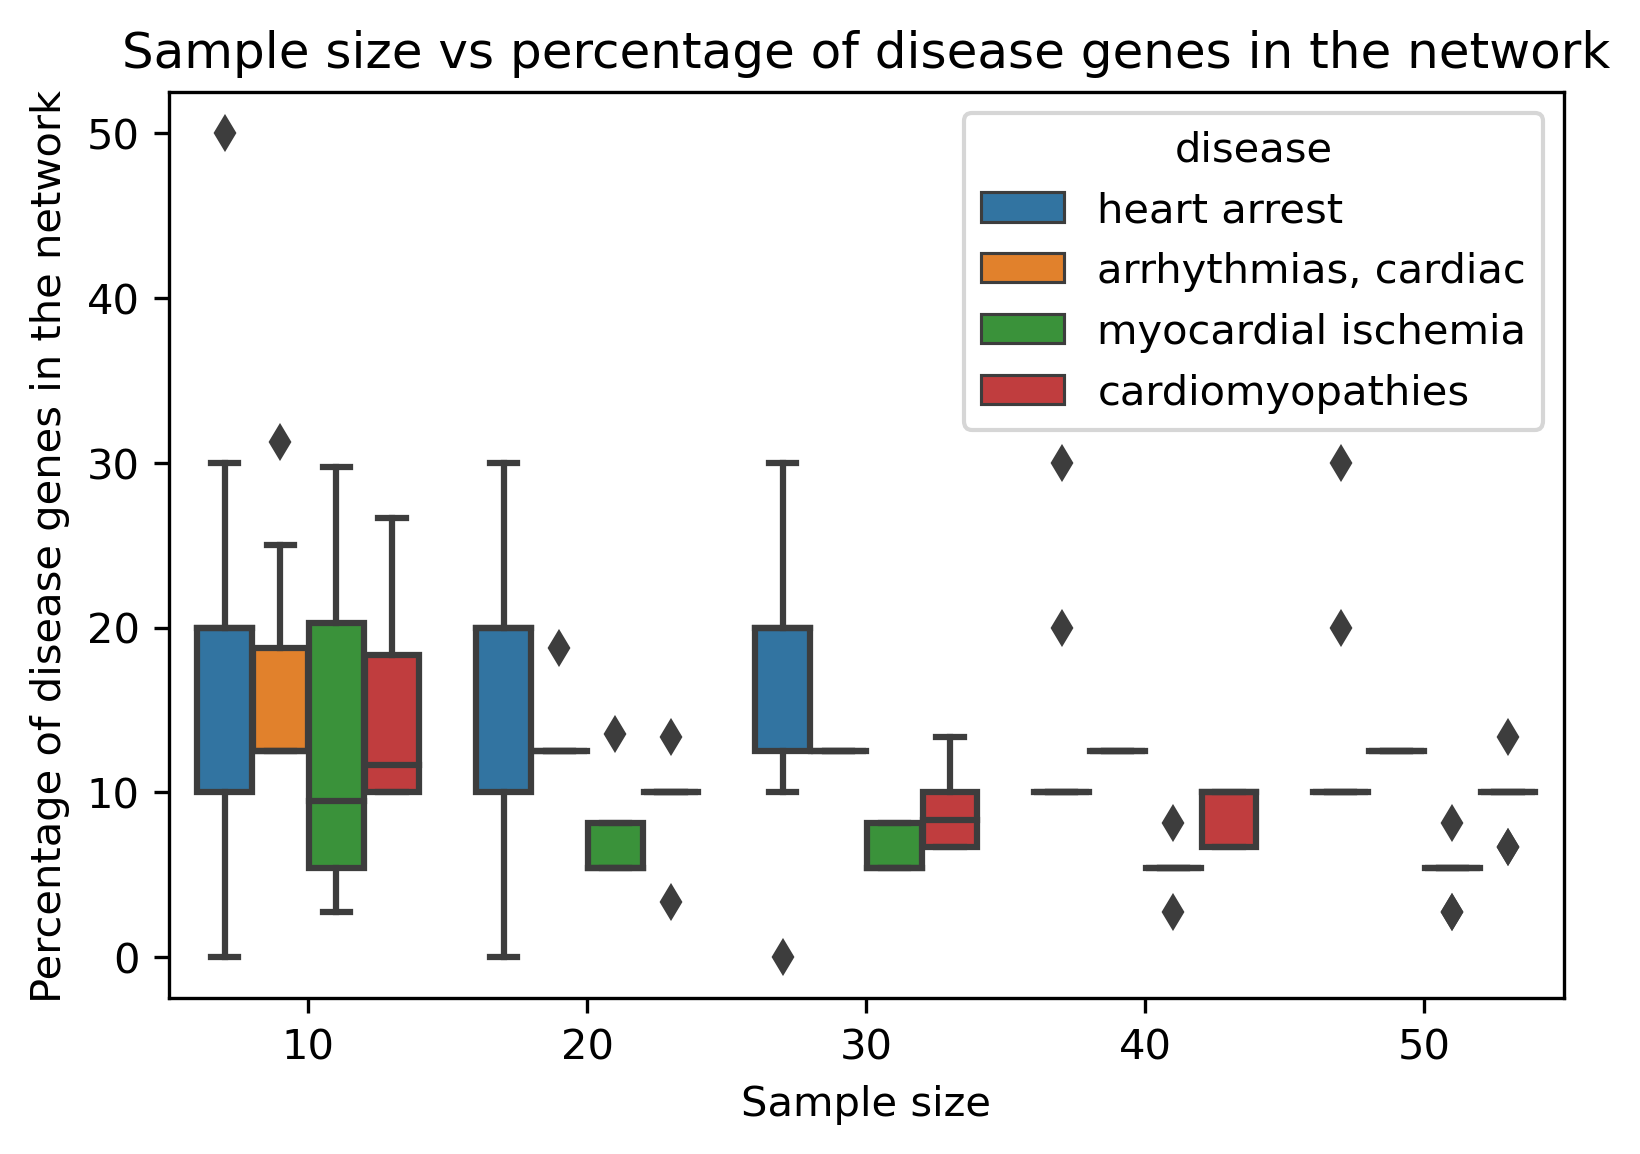

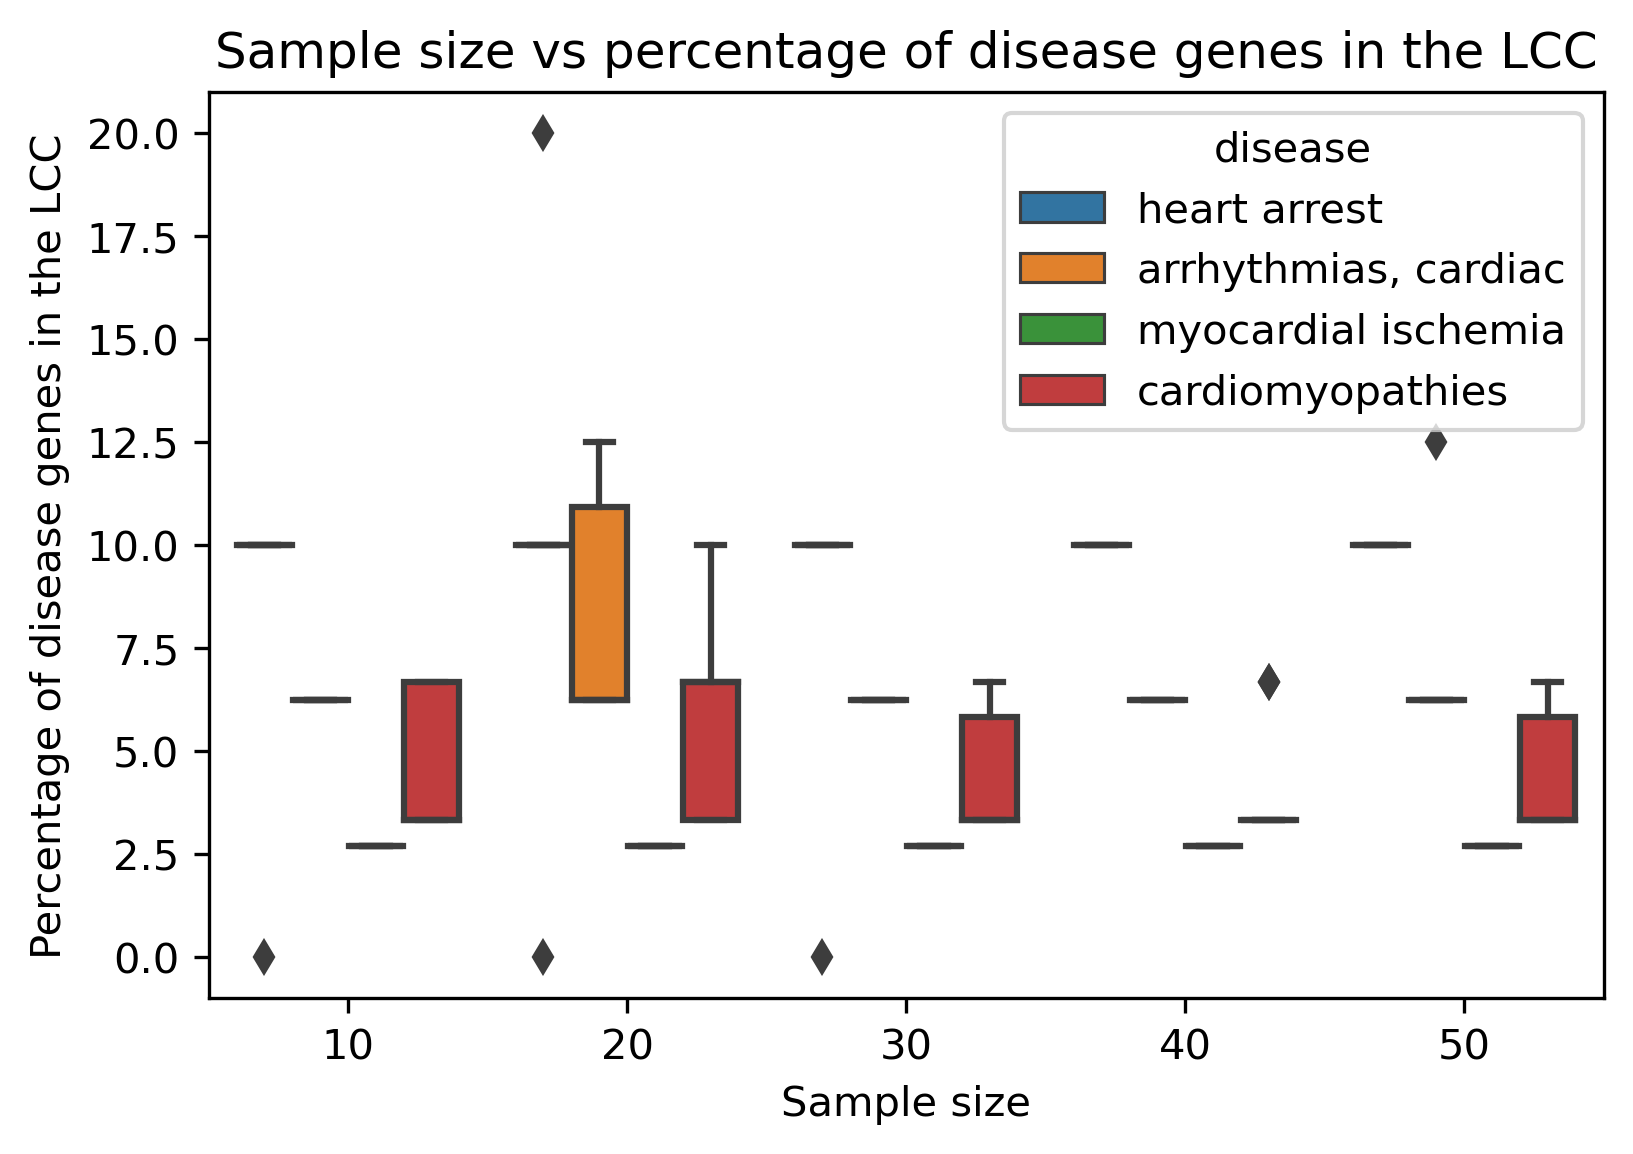

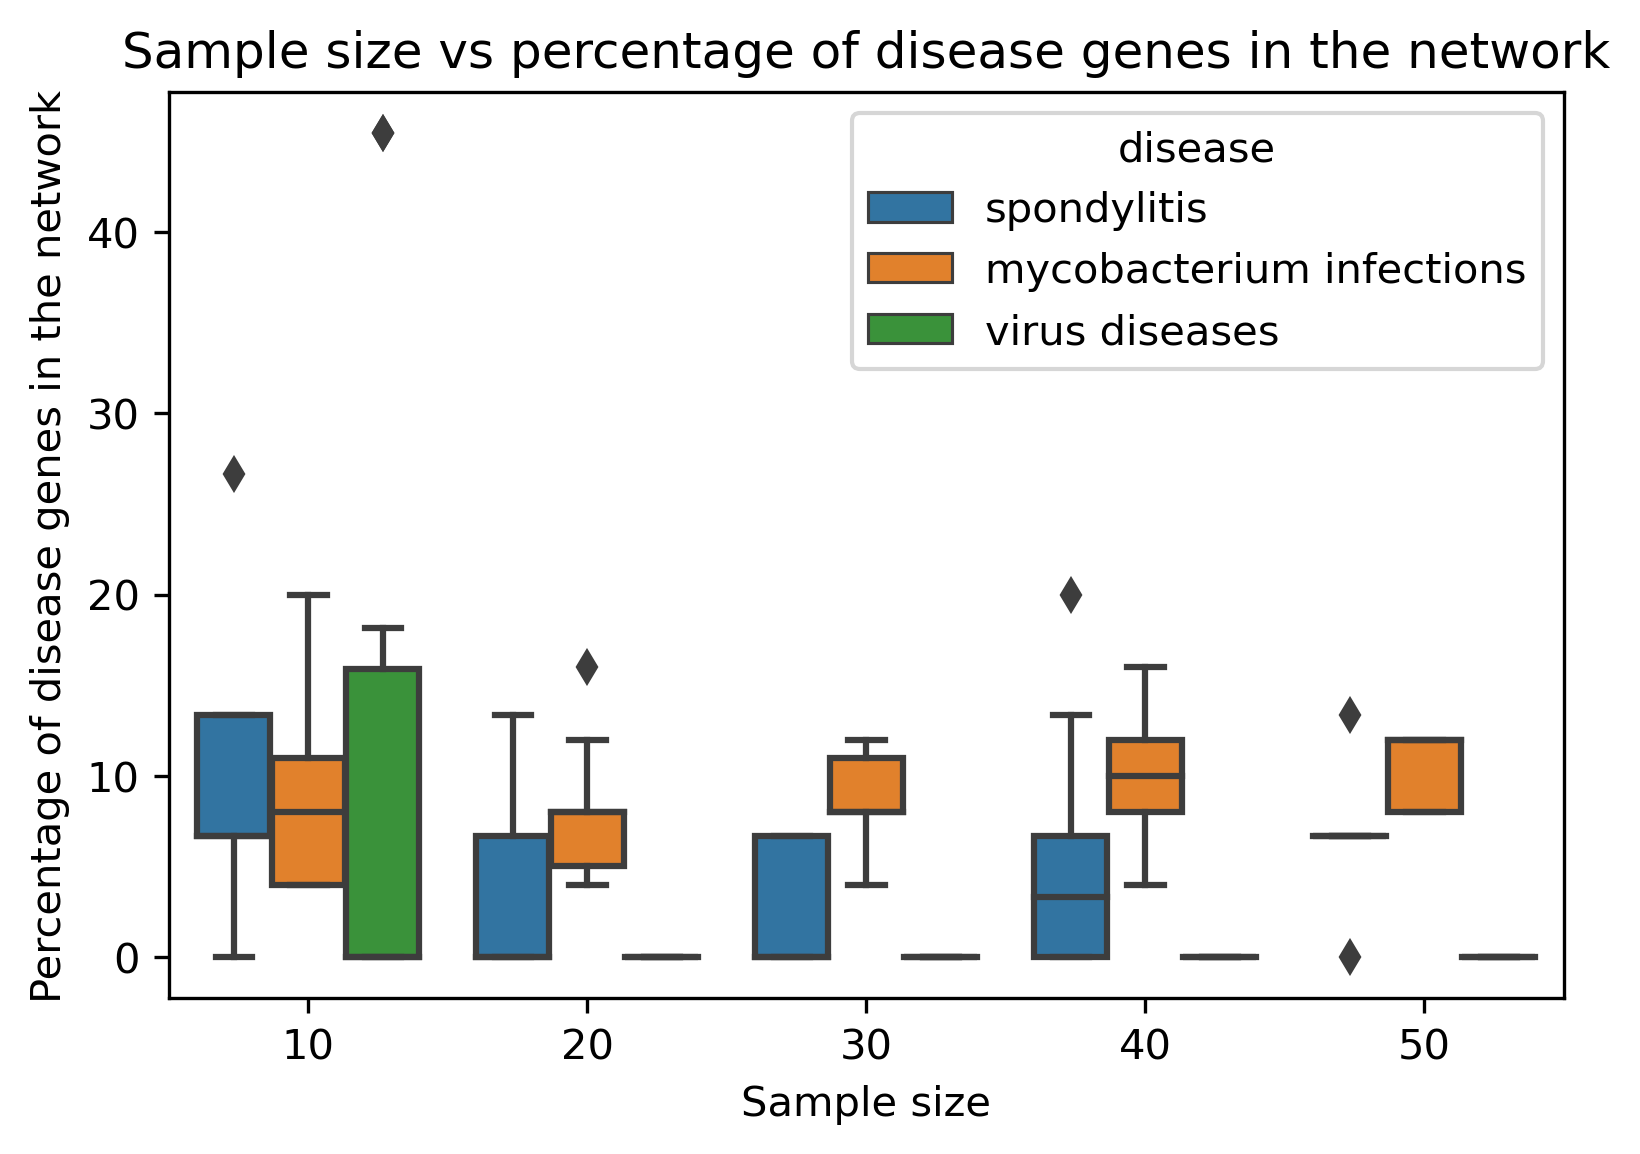

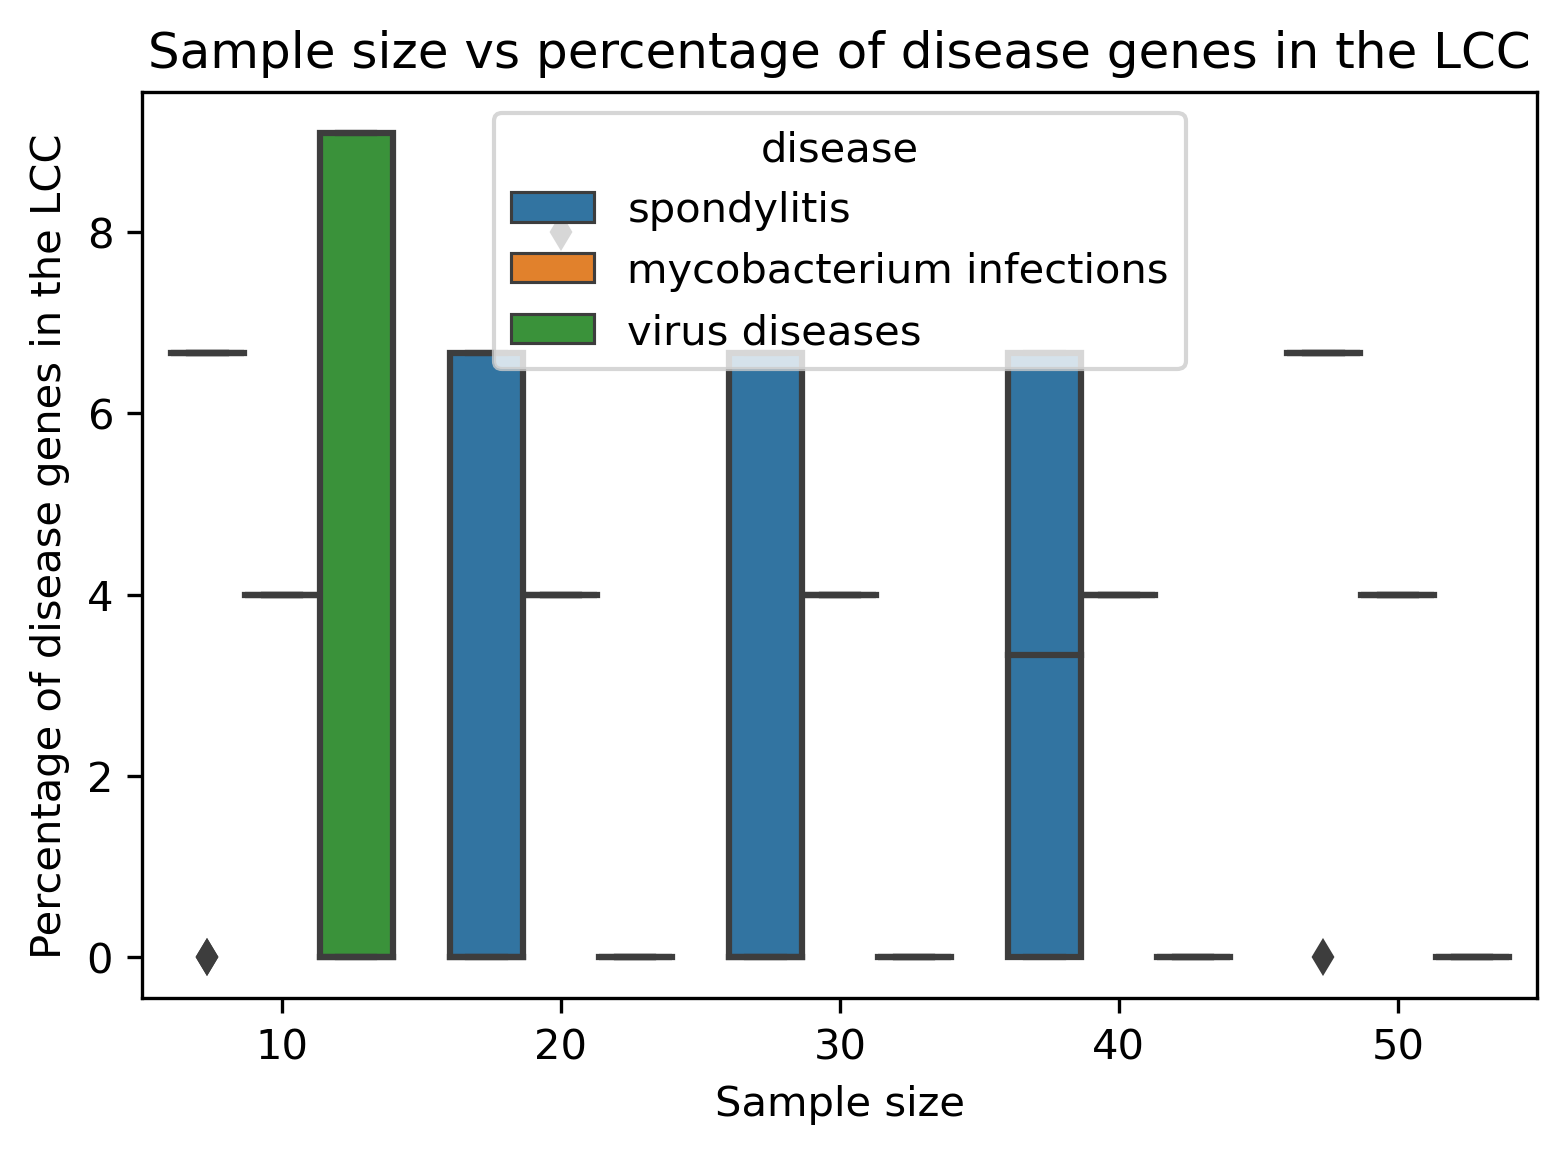

In [45]:
# Create a plot for each disease class selected
pval_adj_cutoff = 0.01
top_percent = 0.1
selected_disease_classes = ["nutritional and metabolic diseases", "nervous system diseases", "neoplasms", "immune system diseases", "endocrine system diseases", "digestive system diseases", "congenital, hereditary, and neonatal diseases and abnormalities", "cardiovascular diseases", "infections"]
selected_classes_to_diseases = {
    "nutritional and metabolic diseases" : ["celiac disease", "amyotrophic lateral sclerosis", "obesity", "diabetes mellitus, type 1", "diabetes mellitus, type 2"],
    "nervous system diseases" : ["parkinson disease", "epilepsy", "alzheimer disease"],
    "neoplasms" : ["leukemia, myeloid", "breast neoplasms", "kidney neoplasms", "colorectal neoplasm", "lung neoplasms"],
    "immune system diseases" : ["arthritis, rheumatoid", "asthma", "graves disease", "multiple sclerosis"],
    "endocrine system diseases" : ["diabetes mellitus, type 2", "hyperthyroidism", "goiter"],
    "digestive system diseases" : ["crohn disease", "cholestasis", "liver cirrhosis", "gastroenteritis"],
    "congenital, hereditary, and neonatal diseases and abnormalities" : ["retinitis pigmentosa", "chromosome disorders"],
    "cardiovascular diseases" : ["arrhythmias, cardiac", "myocardial ischemia", "heart arrest", "cardiomyopathies"],
    "infections" : ["spondylitis", "mycobacterium infections", "virus diseases"]
}
for disease_class in selected_classes_to_diseases:

    # Get the top 5 diseases of the disease class with more genes in the dataset
    disease_class_info_df = disease_info_df[disease_info_df["disease_class"] == disease_class].drop_duplicates().reset_index(drop=True)
    #top5 = pd.to_numeric(disease_class_info_df['total_disease_genes_in_dataset']).nlargest(5)
    #top5_df = disease_class_info_df.loc[top5.index,]
    #diseases = top5_df['disease'].to_list()
    diseases = selected_classes_to_diseases[disease_class]
    disease_class_selection_df = disease_df[(disease_df['disease'].isin(diseases)) & (disease_df['disease_class'] == disease_class) & (disease_df['pval_adj_cutoff'] == pval_adj_cutoff) & (disease_df['top_percent'] == top_percent)].reset_index(drop=True)

    # Calculate the percentage of disease genes in the network and in the LCC
    disease_class_selection_df['percent_disease_genes_in_network'] = disease_class_selection_df['disease_genes_in_network']/disease_class_selection_df['total_disease_genes_in_dataset']*100
    disease_class_selection_df['percent_disease_genes_in_lcc'] = disease_class_selection_df['lcc_size']/disease_class_selection_df['total_disease_genes_in_dataset']*100

    # Plot the results
    fig = pylab.figure(dpi=300)
    sns.boxplot(data=disease_class_selection_df, x='size', y='percent_disease_genes_in_network', hue='disease')
    plt.title('Sample size vs percentage of disease genes in the network')
    plt.xlabel('Sample size')
    plt.ylabel('Percentage of disease genes in the network')
    pylab.savefig(os.path.join(plots_dir, 'disease_genes_in_network_vs_sample_size_pval_{}_top_{}_class_{}.png'.format(pval_adj_cutoff, top_percent, disease_class)), format='png')
    plt.show()
    fig = pylab.figure(dpi=300)
    sns.boxplot(data=disease_class_selection_df, x='size', y='percent_disease_genes_in_lcc', hue='disease')
    plt.title('Sample size vs percentage of disease genes in the LCC')
    plt.xlabel('Sample size')
    plt.ylabel('Percentage of disease genes in the LCC')
    pylab.savefig(os.path.join(plots_dir, 'disease_genes_in_lcc_vs_sample_size_pval_{}_top_{}_class_{}.png'.format(pval_adj_cutoff, top_percent, disease_class)), format='png')
    plt.show()


### Sample size effect on diseases of different class

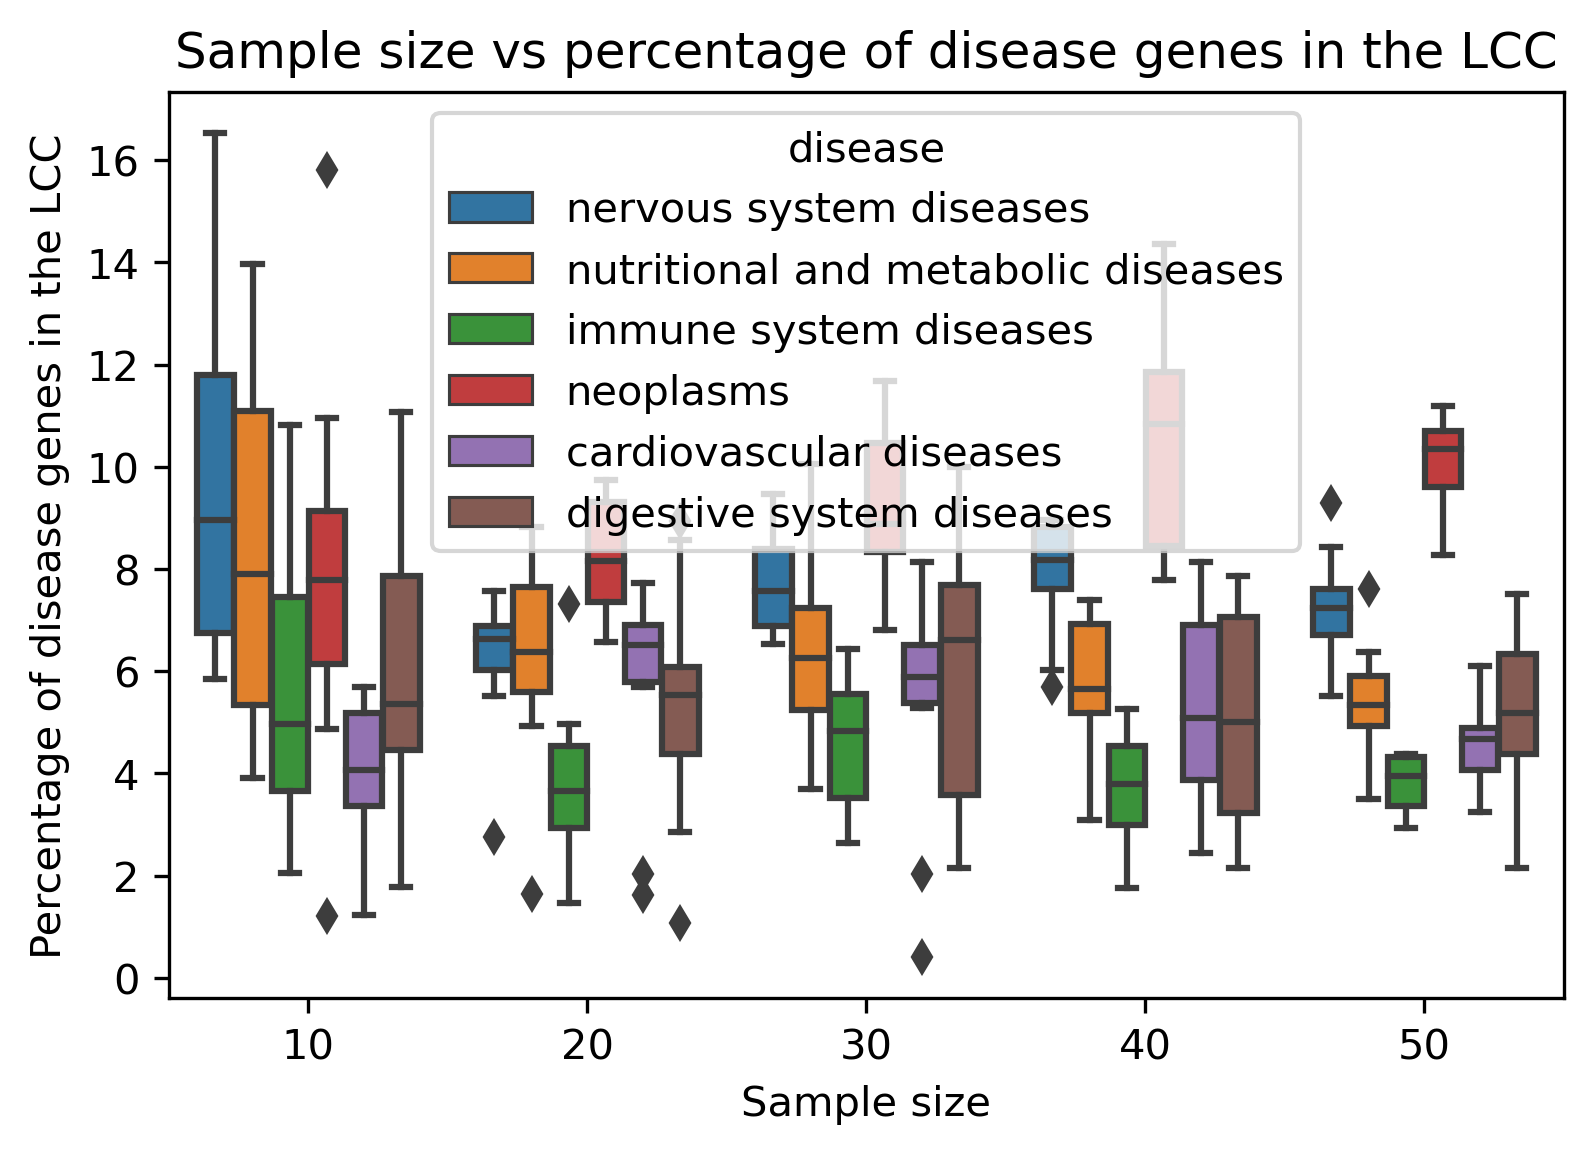

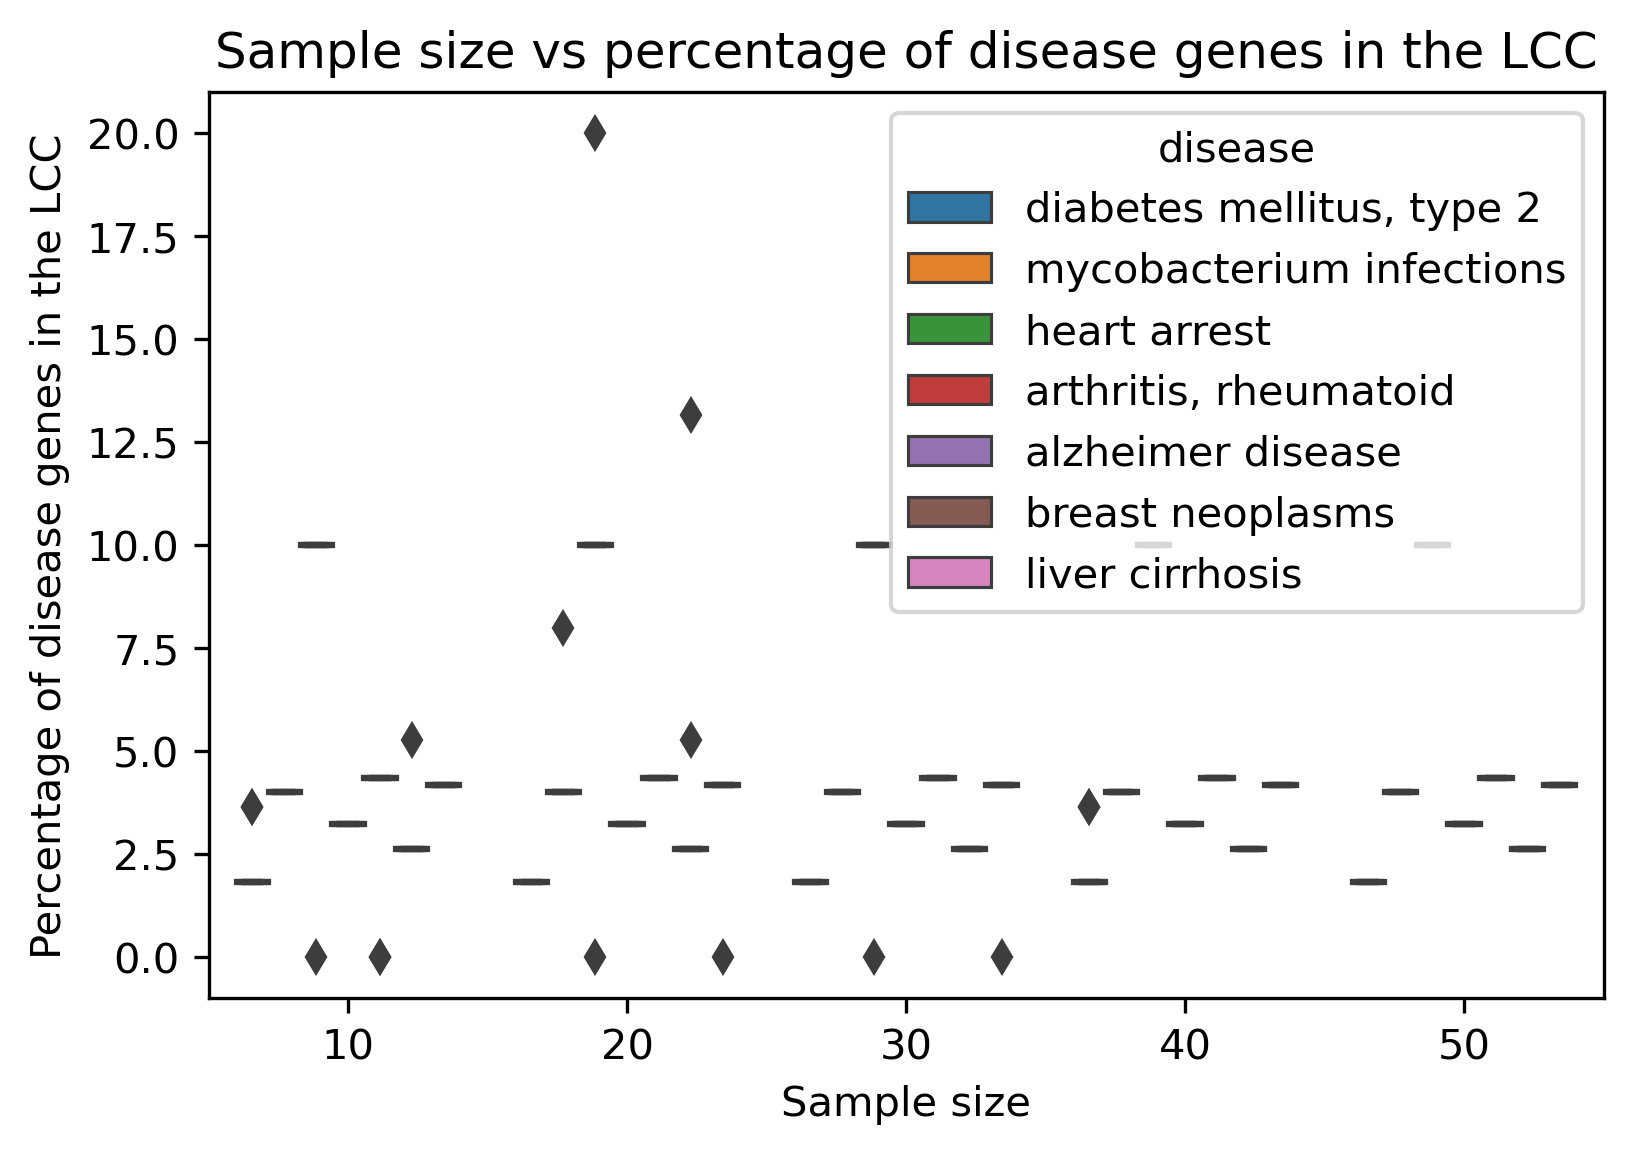

In [48]:
# Create a plot for each disease class selected
pval_adj_cutoff = 0.01
top_percent = 0.1
selected_disease_classes = ["nutritional and metabolic diseases", "nervous system diseases", "neoplasms", "immune system diseases", "endocrine system diseases", "digestive system diseases", "congenital, hereditary, and neonatal diseases and abnormalities", "cardiovascular diseases", "infections"]
selected_class_to_specific_disease = {
    "nutritional and metabolic diseases" : "diabetes mellitus, type 2",
    "nervous system diseases" : "alzheimer disease",
    "neoplasms" : "breast neoplasms",
    "immune system diseases" : "arthritis, rheumatoid",
    "digestive system diseases" : "liver cirrhosis",
    "cardiovascular diseases" : "heart arrest",
    "infections" : "mycobacterium infections"
}


# Plot general terms of different disease classes
disease_class_selection_df1 = disease_df[(disease_df['disease'].isin(selected_class_to_specific_disease.keys())) & (disease_df['disease_class'].isin(selected_class_to_specific_disease.keys())) & (disease_df['pval_adj_cutoff'] == pval_adj_cutoff) & (disease_df['top_percent'] == top_percent)].reset_index(drop=True)
disease_class_selection_df1['percent_disease_genes_in_network'] = disease_class_selection_df1['disease_genes_in_network']/disease_class_selection_df1['total_disease_genes_in_dataset']*100
disease_class_selection_df1['percent_disease_genes_in_lcc'] = disease_class_selection_df1['lcc_size']/disease_class_selection_df1['total_disease_genes_in_dataset']*100
fig = pylab.figure(dpi=300)
sns.boxplot(data=disease_class_selection_df1, x='size', y='percent_disease_genes_in_lcc', hue='disease')
plt.title('Sample size vs percentage of disease genes in the LCC')
plt.xlabel('Sample size')
plt.ylabel('Percentage of disease genes in the LCC')
pylab.savefig(os.path.join(plots_dir, 'disease_genes_in_lcc_vs_sample_size_by_general_classes.png'), format='png')
plt.show()

disease_class_selection_df2 = disease_df[(disease_df['disease'].isin(selected_class_to_specific_disease.values())) & (disease_df['disease_class'].isin(selected_class_to_specific_disease.keys())) & (disease_df['pval_adj_cutoff'] == pval_adj_cutoff) & (disease_df['top_percent'] == top_percent)].reset_index(drop=True)
disease_class_selection_df2['percent_disease_genes_in_network'] = disease_class_selection_df2['disease_genes_in_network']/disease_class_selection_df2['total_disease_genes_in_dataset']*100
disease_class_selection_df2['percent_disease_genes_in_lcc'] = disease_class_selection_df2['lcc_size']/disease_class_selection_df2['total_disease_genes_in_dataset']*100
fig = pylab.figure(dpi=300)
sns.boxplot(data=disease_class_selection_df2, x='size', y='percent_disease_genes_in_lcc', hue='disease')
plt.title('Sample size vs percentage of disease genes in the LCC')
plt.xlabel('Sample size')
plt.ylabel('Percentage of disease genes in the LCC')
pylab.savefig(os.path.join(plots_dir, 'disease_genes_in_lcc_vs_sample_size_by_specific_diseases.png'), format='png')
plt.show()


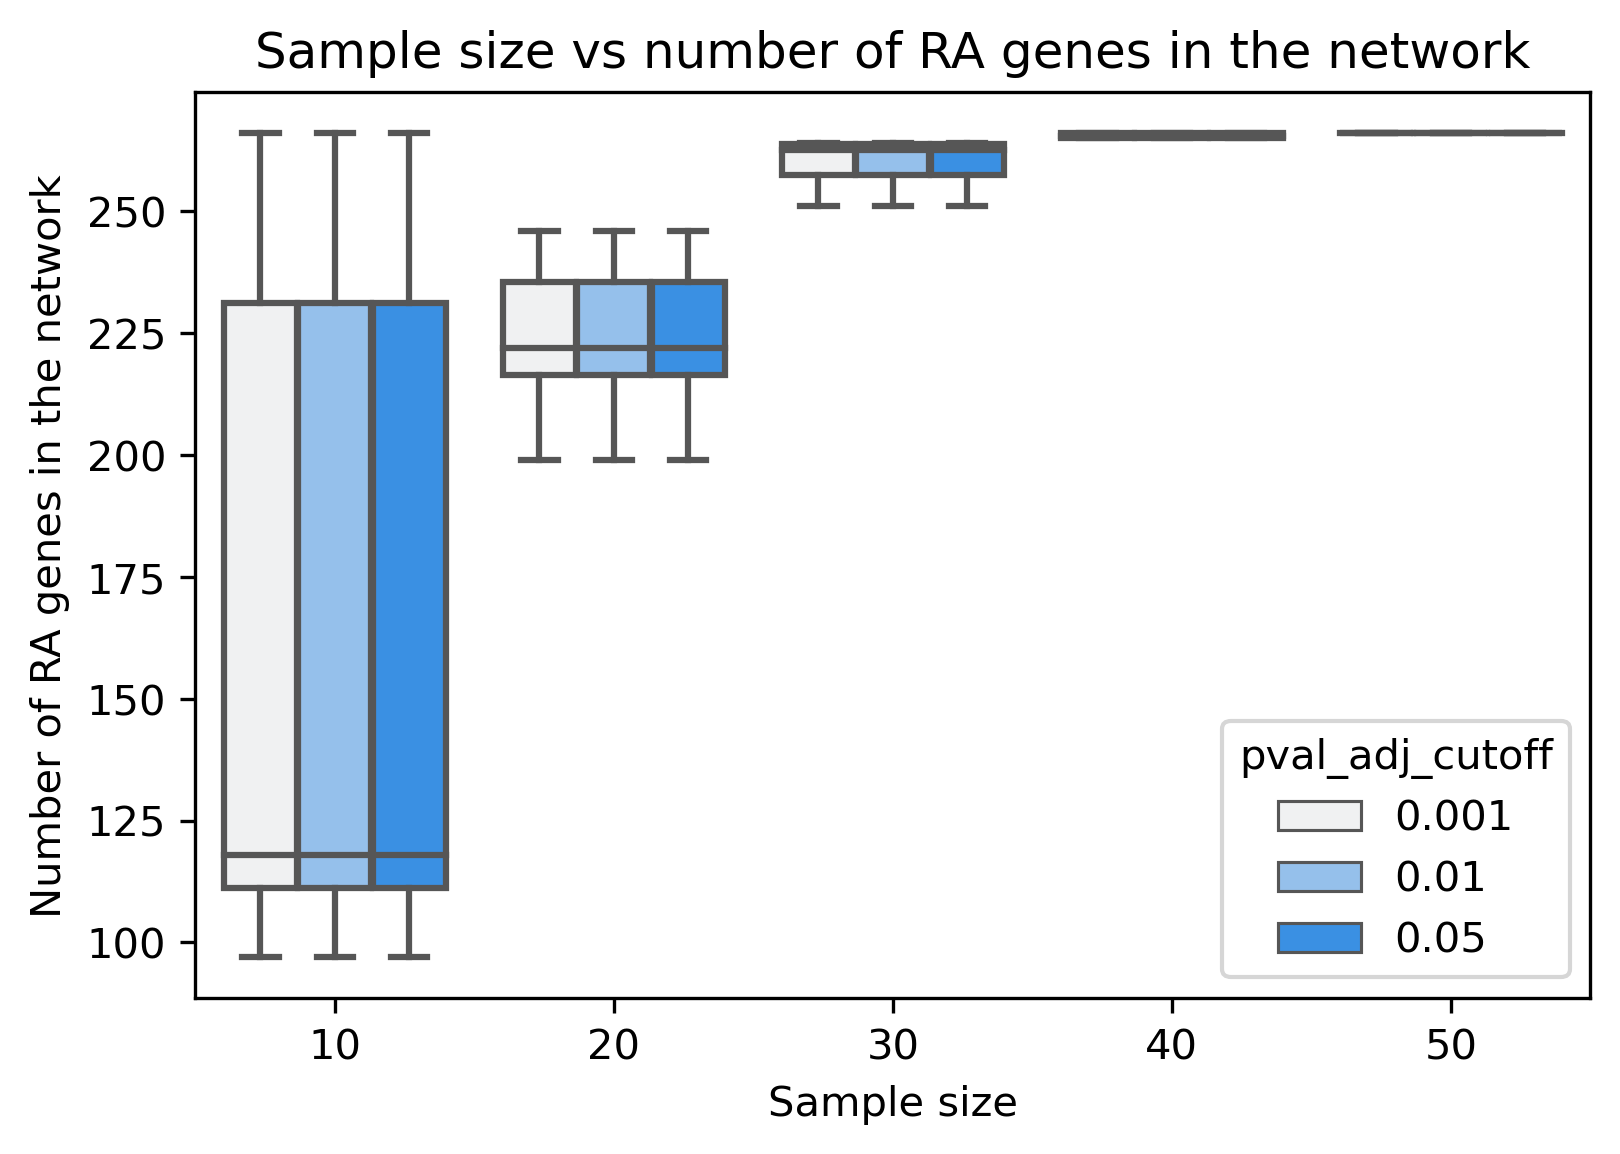

In [17]:
# Plot num. of RA genes in the network vs. sample size
fig = pylab.figure(dpi=300)
sns.boxplot(data=disease_df, x='size', y='disease_genes_in_network', hue="pval_adj_cutoff", color='dodgerblue')
plt.title('Sample size vs number of RA genes in the network')
plt.xlabel('Sample size')
plt.ylabel('Number of RA genes in the network')
pylab.savefig(os.path.join(plots_dir, 'disease_genes_in_network_vs_sample_size.png'), format='png')
plt.show()


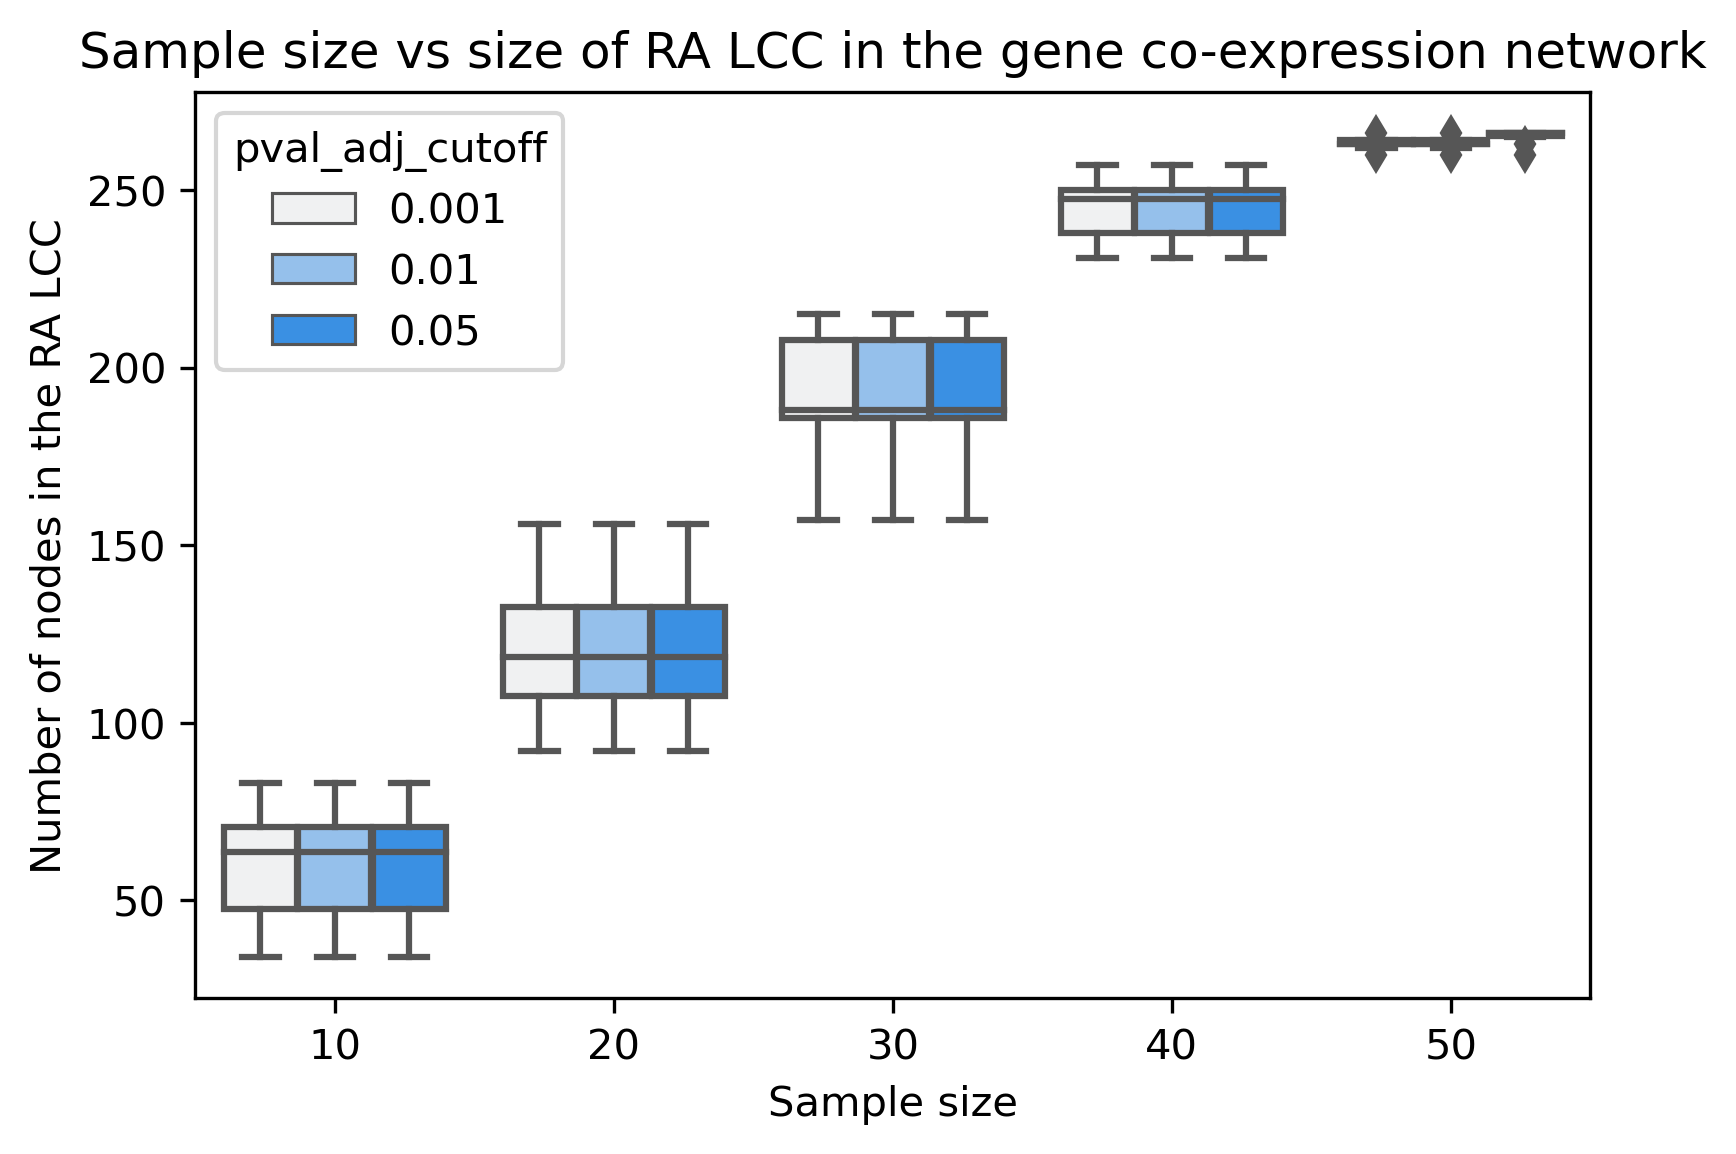

In [19]:
# Plot size of RA LCC in the network vs. sample size
fig = pylab.figure(dpi=300)
sns.boxplot(data=disease_df, x='size', y='disease_lcc_size', hue="pval_adj_cutoff", color='dodgerblue')
plt.title('Sample size vs size of RA LCC in the gene co-expression network')
plt.xlabel('Sample size')
plt.ylabel('Number of nodes in the RA LCC')
pylab.savefig(os.path.join(plots_dir, 'disease_LCC_size_in_network_vs_sample_size.png'), format='png')
plt.show()
